<a href="https://colab.research.google.com/github/Yuto-Kishi/ECHONET-Lite/blob/main/Untitled36.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📥 Loading CSV...
Resampling to 1min...

RUN: Living (RF 2-stage)

[Living][RF 2-stage] setting=all | features=1281 | train=20111 test=5040
label dist test: {0: 4591, 1: 242, 2: 207}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9956
[[4590    1]
 [  21  428]]


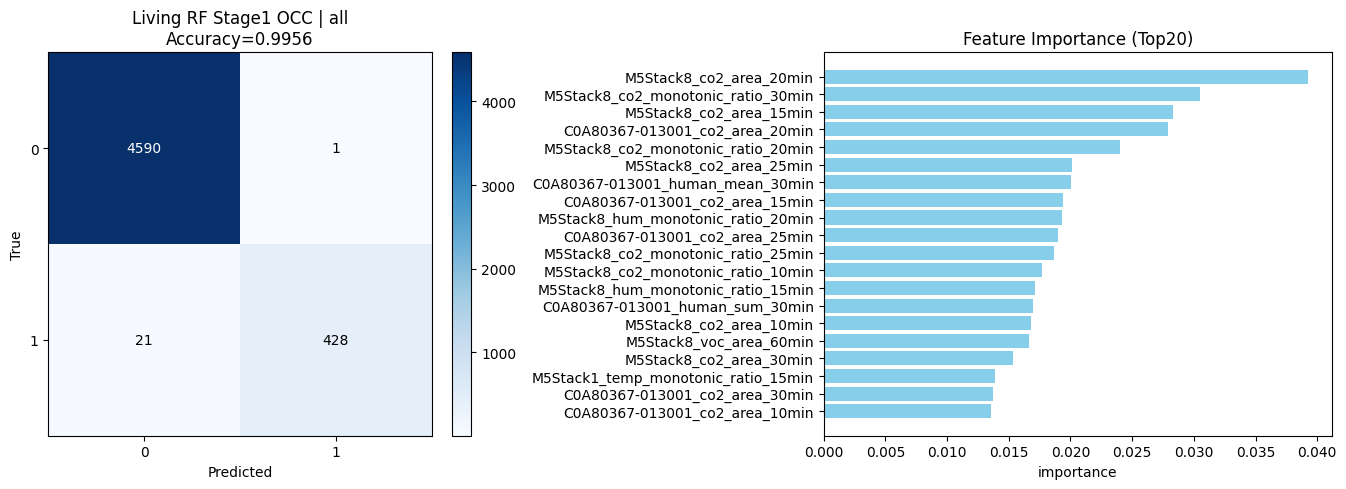


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.9265
[[236   6]
 [ 27 180]]


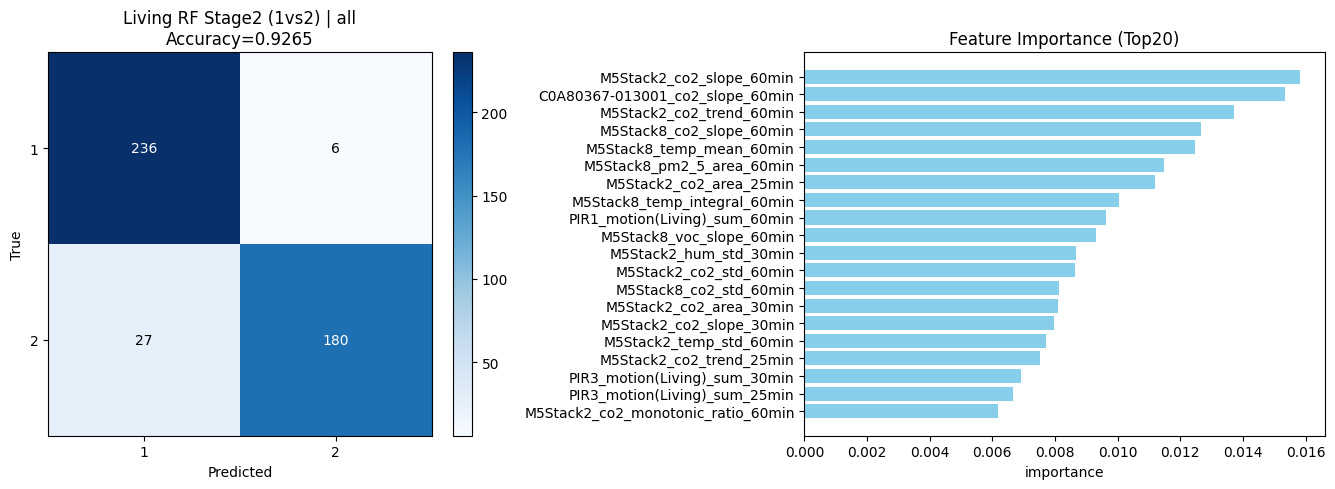


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9901
[[4590    0    1]
 [  21  220    1]
 [   0   27  180]]
              precision    recall  f1-score   support

           0      0.995     1.000     0.998      4591
           1      0.891     0.909     0.900       242
           2      0.989     0.870     0.925       207

    accuracy                          0.990      5040
   macro avg      0.958     0.926     0.941      5040
weighted avg      0.990     0.990     0.990      5040



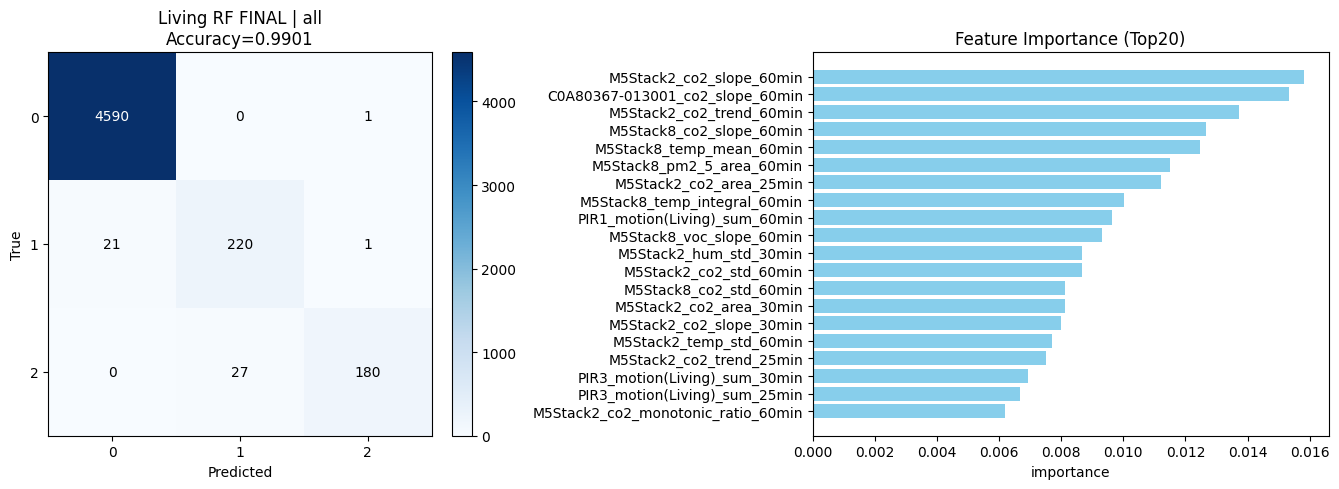


[Living][RF 2-stage] setting=appliance_only | features=1406 | train=20111 test=5040
label dist test: {0: 4591, 1: 242, 2: 207}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9954
[[4589    2]
 [  21  428]]


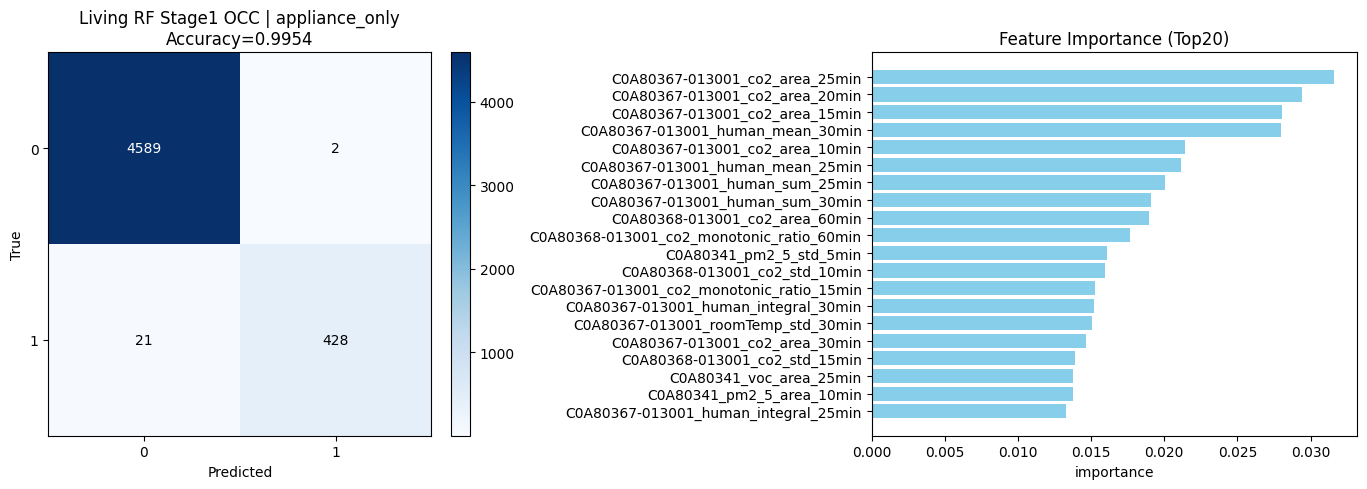


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.9176
[[225  17]
 [ 20 187]]


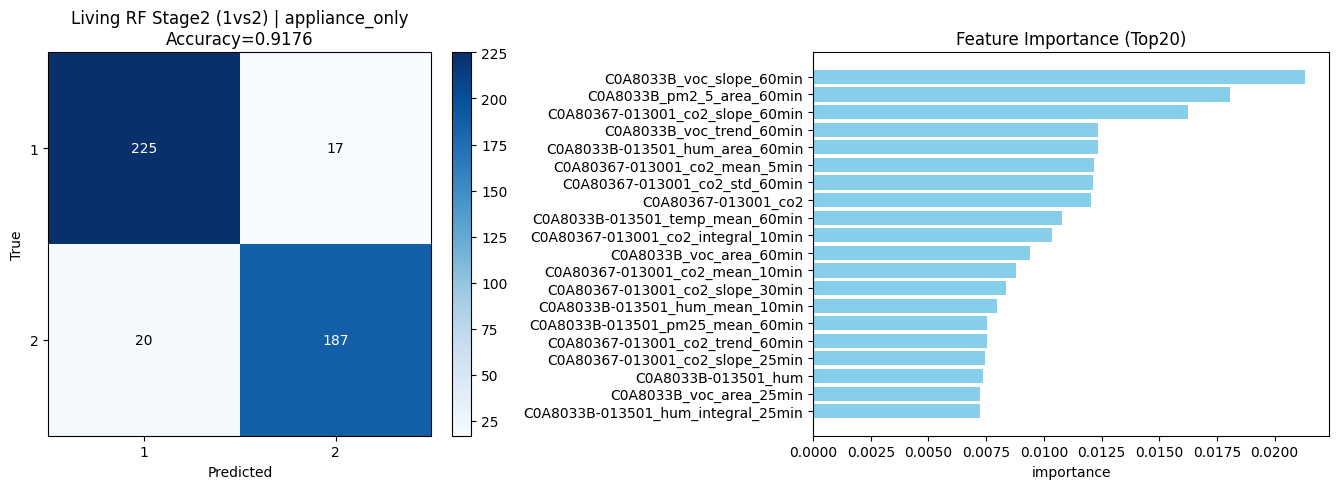


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9913
[[4589    0    2]
 [  21  220    1]
 [   0   20  187]]
              precision    recall  f1-score   support

           0      0.995     1.000     0.998      4591
           1      0.917     0.909     0.913       242
           2      0.984     0.903     0.942       207

    accuracy                          0.991      5040
   macro avg      0.965     0.937     0.951      5040
weighted avg      0.991     0.991     0.991      5040



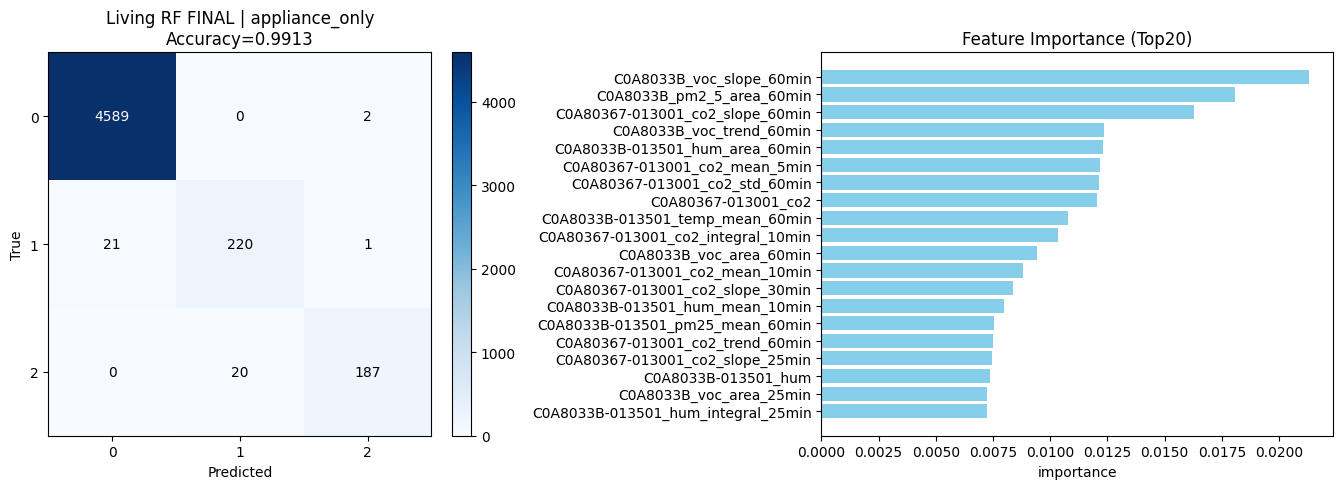


[Living][RF 2-stage] setting=no_co2_human | features=986 | train=20111 test=5040
label dist test: {0: 4591, 1: 242, 2: 207}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9948
[[4586    5]
 [  21  428]]


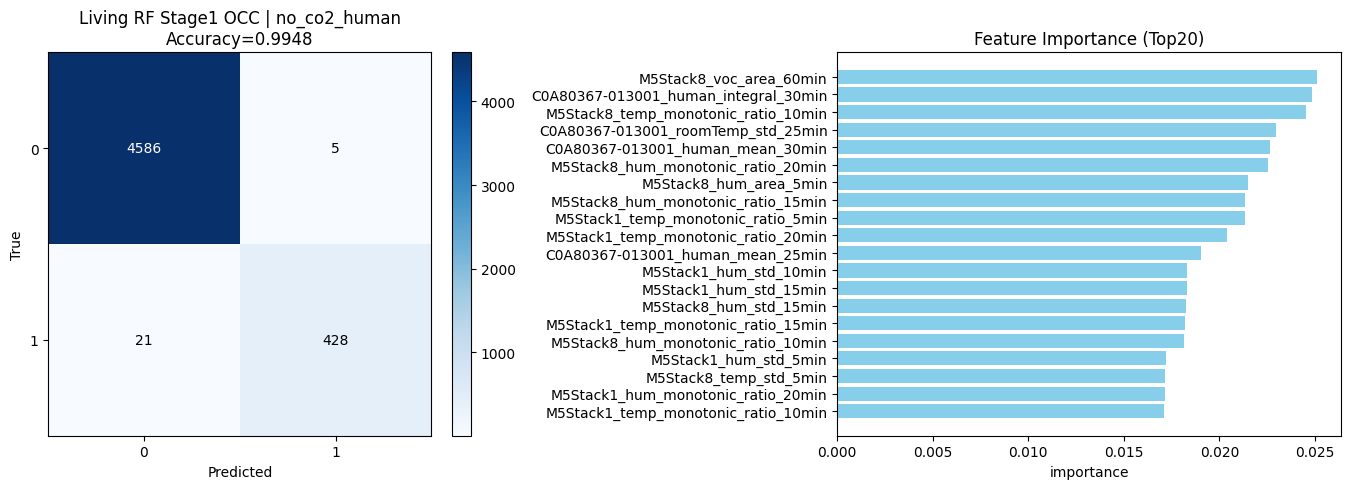


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.9443
[[240   2]
 [ 23 184]]


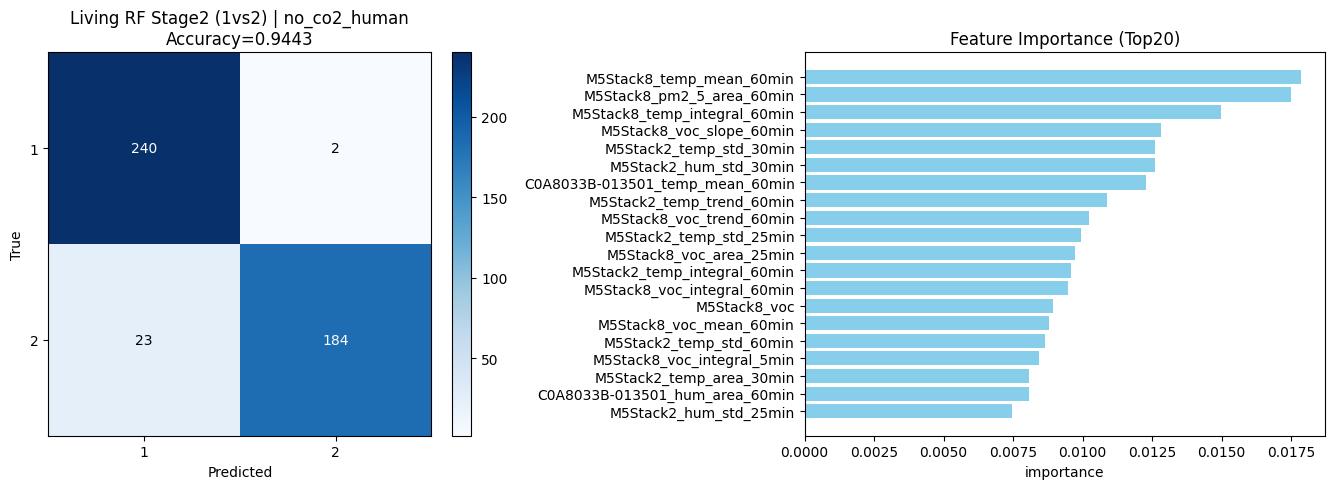


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9901
[[4586    0    5]
 [  21  220    1]
 [   0   23  184]]
              precision    recall  f1-score   support

           0      0.995     0.999     0.997      4591
           1      0.905     0.909     0.907       242
           2      0.968     0.889     0.927       207

    accuracy                          0.990      5040
   macro avg      0.956     0.932     0.944      5040
weighted avg      0.990     0.990     0.990      5040



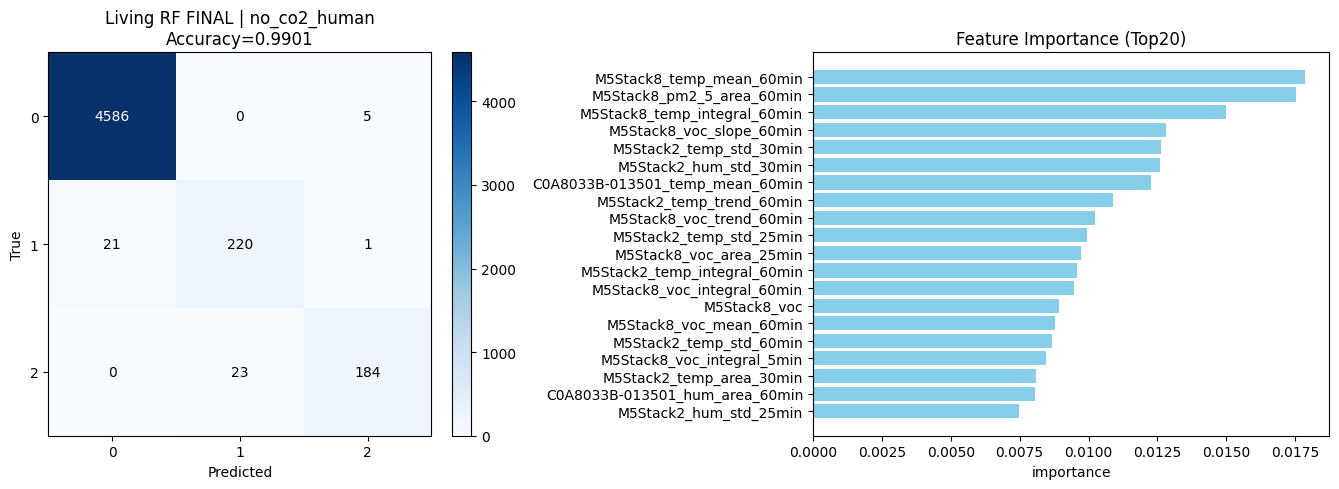


RUN: Japanese (LGBM 2-stage)

[Japanese][LGBM 2-stage] setting=all | features=1281 | train=20120 test=5031
label dist test: {0: 4685, 1: 221, 2: 125}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9980
[[4677    8]
 [   2  344]]


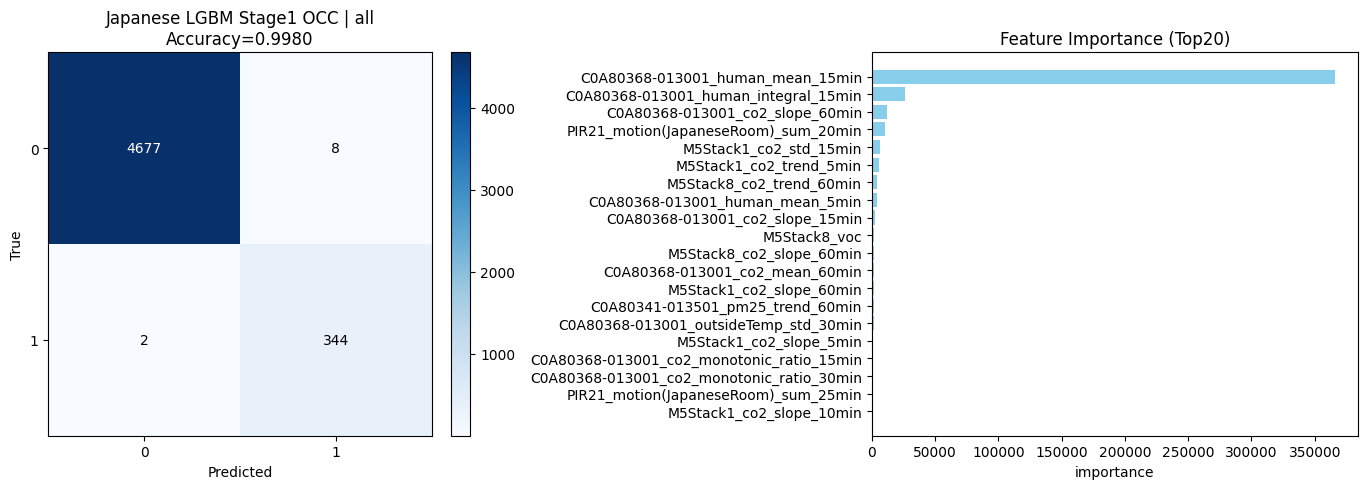


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.9653
[[210  11]
 [  1 124]]


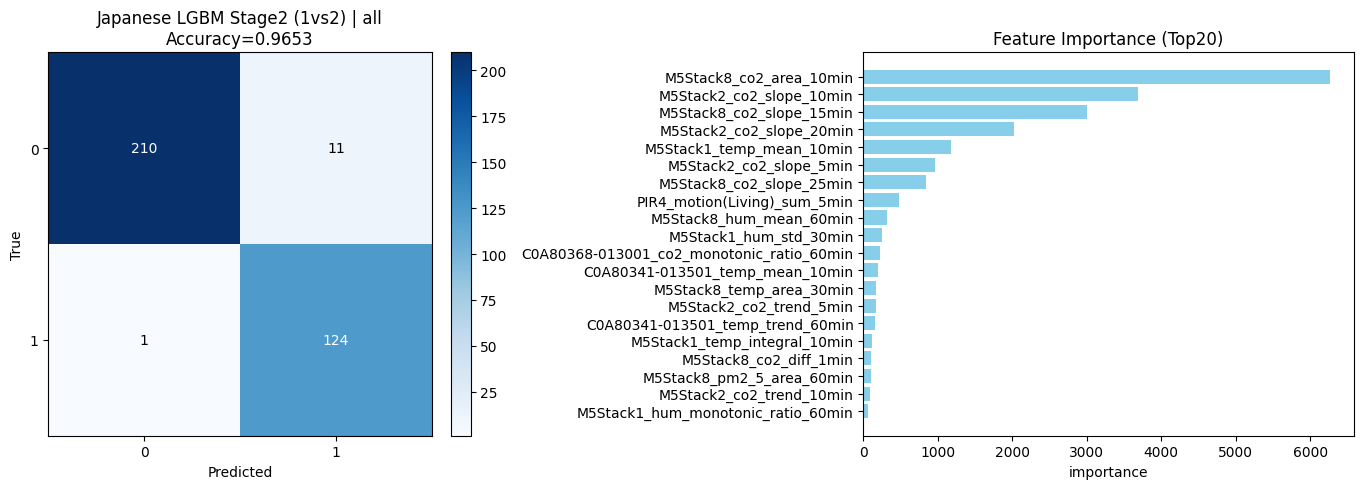


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9960
[[4677    8    0]
 [   2  210    9]
 [   0    1  124]]
              precision    recall  f1-score   support

           0      1.000     0.998     0.999      4685
           1      0.959     0.950     0.955       221
           2      0.932     0.992     0.961       125

    accuracy                          0.996      5031
   macro avg      0.964     0.980     0.972      5031
weighted avg      0.996     0.996     0.996      5031



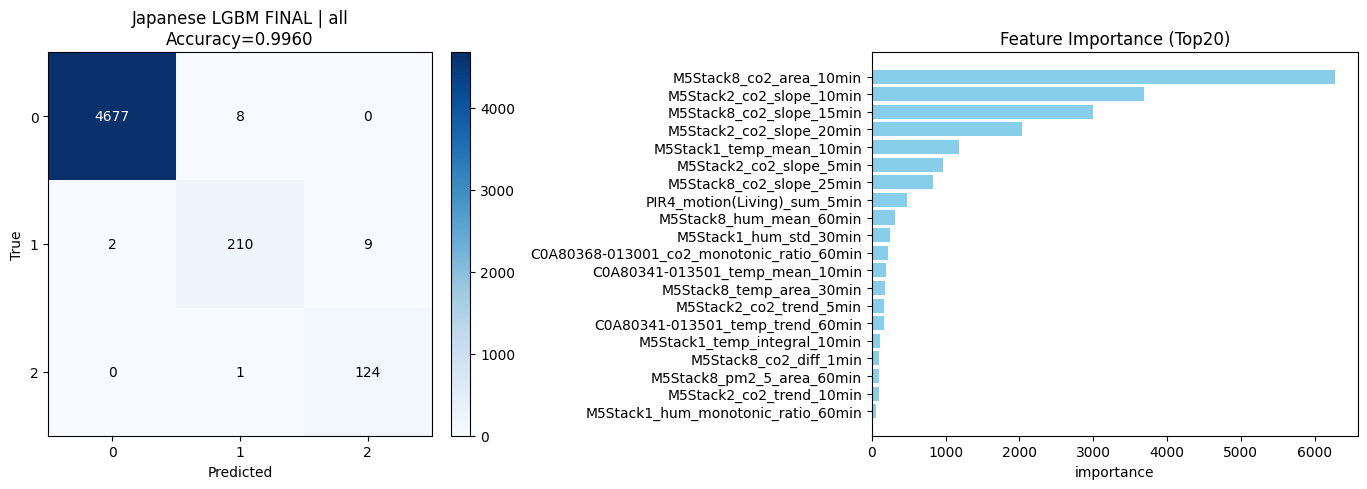


[Japanese][LGBM 2-stage] setting=appliance_only | features=1406 | train=20120 test=5031
label dist test: {0: 4685, 1: 221, 2: 125}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9984
[[4680    5]
 [   3  343]]


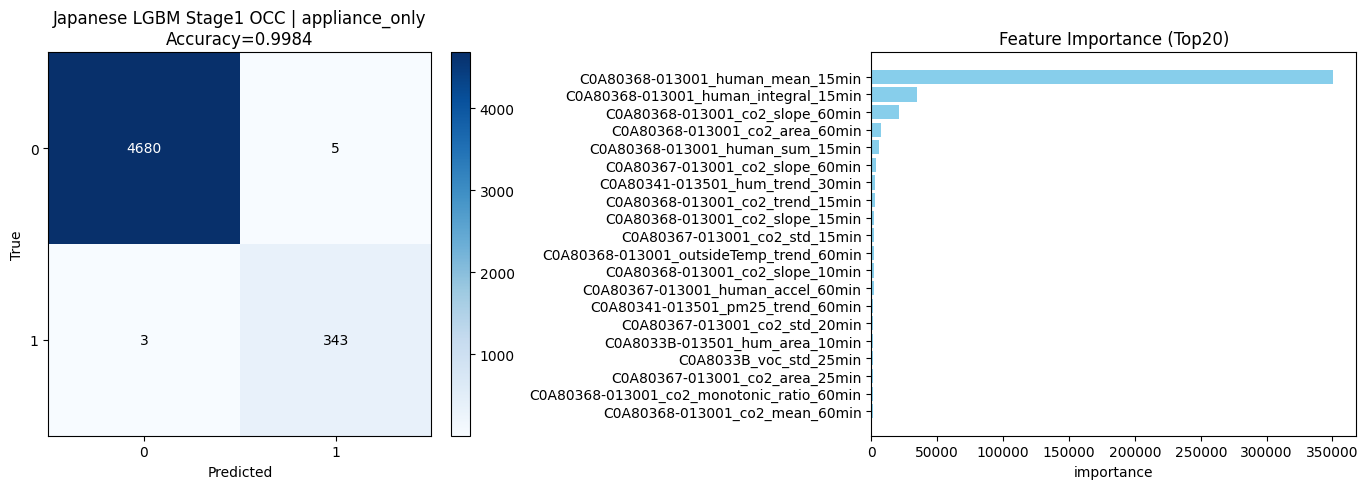


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.8931
[[185  36]
 [  1 124]]


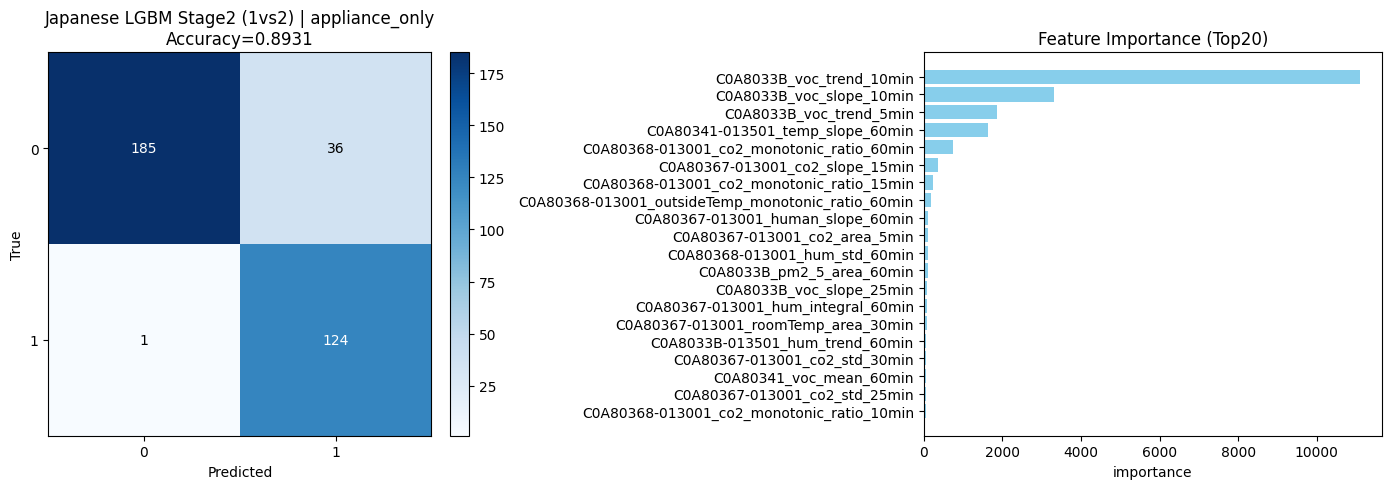


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9915
[[4680    2    3]
 [   3  184   34]
 [   0    1  124]]
              precision    recall  f1-score   support

           0      0.999     0.999     0.999      4685
           1      0.984     0.833     0.902       221
           2      0.770     0.992     0.867       125

    accuracy                          0.991      5031
   macro avg      0.918     0.941     0.923      5031
weighted avg      0.993     0.991     0.992      5031



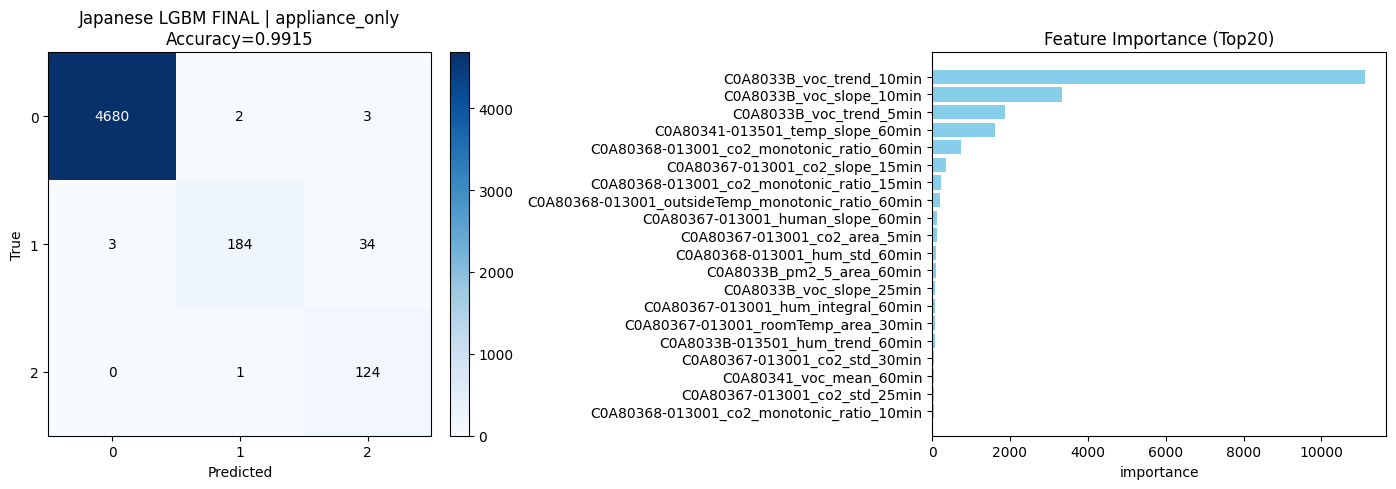


✅ Done.


In [1]:
# ============================================================
# Hybrid pipeline (0/1/2 people count) - Fixed & Optimized
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from lightgbm import LGBMClassifier

# =========================
# Config
# =========================
CSV_PATH = "smart_home_data0116.csv"  # アップロードされたファイル名に合わせました
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20

SEED = 42

# Living RF: block group split
BLOCK_MINUTES = 30
TEST_RATIO = 0.20

# If you still want CSV for importance (optional)
SAVE_IMPORTANCE_CSV = False

# Appliance prefixes
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")

# =========================
# Utilities
# =========================
def to_dt(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce") # infer_datetime_format is deprecated

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    dfr = dfr.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return dfr

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def uniq(xs):
    return list(dict.fromkeys(xs))

def is_pm25(name: str) -> bool:
    n = name.lower()
    return ("pm2_5" in n) or ("pm2.5" in n) or ("pm25" in n)

def is_co2(name: str) -> bool:
    n = name.lower()
    return n.endswith("_co2") or ("_co2_" in n)

def is_voc(name: str) -> bool:
    return "voc" in name.lower()

def is_temp_hum_like(name: str) -> bool:
    n = name.lower()
    return ("_temp" in n) or ("temp" in n) or ("_hum" in n) or ("humid" in n)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

def plot_cm_and_importance(title_prefix, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    top = imp.head(topk)[::-1]

    fig = plt.figure(figsize=(14, 5))

    # CM
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues") # Added cmap for better visibility
    ax1.set_title(f"{title_prefix}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color="black" if cm[i,j] < cm.max()/2 else "white")

    # Importance
    ax2 = plt.subplot(1, 2, 2)
    ax2.barh(top.index, top.values, color="skyblue")
    ax2.set_title(f"Feature Importance (Top{topk})")
    ax2.set_xlabel("importance")
    plt.tight_layout()
    plt.show()


# =========================
# Feature engineering (latest multi-window)
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3:
        return pd.Series(0.0, index=y.index)

    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)

    # Vectorized check to avoid division by zero if window is extremely small (unlikely here)
    if denom == 0: return pd.Series(0.0, index=y.index)

    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        return np.dot(t_centered, (a - a.mean())) / denom

    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def _monotonic_ratio(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    pos = (d > 0).astype(float)
    return pos.rolling(window, min_periods=1).mean().fillna(0.0)

def _area_from_baseline(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    base = y.rolling(window, min_periods=1).min()
    return (y - base).rolling(window, min_periods=1).sum().fillna(0.0)

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns:
            continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)

        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff_1min"] = d1

        for w in wins:
            feats[f"{c}_mean_{w}min"] = s.rolling(w, min_periods=1).mean().fillna(0.0)
            feats[f"{c}_std_{w}min"]  = s.rolling(w, min_periods=1).std().fillna(0.0)

            feats[f"{c}_slope_{w}min"] = ((s - s.shift(w)) / float(w)).fillna(0.0)
            feats[f"{c}_integral_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

            feats[f"{c}_trend_{w}min"] = _rolling_linreg_slope(s, w)
            feats[f"{c}_monotonic_ratio_{w}min"] = _monotonic_ratio(s, w)
            feats[f"{c}_area_{w}min"] = _area_from_baseline(s, w)

            feats[f"{c}_accel_{w}min"] = (d1 - d1.rolling(w, min_periods=1).mean()).fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns:
            continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X


# =========================
# Column packers (room-based)
# =========================
def pick_room_columns_latest(df: pd.DataFrame, room: str):
    """
    Return a pack of candidate columns for:
    - all: room appliances + (M5Stack1/2/8) + PIR/human
    - appliance_only: all appliance prefixes only (no PIR)
    - no_co2_human: remove CO2 + PIR/human from "all" (keep pm/voc/temp/hum)
    """
    if room == "Living":
        label = "Label_Living_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80367-013001_") or c.startswith("C0A8033B-013501_")]
    elif room == "Japanese":
        label = "Label_Japanese_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80368-013001_") or c.startswith("C0A80341-013501_")]
    else:
        raise ValueError("room must be Living or Japanese")

    # M5Stack subset (as in your previous code)
    m5_cols = [c for c in df.columns if (c.startswith("M5Stack1_") or c.startswith("M5Stack2_") or c.startswith("M5Stack8_"))]
    pir_cols = [c for c in df.columns if c.lower().startswith("pir")]

    candidate_num = appliance_cols + m5_cols

    co2_cols  = [c for c in candidate_num if is_co2(c)]
    pm25_cols = [c for c in candidate_num if is_pm25(c)]
    voc_cols  = [c for c in candidate_num if is_voc(c)]
    th_cols   = [c for c in candidate_num if is_temp_hum_like(c)]

    human_cols = [c for c in candidate_num if c.lower().endswith("_human")] + pir_cols

    appliance_only = [c for c in df.columns if c.startswith(APPLIANCE_PREFIXES)]
    app_co2  = [c for c in appliance_only if is_co2(c)]
    app_pm25 = [c for c in appliance_only if is_pm25(c)]
    app_voc  = [c for c in appliance_only if is_voc(c)]
    app_th   = [c for c in appliance_only if is_temp_hum_like(c)]
    app_human= [c for c in appliance_only if c.lower().endswith("_human")]

    return dict(
        label=label,
        # all
        co2_cols=uniq([c for c in co2_cols if c in df.columns]),
        pm25_cols=uniq([c for c in pm25_cols if c in df.columns]),
        voc_cols=uniq([c for c in voc_cols if c in df.columns]),
        th_cols=uniq([c for c in th_cols if c in df.columns]),
        human_cols=uniq([c for c in human_cols if c in df.columns]),
        # appliance only
        app_co2=uniq([c for c in app_co2 if c in df.columns]),
        app_pm25=uniq([c for c in app_pm25 if c in df.columns]),
        app_voc=uniq([c for c in app_voc if c in df.columns]),
        app_th=uniq([c for c in app_th if c in df.columns]),
        app_human=uniq([c for c in app_human if c in df.columns]),
    )


# =========================
# Japanese: LightGBM 2-stage
# =========================
def lgbm_model_multiclass(num_class=3):
    return LGBMClassifier(
        objective="multiclass",
        num_class=num_class,
        n_estimators=1500,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        verbose=-1,
        class_weight="balanced",
    )

def lgbm_model_binary():
    return LGBMClassifier(
        objective="binary",
        n_estimators=1200,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        verbose=-1,
        class_weight="balanced",
    )

def run_japanese_lgbm_2stage(df: pd.DataFrame, setting: str):
    room = "Japanese"
    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {room}: {label_col} not found")
        return

    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin([0, 1, 2]), np.nan).ffill().fillna(0).astype(int)
    y_occ = (y > 0).astype(int)

    # settings for Japanese: all / appliance_only (as you requested)
    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]
    else:
        raise ValueError("Japanese LGBM setting must be all or appliance_only")

    num_cols = uniq([c for c in num_cols if c in df.columns])
    hum_cols = uniq([c for c in hum_cols if c in df.columns])

    X_num = build_numeric_features_multiwin(df, num_cols, WINS) if len(num_cols) else pd.DataFrame(index=df.index)
    X_hum = build_human_features(df, hum_cols, WINS) if len(hum_cols) else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_hum], axis=1).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]

    # time split (as in your LGBM reference)
    n = len(df)
    n_tr = int(n * 0.80)
    tr_idx = np.arange(0, n_tr)
    te_idx = np.arange(n_tr, n)

    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
    y_occ_tr, y_occ_te = y_occ.iloc[tr_idx], y_occ.iloc[te_idx]

    print("\n" + "=" * 92)
    print(f"[Japanese][LGBM 2-stage] setting={setting} | features={X.shape[1]} | train={len(tr_idx)} test={len(te_idx)}")
    print(f"label dist test: {y_te.value_counts().to_dict()}")
    print("=" * 92)

    # --- Stage1: occupancy 0 vs >0
    occ_model = lgbm_model_binary()
    occ_model.fit(X_tr, y_occ_tr)
    pred_occ = occ_model.predict(X_te)

    print("\n--- Stage1: Occupancy (0 vs >0) ---")
    print(f"Accuracy: {accuracy_score(y_occ_te, pred_occ):.4f}")
    print(confusion_matrix(y_occ_te, pred_occ, labels=[0, 1]))
    # importance (gain)
    occ_gain = occ_model.booster_.feature_importance(importance_type="gain")
    plot_cm_and_importance(
        title_prefix=f"Japanese LGBM Stage1 OCC | {setting}",
        y_true=y_occ_te, y_pred=pred_occ,
        labels=[0, 1],
        feature_names=X.columns.tolist(),
        importances=occ_gain,
        topk=TOPK_IMPORTANCE
    )

    # --- Stage2: count 1 vs 2 (only occupied true labels in train; in test evaluate only true occupied)
    tr_mask_12 = y_tr.isin([1, 2])
    te_mask_12 = y_te.isin([1, 2])

    X_tr_12 = X_tr.loc[tr_mask_12]
    y_tr_12 = y_tr.loc[tr_mask_12]
    X_te_12 = X_te.loc[te_mask_12]
    y_te_12 = y_te.loc[te_mask_12]

    if len(X_tr_12) == 0 or len(X_te_12) == 0 or len(np.unique(y_tr_12)) < 2:
        print("[WARN] Stage2 (1vs2) insufficient data, skip.")
        return

    # train only with labels 1/2 (LightGBM multiclass expects 0..K-1; easiest: map 1->0, 2->1 for Stage2)
    y_tr_map = y_tr_12.map({1: 0, 2: 1}).astype(int)
    y_te_map = y_te_12.map({1: 0, 2: 1}).astype(int)

    cnt_model = LGBMClassifier(
        objective="multiclass",
        num_class=2,
        n_estimators=1500,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        verbose=-1,
        class_weight="balanced",
    )
    cnt_model.fit(X_tr_12, y_tr_map)
    pred_12 = cnt_model.predict(X_te_12)

    print("\n--- Stage2: Count (1 vs 2) on occupied-only ---")
    print(f"Accuracy: {accuracy_score(y_te_map, pred_12):.4f}")
    print(confusion_matrix(y_te_map, pred_12, labels=[0, 1]))
    cnt_gain = cnt_model.booster_.feature_importance(importance_type="gain")
    plot_cm_and_importance(
        title_prefix=f"Japanese LGBM Stage2 (1vs2) | {setting}",
        y_true=y_te_map, y_pred=pred_12,
        labels=[0, 1],  # mapped labels
        feature_names=X.columns.tolist(),
        importances=cnt_gain,
        topk=TOPK_IMPORTANCE
    )

    # --- Final: build 0/1/2 using predicted occupancy mask (as you did)
    final_pred = np.zeros(len(X_te), dtype=int)  # 0 by default
    pred_occ_mask = (pred_occ == 1)
    if pred_occ_mask.any():
        pred_12_all = cnt_model.predict(X_te.loc[pred_occ_mask])
        # map back 0->1, 1->2
        final_pred[pred_occ_mask] = pd.Series(pred_12_all).map({0: 1, 1: 2}).values

    print("\n--- FINAL (0/1/2 by 2-stage) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred):.4f}")
    print(confusion_matrix(y_te, final_pred, labels=[0, 1, 2]))
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    # final plot: CM + Stage2 importance (most interpretable for 1vs2)
    plot_cm_and_importance(
        title_prefix=f"Japanese LGBM FINAL | {setting}",
        y_true=y_te, y_pred=final_pred,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=cnt_gain,  # show Stage2 gain for interpretation
        topk=TOPK_IMPORTANCE
    )

    if SAVE_IMPORTANCE_CSV:
        pd.Series(occ_gain, index=X.columns).sort_values(ascending=False).reset_index().rename(
            columns={"index": "feature", 0: "gain"}
        ).to_csv(f"japanese_lgbm_{setting}_occ_importance.csv", index=False)
        pd.Series(cnt_gain, index=X.columns).sort_values(ascending=False).reset_index().rename(
            columns={"index": "feature", 0: "gain"}
        ).to_csv(f"japanese_lgbm_{setting}_cnt12_importance.csv", index=False)


# =========================
# Living: RandomForest 2-stage (GroupShuffleSplit blocks)
# =========================
def rf_occ_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

def rf_cnt_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

def run_living_rf_2stage(df: pd.DataFrame, setting: str):
    room = "Living"
    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {room}: {label_col} not found")
        return

    # y: only 0/1/2
    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin([0, 1, 2]), np.nan).ffill().fillna(0).astype(int)

    # feature set by setting
    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]  # no PIR
    elif setting == "no_co2_human":
        num_cols = pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = []
    else:
        raise ValueError("Living RF setting must be all / appliance_only / no_co2_human")

    num_cols = uniq([c for c in num_cols if c in df.columns])
    hum_cols = uniq([c for c in hum_cols if c in df.columns])

    X_num = build_numeric_features_multiwin(df, num_cols, WINS) if len(num_cols) else pd.DataFrame(index=df.index)
    X_hum = build_human_features(df, hum_cols, WINS) if len(hum_cols) else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_hum], axis=1).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]

    # group split (30min blocks)
    ts = pd.Series(df.index)
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Living RF expects df indexed by timestamp (DatetimeIndex).")

    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr = X.iloc[tr_idx].to_numpy(dtype=np.float32)
    y_tr = y.iloc[tr_idx].to_numpy(dtype=int)
    X_te = X.iloc[te_idx].to_numpy(dtype=np.float32)
    y_te = y.iloc[te_idx].to_numpy(dtype=int)

    X_tr[~np.isfinite(X_tr)] = 0.0
    X_te[~np.isfinite(X_te)] = 0.0

    print("\n" + "=" * 92)
    print(f"[Living][RF 2-stage] setting={setting} | features={X.shape[1]} | train={len(tr_idx)} test={len(te_idx)}")
    print(f"label dist test: {pd.Series(y_te).value_counts().to_dict()}")
    print("=" * 92)

    # --- Stage1: occupancy
    y_tr_occ = (y_tr > 0).astype(int)
    y_te_occ = (y_te > 0).astype(int)

    occ_model = rf_occ_model()
    occ_model.fit(X_tr, y_tr_occ)
    pred_occ = occ_model.predict(X_te)

    print("\n--- Stage1: Occupancy (0 vs >0) ---")
    print(f"Accuracy: {accuracy_score(y_te_occ, pred_occ):.4f}")
    print(confusion_matrix(y_te_occ, pred_occ, labels=[0, 1]))
    plot_cm_and_importance(
        title_prefix=f"Living RF Stage1 OCC | {setting}",
        y_true=y_te_occ, y_pred=pred_occ,
        labels=[0, 1],
        feature_names=X.columns.tolist(),
        importances=occ_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

    # --- Stage2: 1 vs 2 (train on true occupied only)
    tr_mask = (y_tr > 0)
    te_mask = (y_te > 0)

    X_tr_in = X_tr[tr_mask]
    y_tr_in = y_tr[tr_mask]  # 1/2
    X_te_in = X_te[te_mask]
    y_te_in = y_te[te_mask]  # 1/2

    if len(np.unique(y_tr_in)) < 2 or len(y_te_in) == 0:
        print("[WARN] Stage2 (1vs2) insufficient data, skip.")
        return

    cnt_model = rf_cnt_model()
    cnt_model.fit(X_tr_in, y_tr_in)
    pred_in = cnt_model.predict(X_te_in)

    print("\n--- Stage2: Count (1 vs 2) on occupied-only ---")
    print(f"Accuracy: {accuracy_score(y_te_in, pred_in):.4f}")
    print(confusion_matrix(y_te_in, pred_in, labels=[1, 2]))
    plot_cm_and_importance(
        title_prefix=f"Living RF Stage2 (1vs2) | {setting}",
        y_true=y_te_in, y_pred=pred_in,
        labels=[1, 2],
        feature_names=X.columns.tolist(),
        importances=cnt_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

    # --- Final: using predicted occupancy mask
    final_pred = np.zeros_like(y_te)
    pred_occ_mask = (pred_occ == 1)
    if pred_occ_mask.sum() > 0:
        final_pred[pred_occ_mask] = cnt_model.predict(X_te[pred_occ_mask])

    print("\n--- FINAL (0/1/2 by 2-stage) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred):.4f}")
    print(confusion_matrix(y_te, final_pred, labels=[0, 1, 2]))
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    # final plot: CM + Stage2 importance (most relevant to 1vs2 discrimination)
    plot_cm_and_importance(
        title_prefix=f"Living RF FINAL | {setting}",
        y_true=y_te, y_pred=final_pred,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=cnt_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

    if SAVE_IMPORTANCE_CSV:
        pd.Series(occ_model.feature_importances_, index=X.columns).sort_values(ascending=False).reset_index().rename(
            columns={"index": "feature", 0: "gini"}
        ).to_csv(f"living_rf_{setting}_occ_importance.csv", index=False)
        pd.Series(cnt_model.feature_importances_, index=X.columns).sort_values(ascending=False).reset_index().rename(
            columns={"index": "feature", 0: "gini"}
        ).to_csv(f"living_rf_{setting}_cnt12_importance.csv", index=False)


# =========================
# Main
# =========================
print("📥 Loading CSV...")
try:
    df0 = pd.read_csv(CSV_PATH, low_memory=False)
except UnicodeDecodeError:
    print("Warning: Standard encoding failed. Trying 'cp932'.")
    df0 = pd.read_csv(CSV_PATH, low_memory=False, encoding='cp932')

if TIME_COL not in df0.columns:
    raise ValueError(f"CSVに {TIME_COL} 列がありません。")

df0[TIME_COL] = to_dt(df0[TIME_COL])
df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)

# forward-only preprocessing
df0 = safe_ffill(df0).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

# resample to 1min
print("Resampling to 1min...")
df = resample_1min(df0, RESAMPLE_RULE)

# ---- Living: RF (try all 3; you can keep only the best one) ----
print("\n============================")
print("RUN: Living (RF 2-stage)")
print("============================")
for setting in ["all", "appliance_only", "no_co2_human"]:
    run_living_rf_2stage(df, setting)

# ---- Japanese: LGBM (all + appliance_only) ----
print("\n============================")
print("RUN: Japanese (LGBM 2-stage)")
print("============================")
for setting in ["all", "appliance_only"]:
    run_japanese_lgbm_2stage(df, setting)

print("\n✅ Done.")

📥 Loading CSV...
Resampling to 1min...

RUN: Living (RF 2-stage) - Weighted

[Living][RF 2-stage] setting=all | features=1281 | train=17591 test=7560
label dist test: {0: 6901, 2: 339, 1: 320}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9934
[[6874   27]
 [  23  636]]


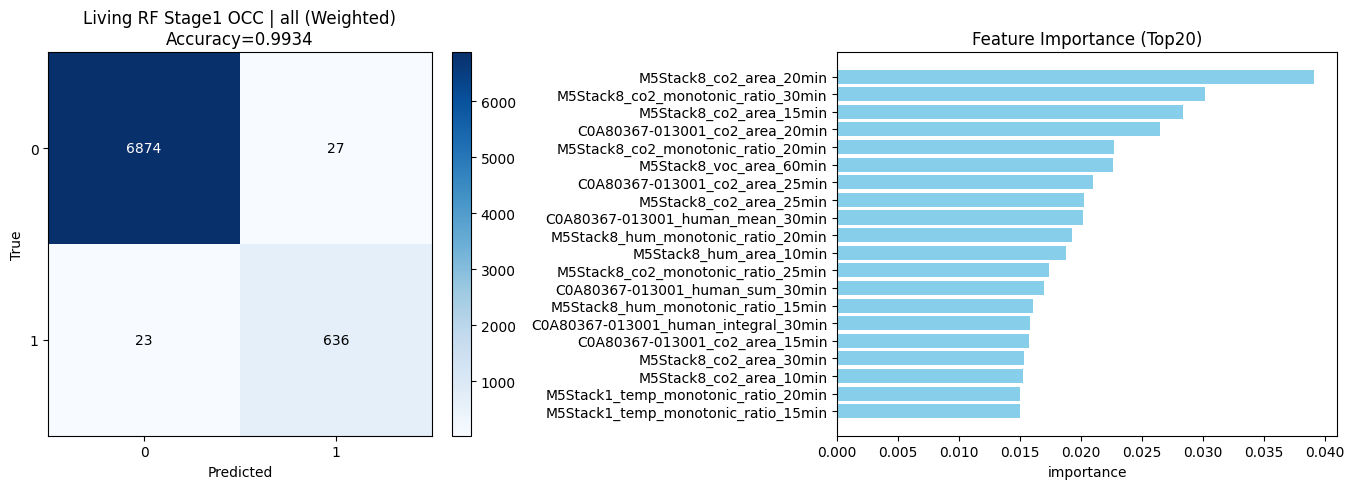


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.8619
[[281  39]
 [ 52 287]]


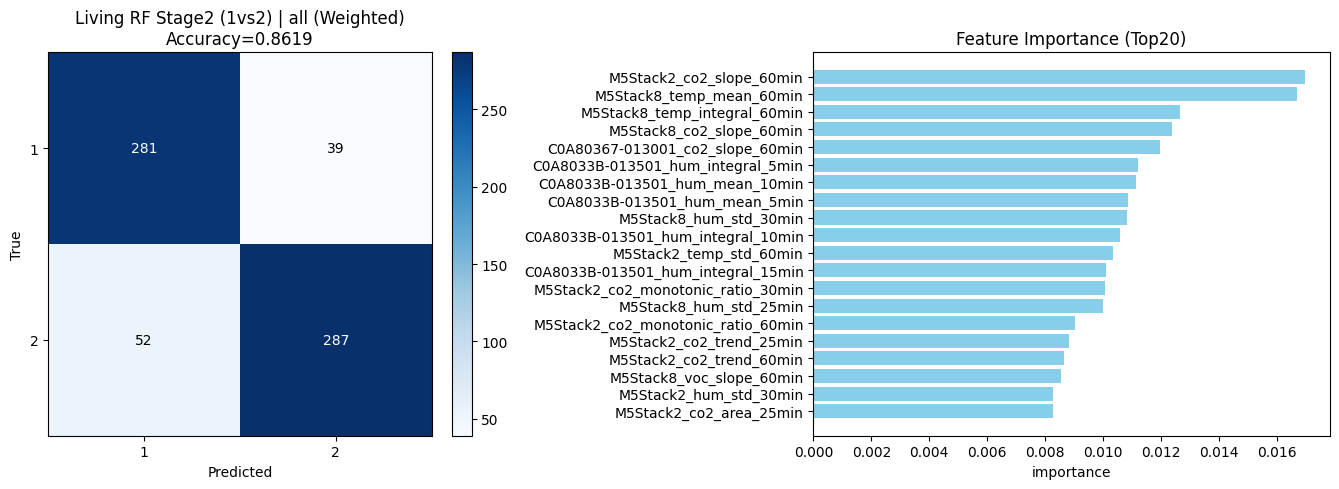


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9829
[[6874    4   23]
 [  23  270   27]
 [   0   52  287]]
              precision    recall  f1-score   support

           0      0.997     0.996     0.996      6901
           1      0.828     0.844     0.836       320
           2      0.852     0.847     0.849       339

    accuracy                          0.983      7560
   macro avg      0.892     0.895     0.894      7560
weighted avg      0.983     0.983     0.983      7560



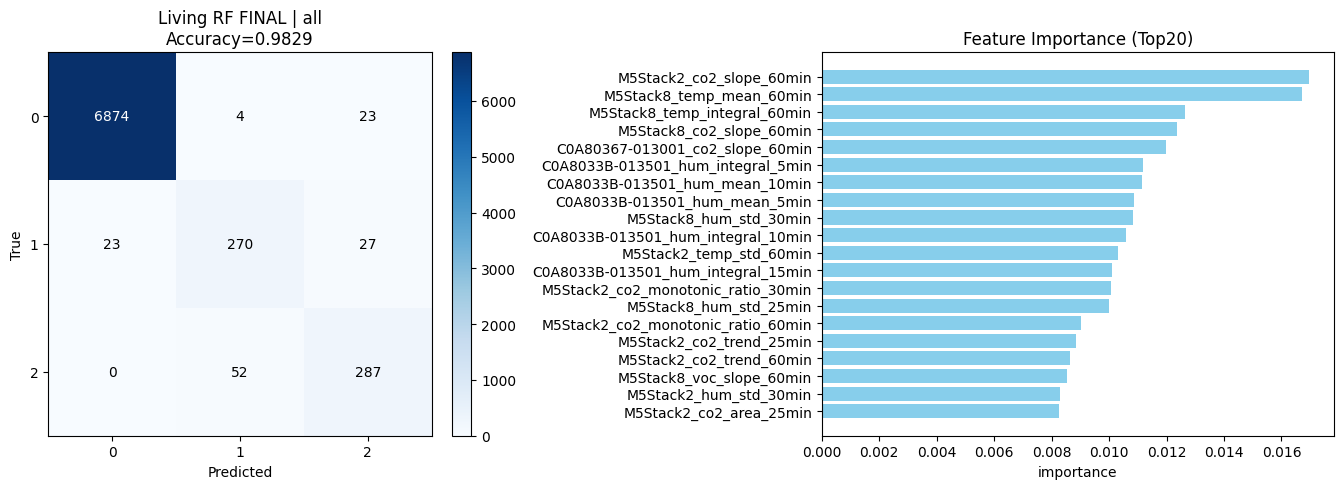


[Living][RF 2-stage] setting=appliance_only | features=1406 | train=17591 test=7560
label dist test: {0: 6901, 2: 339, 1: 320}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9933
[[6876   25]
 [  26  633]]


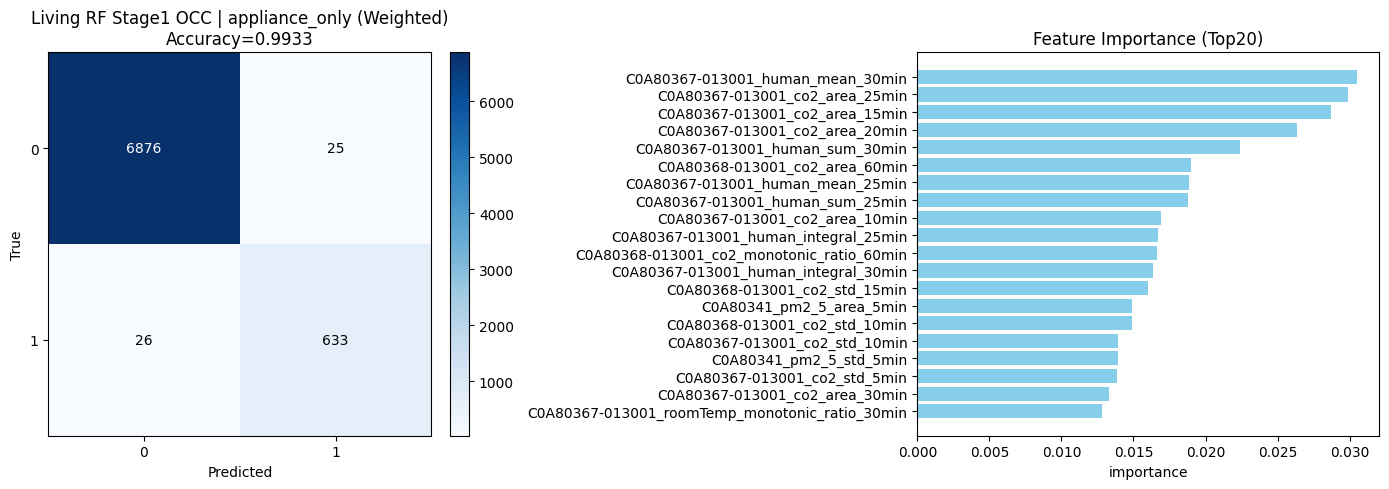


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.8619
[[283  37]
 [ 54 285]]


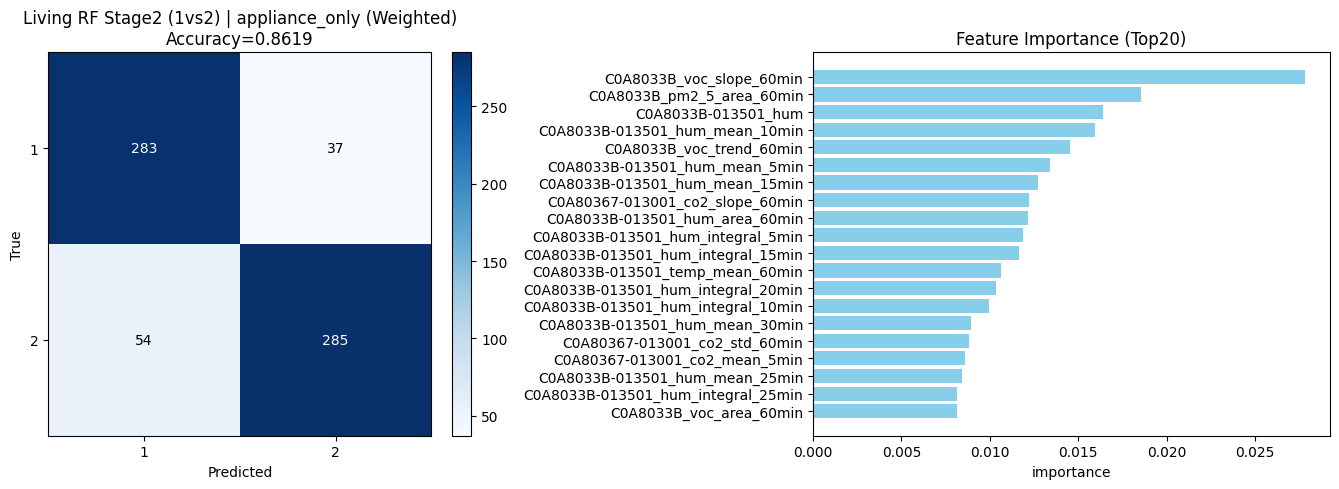


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9841
[[6876    6   19]
 [  24  280   16]
 [   2   53  284]]
              precision    recall  f1-score   support

           0      0.996     0.996     0.996      6901
           1      0.826     0.875     0.850       320
           2      0.890     0.838     0.863       339

    accuracy                          0.984      7560
   macro avg      0.904     0.903     0.903      7560
weighted avg      0.984     0.984     0.984      7560



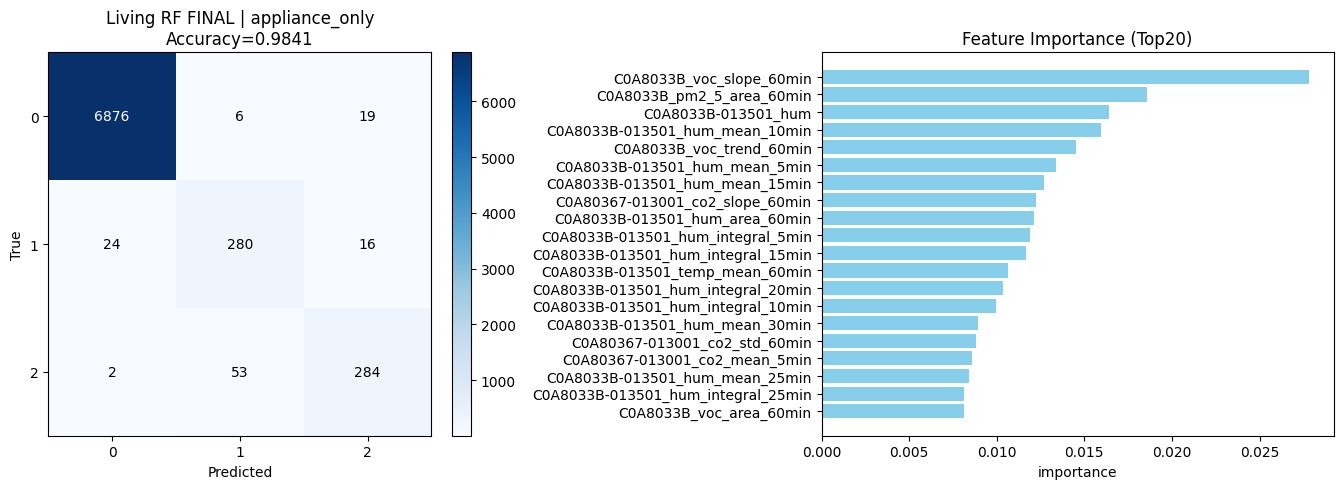


[Living][RF 2-stage] setting=no_co2_human | features=986 | train=17591 test=7560
label dist test: {0: 6901, 2: 339, 1: 320}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9933
[[6889   12]
 [  39  620]]


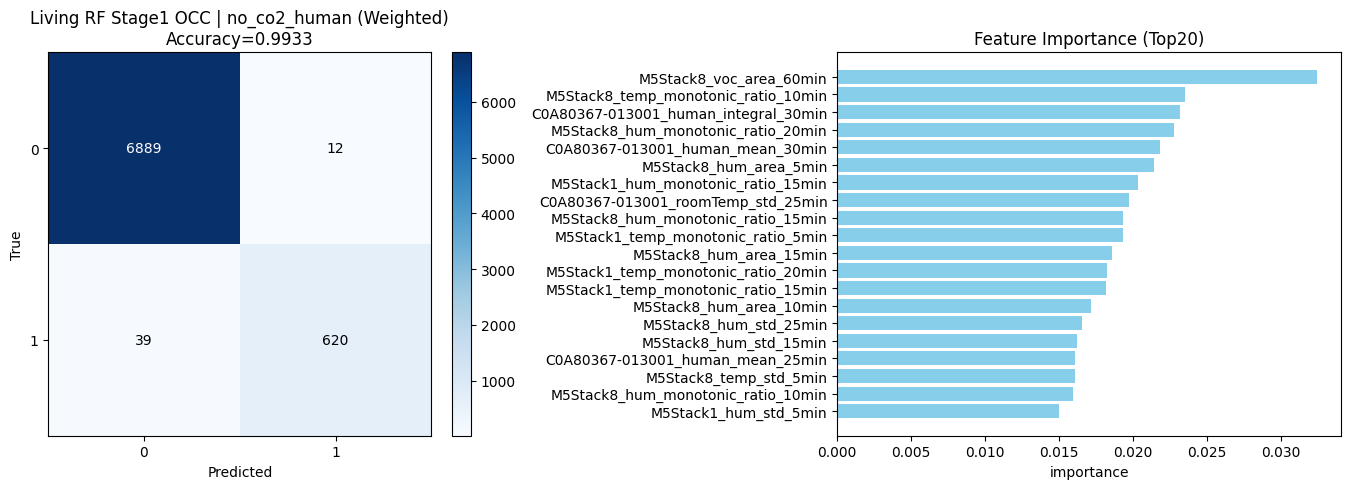


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.8407
[[283  37]
 [ 68 271]]


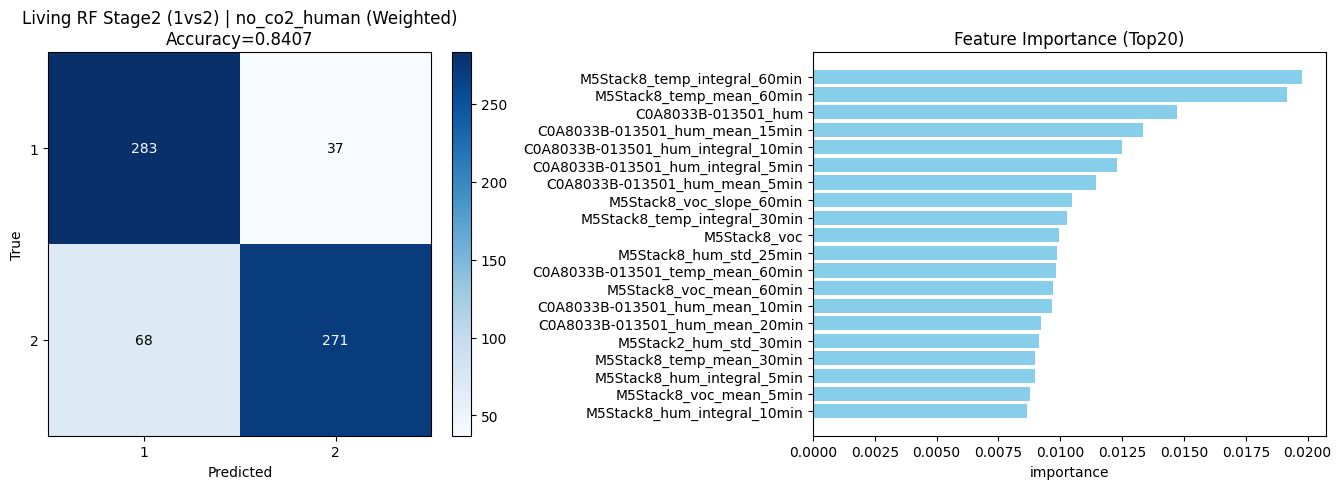


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9824
[[6889    0   12]
 [  39  267   14]
 [   0   68  271]]
              precision    recall  f1-score   support

           0      0.994     0.998     0.996      6901
           1      0.797     0.834     0.815       320
           2      0.912     0.799     0.852       339

    accuracy                          0.982      7560
   macro avg      0.901     0.877     0.888      7560
weighted avg      0.982     0.982     0.982      7560



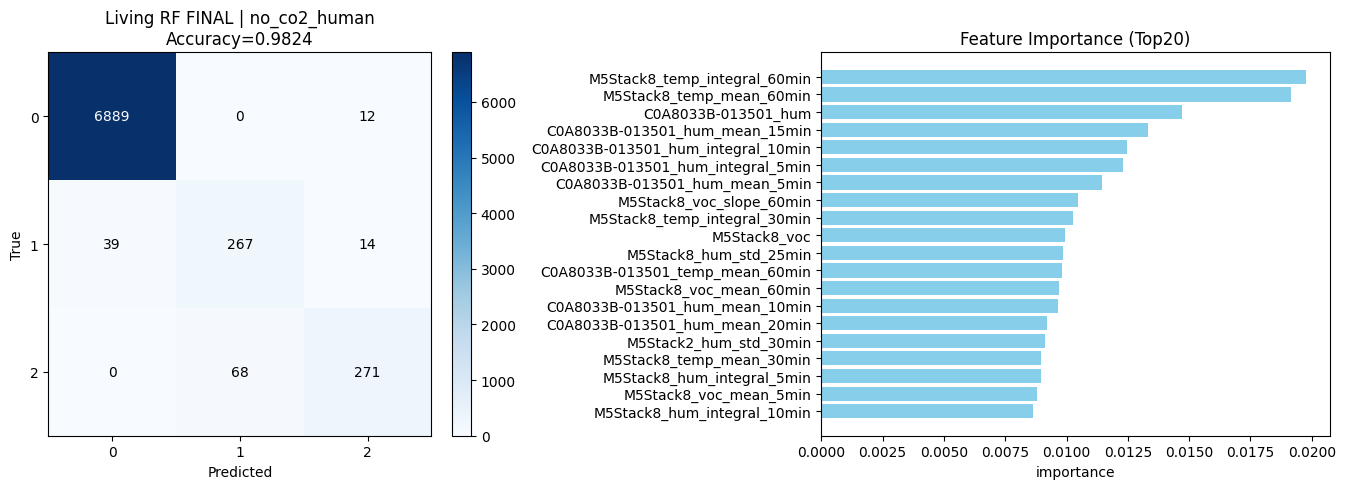


RUN: Japanese (LGBM 2-stage) - Weighted

[Japanese][LGBM 2-stage] setting=all | features=1281 | train=20120 test=5031
label dist test: {0: 4685, 1: 221, 2: 125}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9980
[[4677    8]
 [   2  344]]


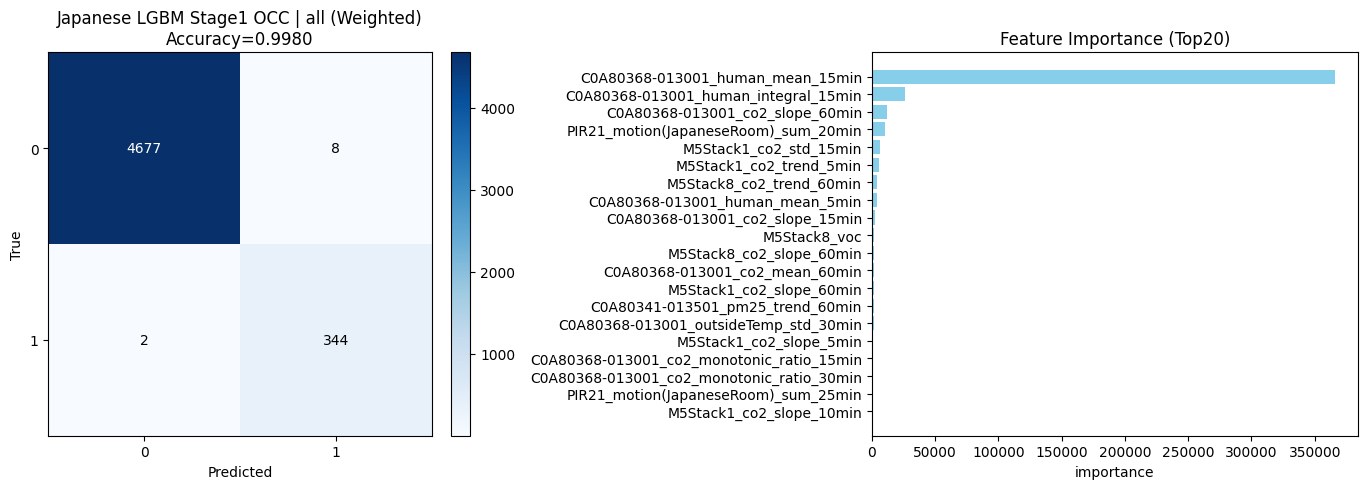


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.9653
[[210  11]
 [  1 124]]


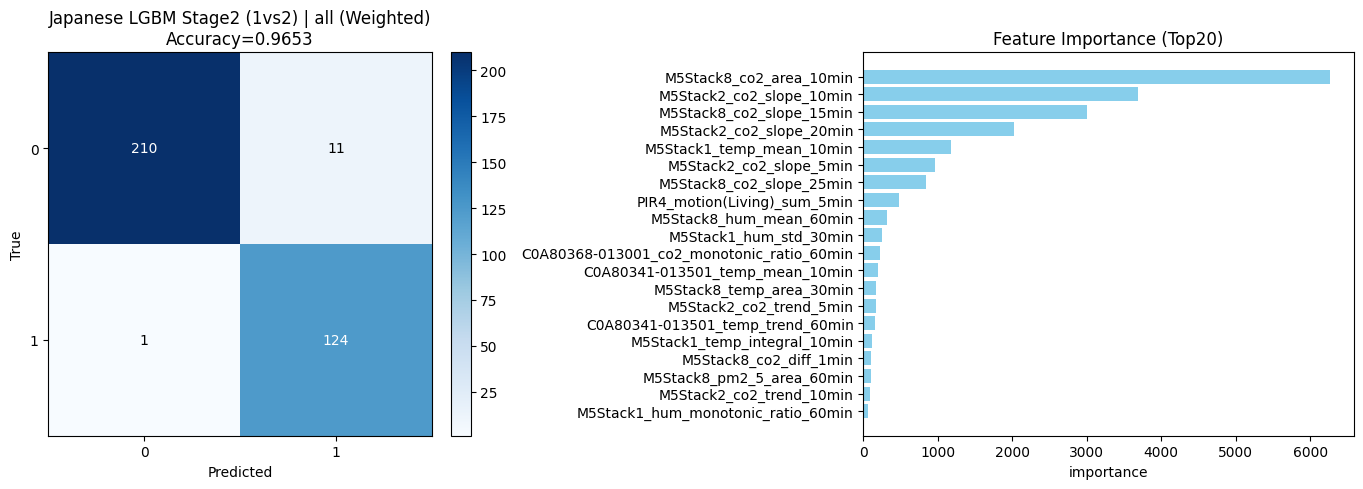


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9960
[[4677    8    0]
 [   2  210    9]
 [   0    1  124]]
              precision    recall  f1-score   support

           0      1.000     0.998     0.999      4685
           1      0.959     0.950     0.955       221
           2      0.932     0.992     0.961       125

    accuracy                          0.996      5031
   macro avg      0.964     0.980     0.972      5031
weighted avg      0.996     0.996     0.996      5031



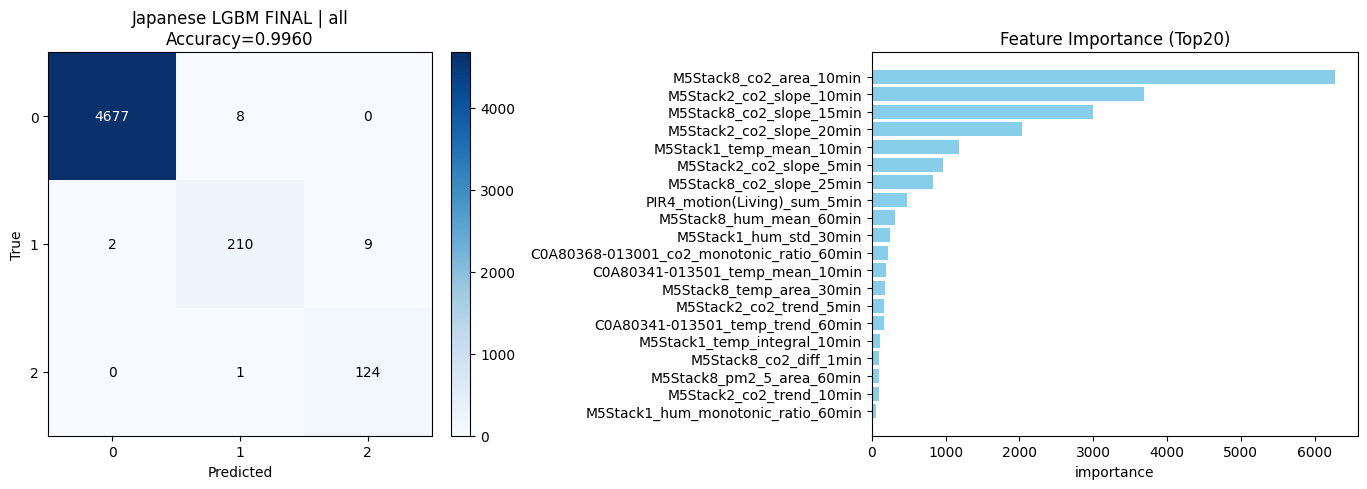


[Japanese][LGBM 2-stage] setting=appliance_only | features=1406 | train=20120 test=5031
label dist test: {0: 4685, 1: 221, 2: 125}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9984
[[4680    5]
 [   3  343]]


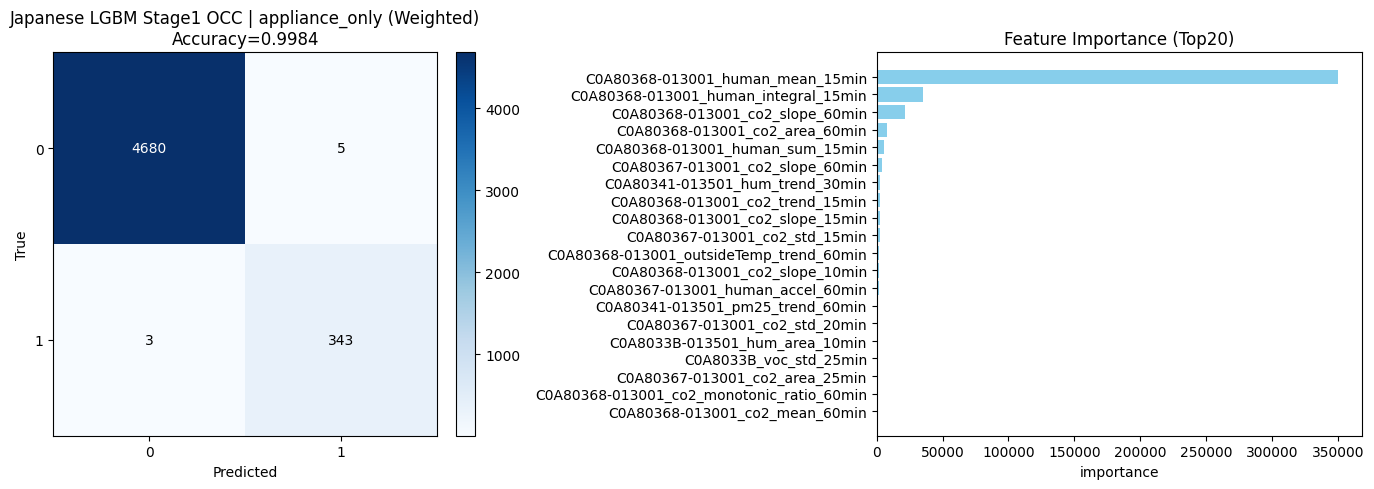


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.8931
[[185  36]
 [  1 124]]


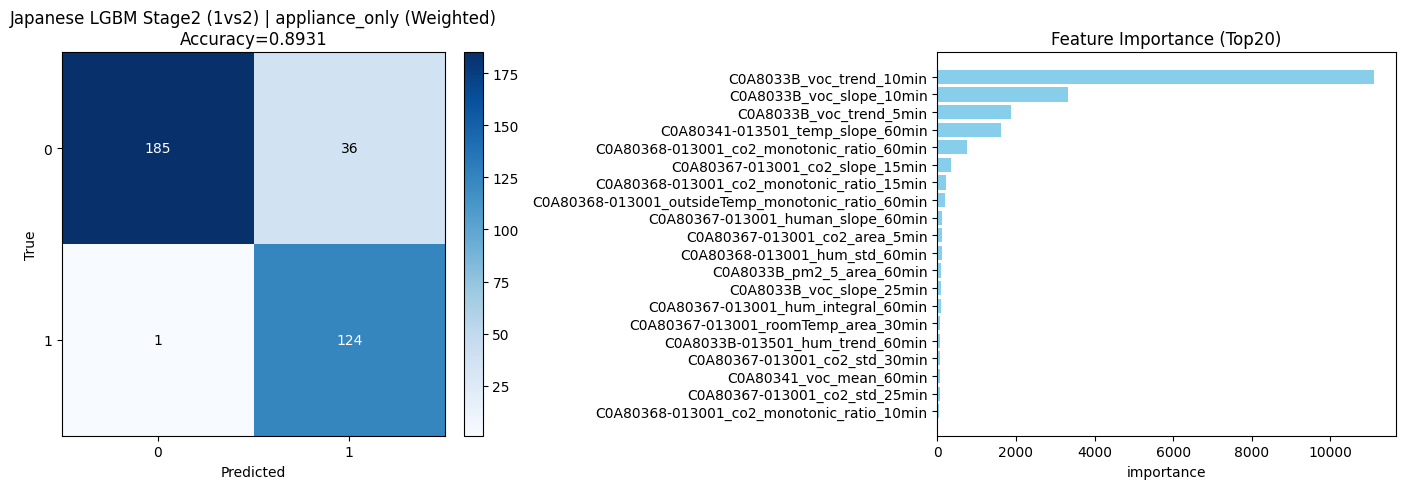


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9915
[[4680    2    3]
 [   3  184   34]
 [   0    1  124]]
              precision    recall  f1-score   support

           0      0.999     0.999     0.999      4685
           1      0.984     0.833     0.902       221
           2      0.770     0.992     0.867       125

    accuracy                          0.991      5031
   macro avg      0.918     0.941     0.923      5031
weighted avg      0.993     0.991     0.992      5031



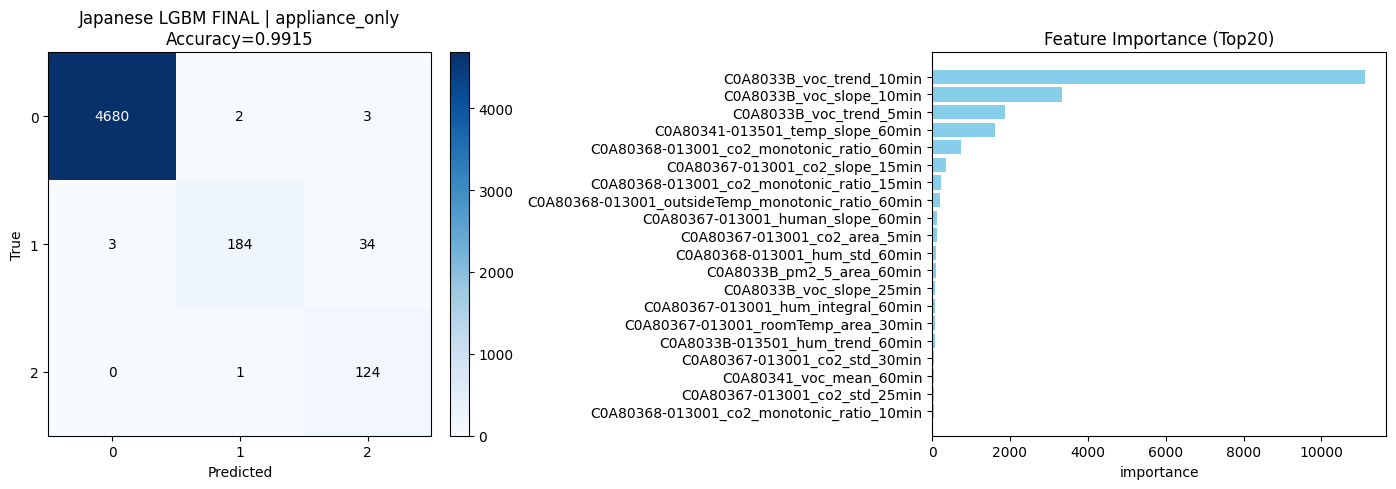


✅ Done.


In [5]:
# ============================================================
# Hybrid pipeline (0/1/2 people count) - Weighted (Class Weight)
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from lightgbm import LGBMClassifier

# =========================
# Config
# =========================
CSV_PATH = "smart_home_data0116.csv"
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20

SEED = 42

# Living RF: block group split
BLOCK_MINUTES = 30
TEST_RATIO = 0.30

# If you still want CSV for importance (optional)
SAVE_IMPORTANCE_CSV = False

# Appliance prefixes
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")

# =========================
# Utilities
# =========================
def to_dt(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce")

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    dfr = dfr.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return dfr

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def uniq(xs):
    return list(dict.fromkeys(xs))

def is_pm25(name: str) -> bool:
    n = name.lower()
    return ("pm2_5" in n) or ("pm2.5" in n) or ("pm25" in n)

def is_co2(name: str) -> bool:
    n = name.lower()
    return n.endswith("_co2") or ("_co2_" in n)

def is_voc(name: str) -> bool:
    return "voc" in name.lower()

def is_temp_hum_like(name: str) -> bool:
    n = name.lower()
    return ("_temp" in n) or ("temp" in n) or ("_hum" in n) or ("humid" in n)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

# -------------------------------

def plot_cm_and_importance(title_prefix, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    top = imp.head(topk)[::-1]

    fig = plt.figure(figsize=(14, 5))

    # CM
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues")
    ax1.set_title(f"{title_prefix}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color="black" if cm[i,j] < cm.max()/2 else "white")

    # Importance
    ax2 = plt.subplot(1, 2, 2)
    ax2.barh(top.index, top.values, color="skyblue")
    ax2.set_title(f"Feature Importance (Top{topk})")
    ax2.set_xlabel("importance")
    plt.tight_layout()
    plt.show()


# =========================
# Feature engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3:
        return pd.Series(0.0, index=y.index)

    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)

    if denom == 0: return pd.Series(0.0, index=y.index)

    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        return np.dot(t_centered, (a - a.mean())) / denom

    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def _monotonic_ratio(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    pos = (d > 0).astype(float)
    return pos.rolling(window, min_periods=1).mean().fillna(0.0)

def _area_from_baseline(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    base = y.rolling(window, min_periods=1).min()
    return (y - base).rolling(window, min_periods=1).sum().fillna(0.0)

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns:
            continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)

        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff_1min"] = d1

        for w in wins:
            feats[f"{c}_mean_{w}min"] = s.rolling(w, min_periods=1).mean().fillna(0.0)
            feats[f"{c}_std_{w}min"]  = s.rolling(w, min_periods=1).std().fillna(0.0)

            feats[f"{c}_slope_{w}min"] = ((s - s.shift(w)) / float(w)).fillna(0.0)
            feats[f"{c}_integral_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

            feats[f"{c}_trend_{w}min"] = _rolling_linreg_slope(s, w)
            feats[f"{c}_monotonic_ratio_{w}min"] = _monotonic_ratio(s, w)
            feats[f"{c}_area_{w}min"] = _area_from_baseline(s, w)

            feats[f"{c}_accel_{w}min"] = (d1 - d1.rolling(w, min_periods=1).mean()).fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns:
            continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X


# =========================
# Column packers
# =========================
def pick_room_columns_latest(df: pd.DataFrame, room: str):
    if room == "Living":
        label = "Label_Living_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80367-013001_") or c.startswith("C0A8033B-013501_")]
    elif room == "Japanese":
        label = "Label_Japanese_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80368-013001_") or c.startswith("C0A80341-013501_")]
    else:
        raise ValueError("room must be Living or Japanese")

    m5_cols = [c for c in df.columns if (c.startswith("M5Stack1_") or c.startswith("M5Stack2_") or c.startswith("M5Stack8_"))]
    pir_cols = [c for c in df.columns if c.lower().startswith("pir")]

    candidate_num = appliance_cols + m5_cols

    co2_cols  = [c for c in candidate_num if is_co2(c)]
    pm25_cols = [c for c in candidate_num if is_pm25(c)]
    voc_cols  = [c for c in candidate_num if is_voc(c)]
    th_cols   = [c for c in candidate_num if is_temp_hum_like(c)]

    human_cols = [c for c in candidate_num if c.lower().endswith("_human")] + pir_cols

    appliance_only = [c for c in df.columns if c.startswith(APPLIANCE_PREFIXES)]
    app_co2  = [c for c in appliance_only if is_co2(c)]
    app_pm25 = [c for c in appliance_only if is_pm25(c)]
    app_voc  = [c for c in appliance_only if is_voc(c)]
    app_th   = [c for c in appliance_only if is_temp_hum_like(c)]
    app_human= [c for c in appliance_only if c.lower().endswith("_human")]

    return dict(
        label=label,
        co2_cols=uniq([c for c in co2_cols if c in df.columns]),
        pm25_cols=uniq([c for c in pm25_cols if c in df.columns]),
        voc_cols=uniq([c for c in voc_cols if c in df.columns]),
        th_cols=uniq([c for c in th_cols if c in df.columns]),
        human_cols=uniq([c for c in human_cols if c in df.columns]),
        app_co2=uniq([c for c in app_co2 if c in df.columns]),
        app_pm25=uniq([c for c in app_pm25 if c in df.columns]),
        app_voc=uniq([c for c in app_voc if c in df.columns]),
        app_th=uniq([c for c in app_th if c in df.columns]),
        app_human=uniq([c for c in app_human if c in df.columns]),
    )


# =========================
# Japanese: LightGBM 2-stage
# =========================
def lgbm_model_multiclass(num_class=3):
    return LGBMClassifier(
        objective="multiclass",
        num_class=num_class,
        n_estimators=1500,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        verbose=-1,
        class_weight="balanced", # 重みづけによる不均衡調整
    )

def lgbm_model_binary():
    return LGBMClassifier(
        objective="binary",
        n_estimators=1200,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        verbose=-1,
        class_weight="balanced", # 重みづけによる不均衡調整
    )

def run_japanese_lgbm_2stage(df: pd.DataFrame, setting: str):
    room = "Japanese"
    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {room}: {label_col} not found")
        return

    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin([0, 1, 2]), np.nan).ffill().fillna(0).astype(int)
    y_occ = (y > 0).astype(int)

    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]
    else:
        raise ValueError("Japanese LGBM setting must be all or appliance_only")

    num_cols = uniq([c for c in num_cols if c in df.columns])
    hum_cols = uniq([c for c in hum_cols if c in df.columns])

    X_num = build_numeric_features_multiwin(df, num_cols, WINS) if len(num_cols) else pd.DataFrame(index=df.index)
    X_hum = build_human_features(df, hum_cols, WINS) if len(hum_cols) else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_hum], axis=1).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]

    # Time split
    n = len(df)
    n_tr = int(n * 0.80)
    tr_idx = np.arange(0, n_tr)
    te_idx = np.arange(n_tr, n)

    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
    y_occ_tr, y_occ_te = y_occ.iloc[tr_idx], y_occ.iloc[te_idx]

    print("\n" + "=" * 92)
    print(f"[Japanese][LGBM 2-stage] setting={setting} | features={X.shape[1]} | train={len(tr_idx)} test={len(te_idx)}")
    print(f"label dist test: {y_te.value_counts().to_dict()}")
    print("=" * 92)

    # --- Stage1: occupancy 0 vs >0 ---
    # 重みづけはモデルパラメータ class_weight="balanced" に任せる

    occ_model = lgbm_model_binary()
    occ_model.fit(X_tr, y_occ_tr)
    pred_occ = occ_model.predict(X_te)

    print("\n--- Stage1: Occupancy (0 vs >0) ---")
    print(f"Accuracy: {accuracy_score(y_occ_te, pred_occ):.4f}")
    print(confusion_matrix(y_occ_te, pred_occ, labels=[0, 1]))

    occ_gain = occ_model.booster_.feature_importance(importance_type="gain")
    plot_cm_and_importance(
        title_prefix=f"Japanese LGBM Stage1 OCC | {setting} (Weighted)",
        y_true=y_occ_te, y_pred=pred_occ,
        labels=[0, 1],
        feature_names=X.columns.tolist(),
        importances=occ_gain,
        topk=TOPK_IMPORTANCE
    )

    # --- Stage2: count 1 vs 2 ---
    tr_mask_12 = y_tr.isin([1, 2])
    te_mask_12 = y_te.isin([1, 2])

    X_tr_12 = X_tr.loc[tr_mask_12]
    y_tr_12 = y_tr.loc[tr_mask_12]
    X_te_12 = X_te.loc[te_mask_12]
    y_te_12 = y_te.loc[te_mask_12]

    if len(X_tr_12) > 0 and len(np.unique(y_tr_12)) >= 2:
        y_tr_map = y_tr_12.map({1: 0, 2: 1}).astype(int)
        y_te_map = y_te_12.map({1: 0, 2: 1}).astype(int)

        cnt_model = LGBMClassifier(
            objective="multiclass",
            num_class=2,
            n_estimators=1500,
            learning_rate=0.03,
            num_leaves=63,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=SEED,
            n_jobs=-1,
            verbose=-1,
            class_weight="balanced", # 重みづけ
        )
        cnt_model.fit(X_tr_12, y_tr_map)
        pred_12 = cnt_model.predict(X_te_12)

        print("\n--- Stage2: Count (1 vs 2) on occupied-only ---")
        print(f"Accuracy: {accuracy_score(y_te_map, pred_12):.4f}")
        print(confusion_matrix(y_te_map, pred_12, labels=[0, 1]))

        cnt_gain = cnt_model.booster_.feature_importance(importance_type="gain")
        plot_cm_and_importance(
            title_prefix=f"Japanese LGBM Stage2 (1vs2) | {setting} (Weighted)",
            y_true=y_te_map, y_pred=pred_12,
            labels=[0, 1],
            feature_names=X.columns.tolist(),
            importances=cnt_gain,
            topk=TOPK_IMPORTANCE
        )
    else:
        print("[WARN] Stage2 (1vs2) insufficient data, skip.")
        return

    # --- Final: build 0/1/2 ---
    final_pred = np.zeros(len(X_te), dtype=int)
    pred_occ_mask = (pred_occ == 1)
    if pred_occ_mask.any():
        pred_12_all = cnt_model.predict(X_te.loc[pred_occ_mask])
        final_pred[pred_occ_mask] = pd.Series(pred_12_all).map({0: 1, 1: 2}).values

    print("\n--- FINAL (0/1/2 by 2-stage) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred):.4f}")
    print(confusion_matrix(y_te, final_pred, labels=[0, 1, 2]))
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    plot_cm_and_importance(
        title_prefix=f"Japanese LGBM FINAL | {setting}",
        y_true=y_te, y_pred=final_pred,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=cnt_gain,
        topk=TOPK_IMPORTANCE
    )


# =========================
# Living: RandomForest 2-stage (GroupShuffleSplit blocks)
# =========================
def rf_occ_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample", # サブサンプル毎に重みづけ計算
        min_samples_leaf=2,
    )

def rf_cnt_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

def run_living_rf_2stage(df: pd.DataFrame, setting: str):
    room = "Living"
    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {room}: {label_col} not found")
        return

    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin([0, 1, 2]), np.nan).ffill().fillna(0).astype(int)

    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]
    elif setting == "no_co2_human":
        num_cols = pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = []
    else:
        raise ValueError("Living RF setting must be all / appliance_only / no_co2_human")

    num_cols = uniq([c for c in num_cols if c in df.columns])
    hum_cols = uniq([c for c in hum_cols if c in df.columns])

    X_num = build_numeric_features_multiwin(df, num_cols, WINS) if len(num_cols) else pd.DataFrame(index=df.index)
    X_hum = build_human_features(df, hum_cols, WINS) if len(hum_cols) else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_hum], axis=1).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]

    # group split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr = X.iloc[tr_idx].to_numpy(dtype=np.float32)
    y_tr = y.iloc[tr_idx].to_numpy(dtype=int)
    X_te = X.iloc[te_idx].to_numpy(dtype=np.float32)
    y_te = y.iloc[te_idx].to_numpy(dtype=int)

    X_tr[~np.isfinite(X_tr)] = 0.0
    X_te[~np.isfinite(X_te)] = 0.0

    print("\n" + "=" * 92)
    print(f"[Living][RF 2-stage] setting={setting} | features={X.shape[1]} | train={len(tr_idx)} test={len(te_idx)}")
    print(f"label dist test: {pd.Series(y_te).value_counts().to_dict()}")
    print("=" * 92)

    # --- Stage1: occupancy ---
    y_tr_occ = (y_tr > 0).astype(int)
    y_te_occ = (y_te > 0).astype(int)

    # 重みづけは class_weight="balanced_subsample" で自動適用

    occ_model = rf_occ_model()
    occ_model.fit(X_tr, y_tr_occ)
    pred_occ = occ_model.predict(X_te)

    print("\n--- Stage1: Occupancy (0 vs >0) ---")
    print(f"Accuracy: {accuracy_score(y_te_occ, pred_occ):.4f}")
    print(confusion_matrix(y_te_occ, pred_occ, labels=[0, 1]))

    plot_cm_and_importance(
        title_prefix=f"Living RF Stage1 OCC | {setting} (Weighted)",
        y_true=y_te_occ, y_pred=pred_occ,
        labels=[0, 1],
        feature_names=X.columns.tolist(),
        importances=occ_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

    # --- Stage2: 1 vs 2 ---
    tr_mask = (y_tr > 0)
    te_mask = (y_te > 0)

    X_tr_in = X_tr[tr_mask]
    y_tr_in = y_tr[tr_mask]
    X_te_in = X_te[te_mask]
    y_te_in = y_te[te_mask]

    if len(np.unique(y_tr_in)) >= 2 and len(y_te_in) > 0:
        cnt_model = rf_cnt_model()
        cnt_model.fit(X_tr_in, y_tr_in)
        pred_in = cnt_model.predict(X_te_in)

        print("\n--- Stage2: Count (1 vs 2) on occupied-only ---")
        print(f"Accuracy: {accuracy_score(y_te_in, pred_in):.4f}")
        print(confusion_matrix(y_te_in, pred_in, labels=[1, 2]))

        plot_cm_and_importance(
            title_prefix=f"Living RF Stage2 (1vs2) | {setting} (Weighted)",
            y_true=y_te_in, y_pred=pred_in,
            labels=[1, 2],
            feature_names=X.columns.tolist(),
            importances=cnt_model.feature_importances_,
            topk=TOPK_IMPORTANCE
        )
    else:
        print("[WARN] Stage2 (1vs2) insufficient data, skip.")
        return

    # --- Final ---
    final_pred = np.zeros_like(y_te)
    pred_occ_mask = (pred_occ == 1)
    if pred_occ_mask.sum() > 0:
        final_pred[pred_occ_mask] = cnt_model.predict(X_te[pred_occ_mask])

    print("\n--- FINAL (0/1/2 by 2-stage) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred):.4f}")
    print(confusion_matrix(y_te, final_pred, labels=[0, 1, 2]))
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    plot_cm_and_importance(
        title_prefix=f"Living RF FINAL | {setting}",
        y_true=y_te, y_pred=final_pred,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=cnt_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )


# =========================
# Main
# =========================
print("📥 Loading CSV...")
try:
    df0 = pd.read_csv(CSV_PATH, low_memory=False)
except UnicodeDecodeError:
    print("Warning: Standard encoding failed. Trying 'cp932'.")
    df0 = pd.read_csv(CSV_PATH, low_memory=False, encoding='cp932')

if TIME_COL not in df0.columns:
    raise ValueError(f"CSVに {TIME_COL} 列がありません。")

df0[TIME_COL] = to_dt(df0[TIME_COL])
df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)

# forward-only preprocessing
df0 = safe_ffill(df0).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

# resample to 1min
print("Resampling to 1min...")
df = resample_1min(df0, RESAMPLE_RULE)

# ---- Living: RF ----
print("\n============================")
print("RUN: Living (RF 2-stage) - Weighted")
print("============================")
for setting in ["all", "appliance_only", "no_co2_human"]:
    run_living_rf_2stage(df, setting)

# ---- Japanese: LGBM ----
print("\n============================")
print("RUN: Japanese (LGBM 2-stage) - Weighted")
print("============================")
for setting in ["all", "appliance_only"]:
    run_japanese_lgbm_2stage(df, setting)

print("\n✅ Done.")

📥 Loading CSV...
Resampling to 1min...

RUN: Living (RF 2-stage) - Weighted

[Living][RF 2-stage] setting=all | features=1281 | train=17591 test=7560
label dist test: {0: 6901, 2: 339, 1: 320}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9934
[[6874   27]
 [  23  636]]


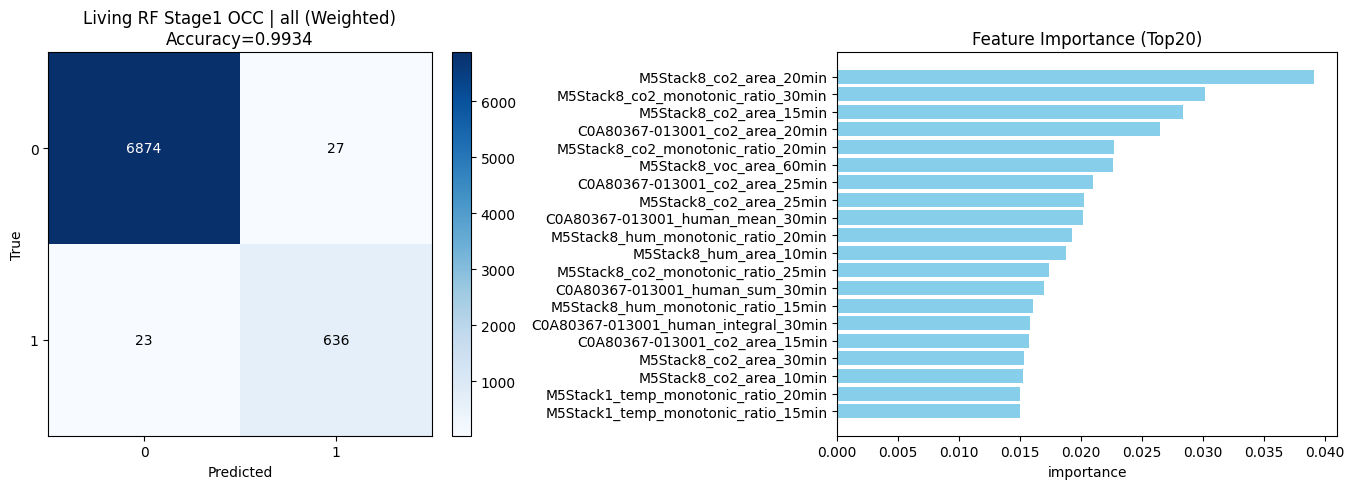


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.8619
[[281  39]
 [ 52 287]]


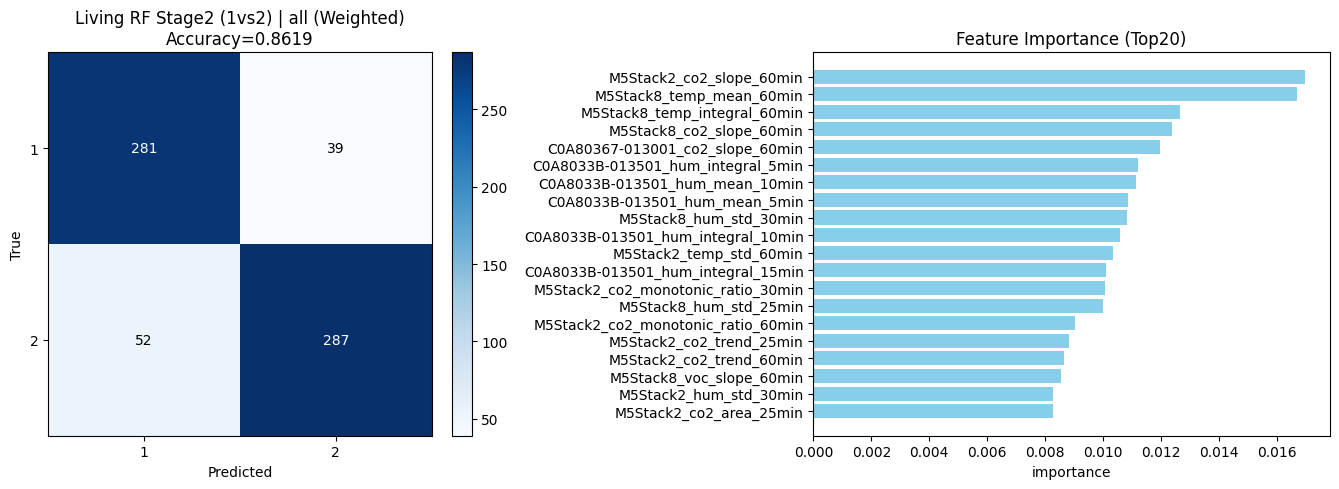


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9829
[[6874    4   23]
 [  23  270   27]
 [   0   52  287]]
              precision    recall  f1-score   support

           0      0.997     0.996     0.996      6901
           1      0.828     0.844     0.836       320
           2      0.852     0.847     0.849       339

    accuracy                          0.983      7560
   macro avg      0.892     0.895     0.894      7560
weighted avg      0.983     0.983     0.983      7560



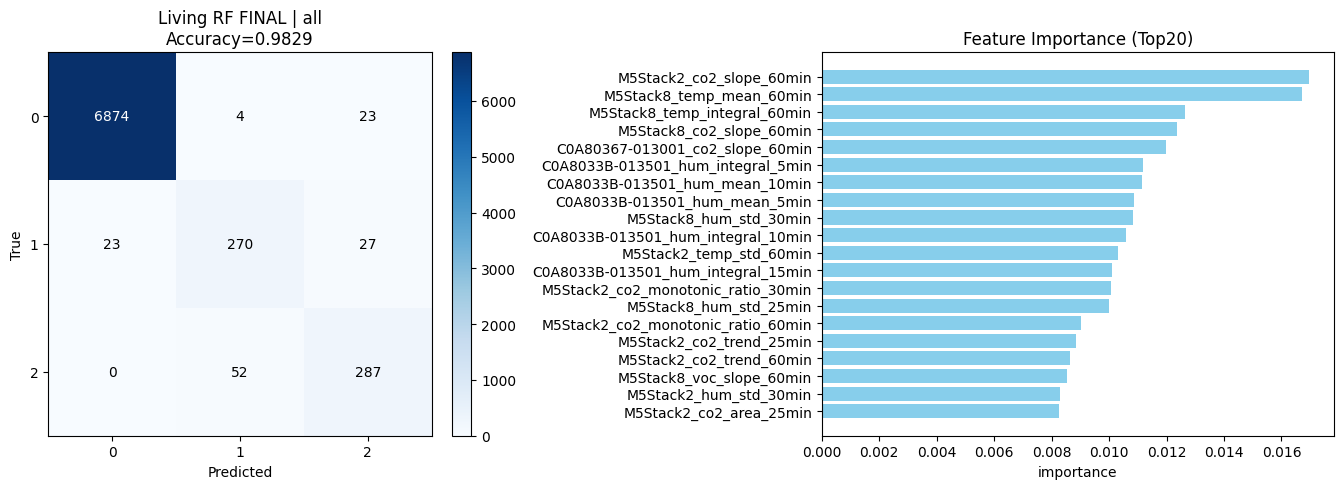


[Living][RF 2-stage] setting=appliance_only | features=1406 | train=17591 test=7560
label dist test: {0: 6901, 2: 339, 1: 320}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9933
[[6876   25]
 [  26  633]]


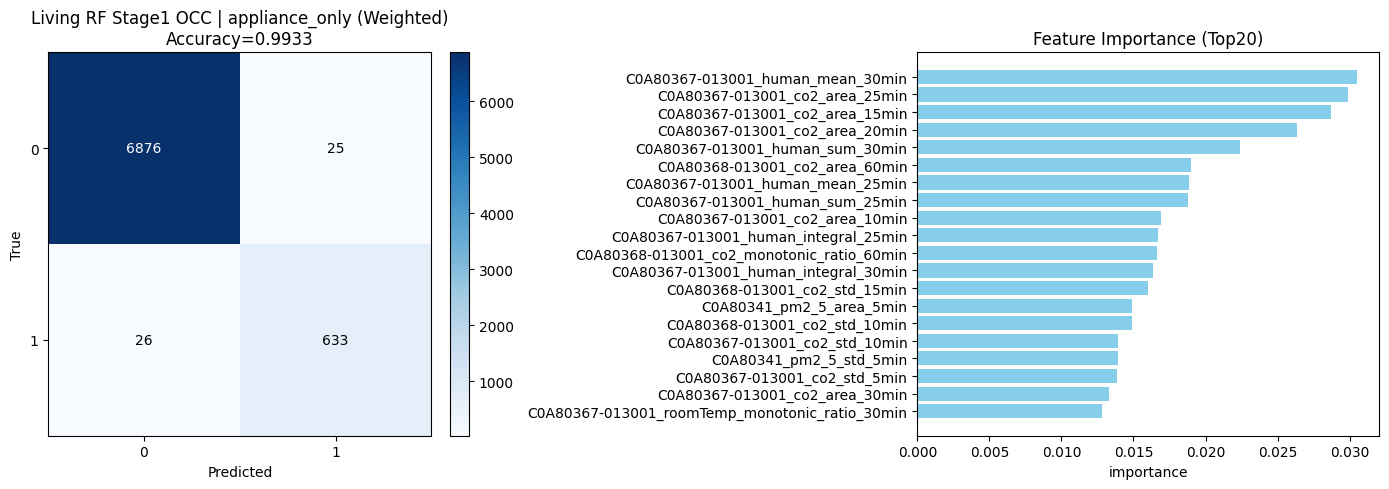


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.8619
[[283  37]
 [ 54 285]]


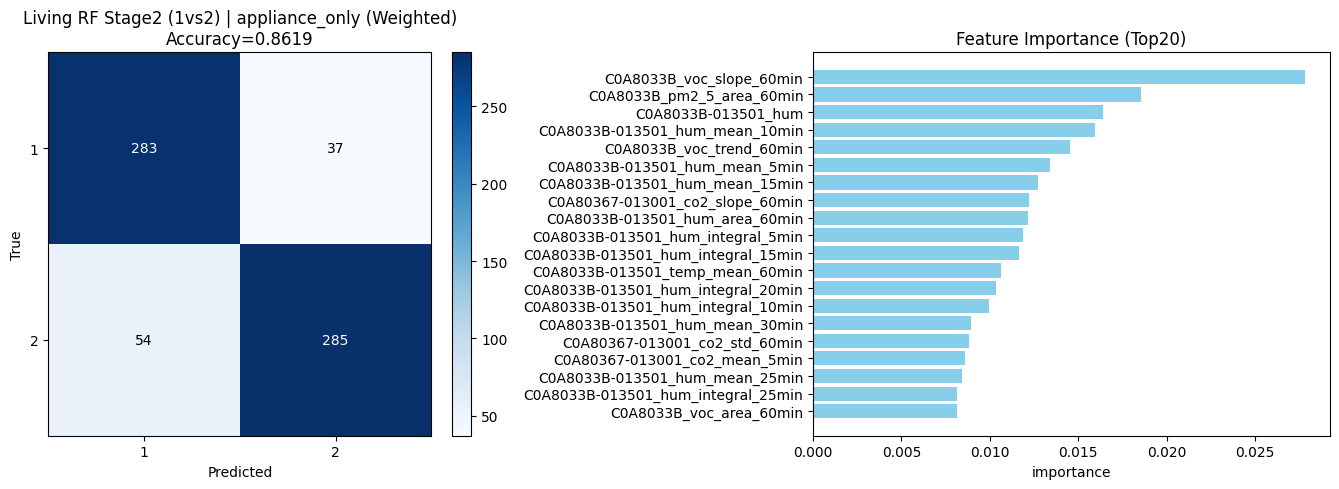


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9841
[[6876    6   19]
 [  24  280   16]
 [   2   53  284]]
              precision    recall  f1-score   support

           0      0.996     0.996     0.996      6901
           1      0.826     0.875     0.850       320
           2      0.890     0.838     0.863       339

    accuracy                          0.984      7560
   macro avg      0.904     0.903     0.903      7560
weighted avg      0.984     0.984     0.984      7560



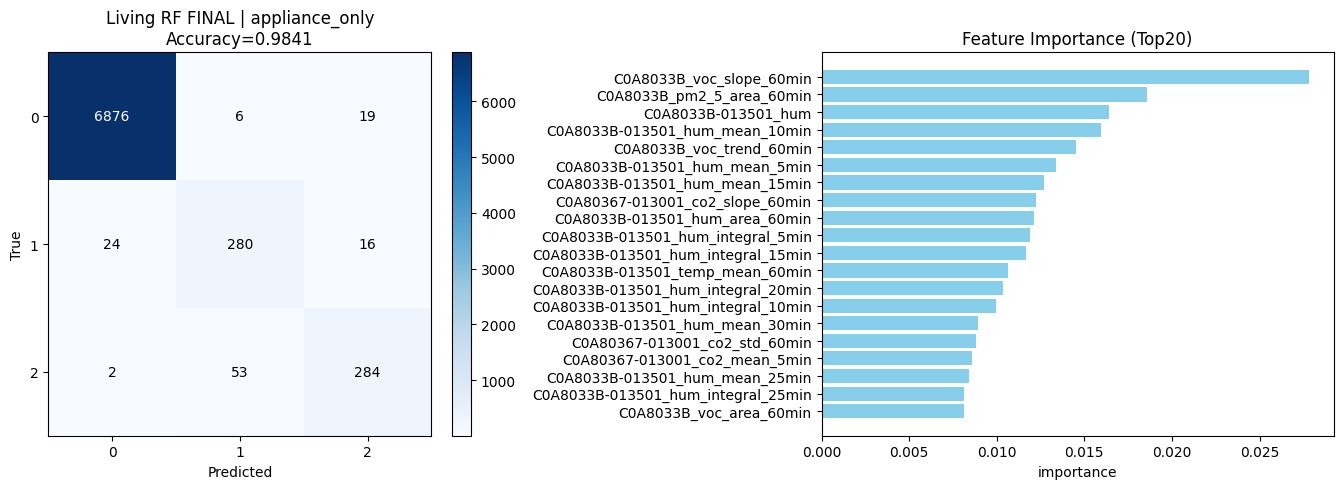


[Living][RF 2-stage] setting=no_co2_human | features=986 | train=17591 test=7560
label dist test: {0: 6901, 2: 339, 1: 320}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9933
[[6889   12]
 [  39  620]]


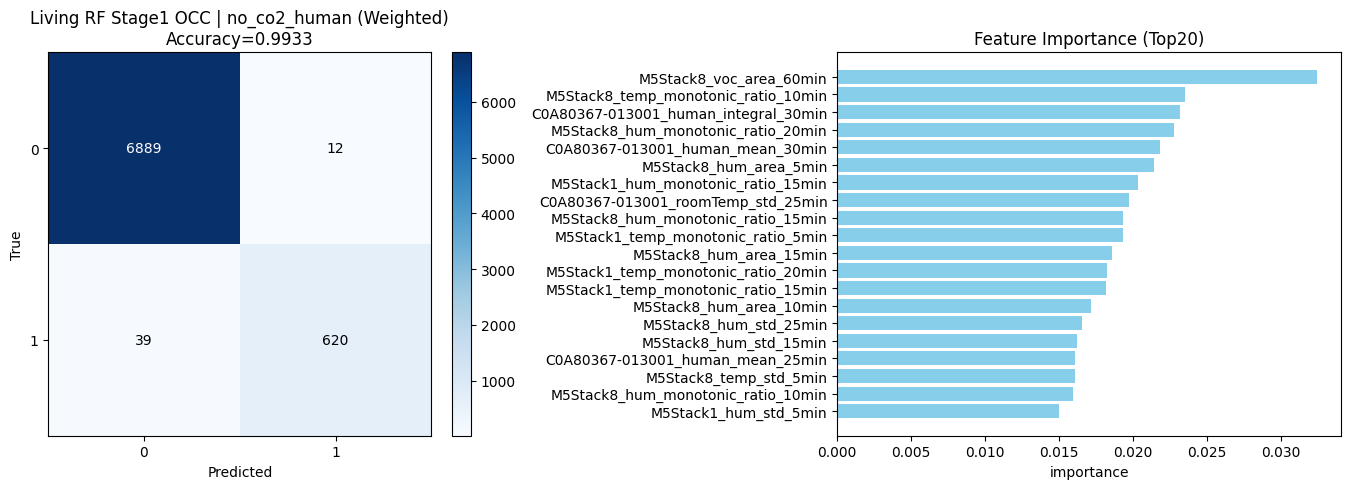


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.8407
[[283  37]
 [ 68 271]]


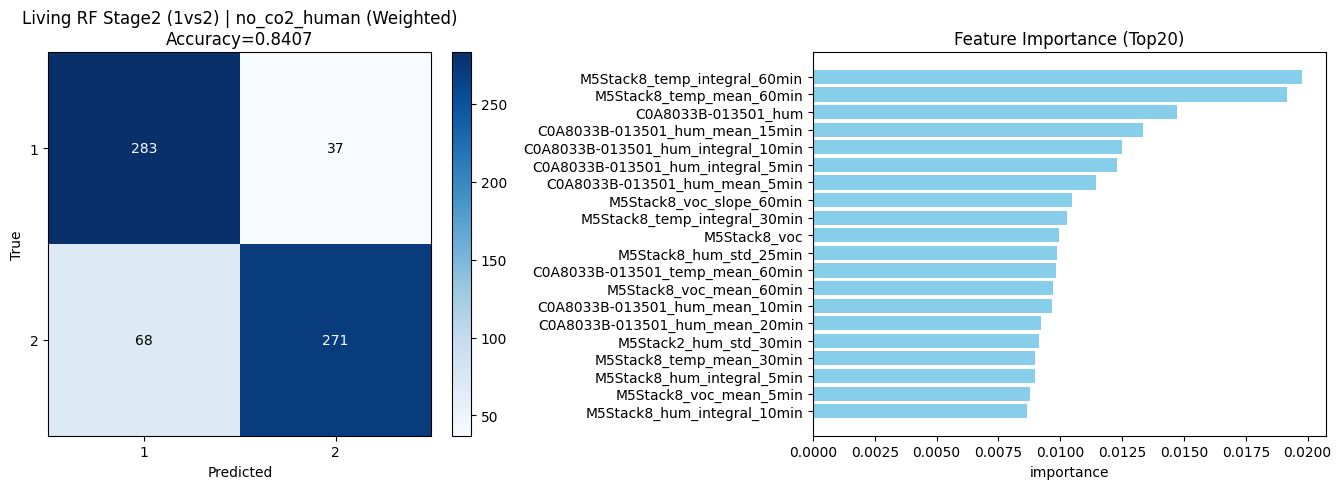


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9824
[[6889    0   12]
 [  39  267   14]
 [   0   68  271]]
              precision    recall  f1-score   support

           0      0.994     0.998     0.996      6901
           1      0.797     0.834     0.815       320
           2      0.912     0.799     0.852       339

    accuracy                          0.982      7560
   macro avg      0.901     0.877     0.888      7560
weighted avg      0.982     0.982     0.982      7560



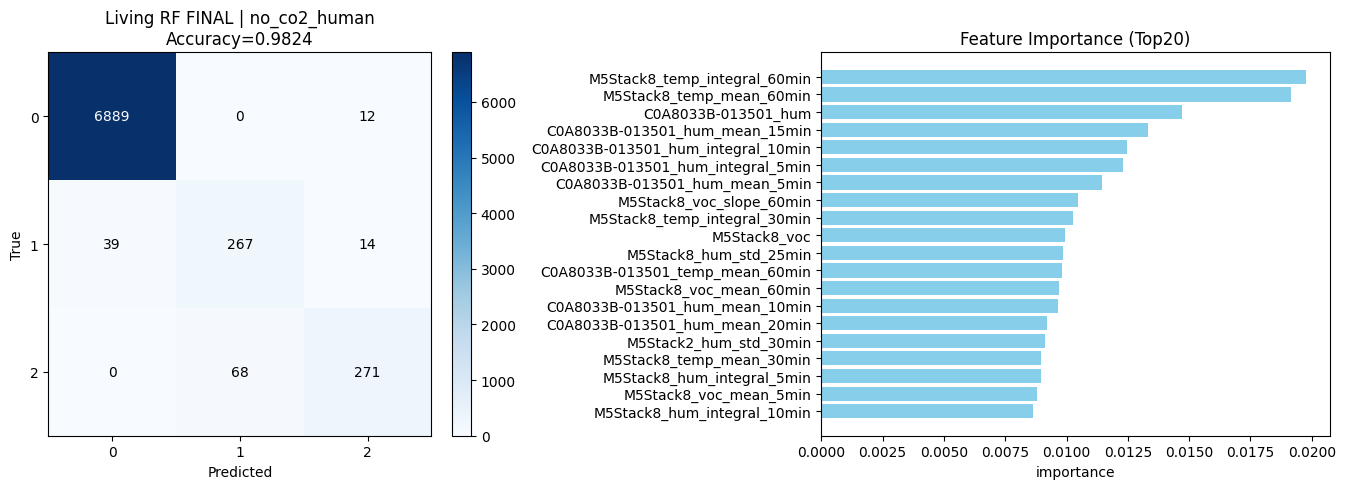


RUN: Japanese (RF 2-stage) - Weighted

[Japanese][RF 2-stage] setting=all | features=1281 | train=17591 test=7560
label dist test: {0: 7142, 1: 228, 2: 190}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9810
[[7099   43]
 [ 101  317]]


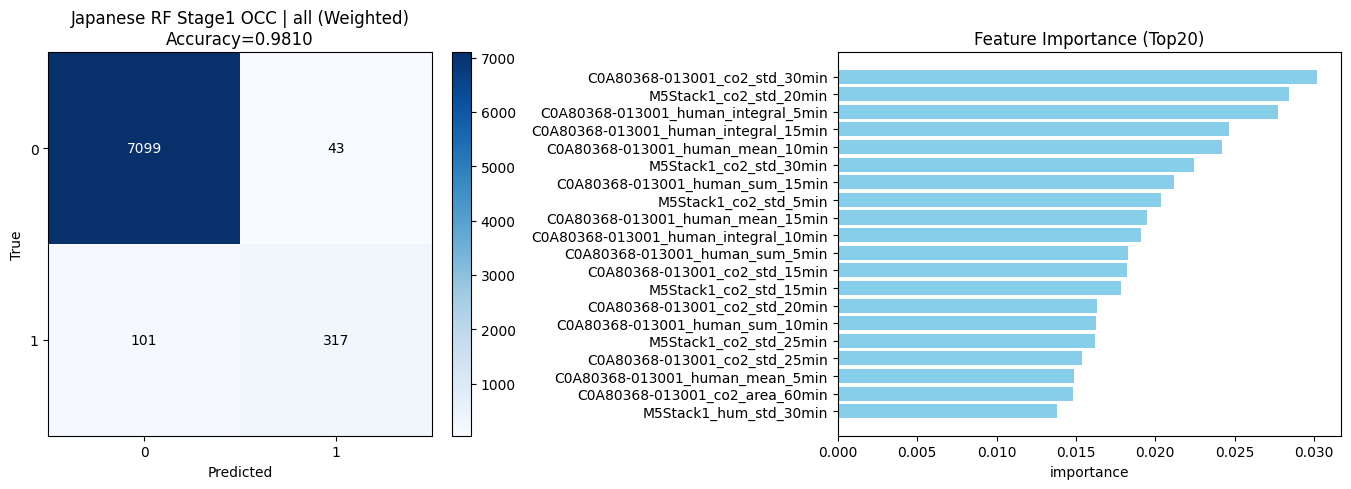


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.9952
[[226   2]
 [  0 190]]


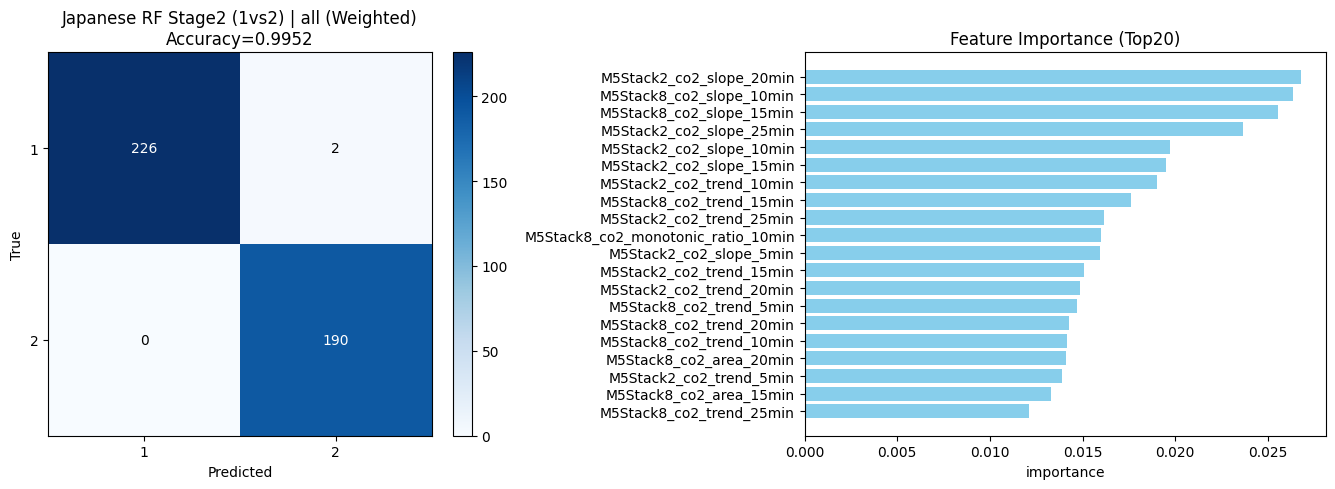


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9810
[[7099   35    8]
 [  54  174    0]
 [  47    0  143]]
              precision    recall  f1-score   support

           0      0.986     0.994     0.990      7142
           1      0.833     0.763     0.796       228
           2      0.947     0.753     0.839       190

    accuracy                          0.981      7560
   macro avg      0.922     0.837     0.875      7560
weighted avg      0.980     0.981     0.980      7560



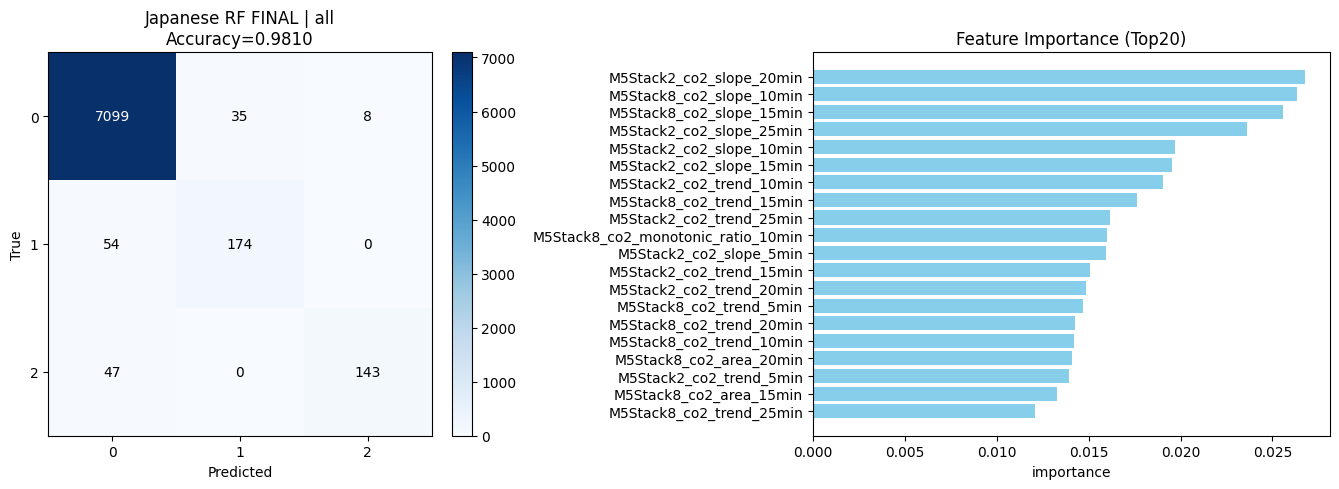


[Japanese][RF 2-stage] setting=appliance_only | features=1406 | train=17591 test=7560
label dist test: {0: 7142, 1: 228, 2: 190}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9778
[[7109   33]
 [ 135  283]]


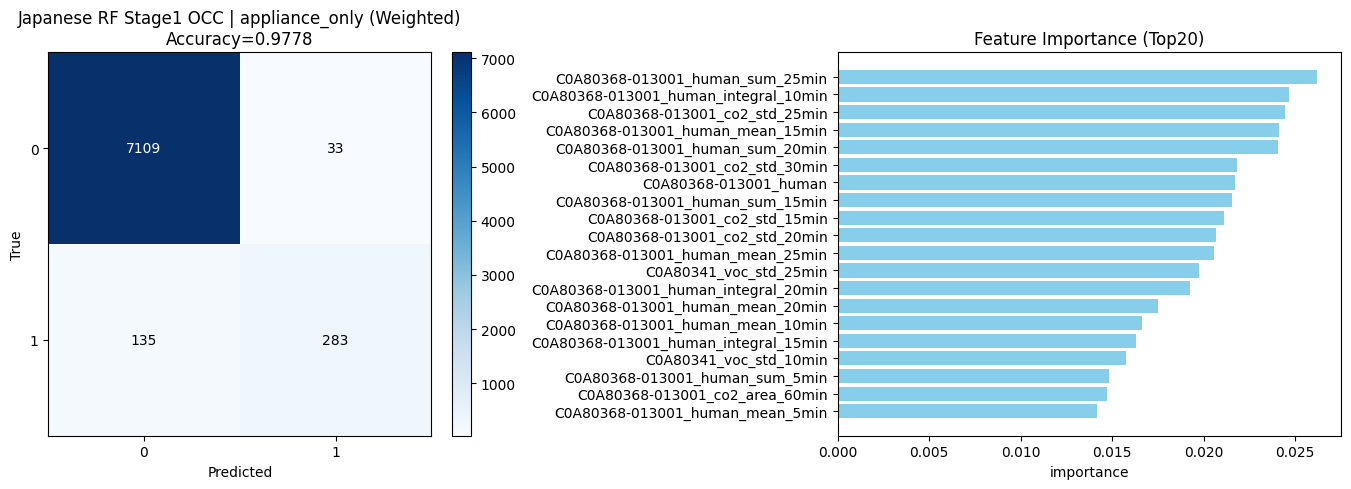


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.9904
[[228   0]
 [  4 186]]


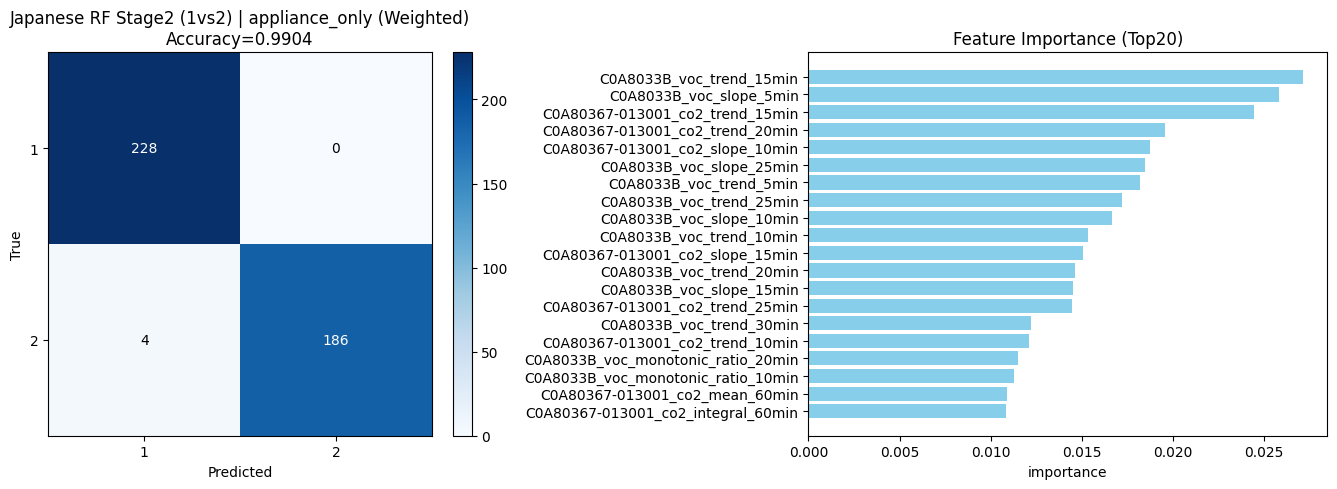


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9778
[[7109   33    0]
 [  42  186    0]
 [  93    0   97]]
              precision    recall  f1-score   support

           0      0.981     0.995     0.988      7142
           1      0.849     0.816     0.832       228
           2      1.000     0.511     0.676       190

    accuracy                          0.978      7560
   macro avg      0.944     0.774     0.832      7560
weighted avg      0.978     0.978     0.976      7560



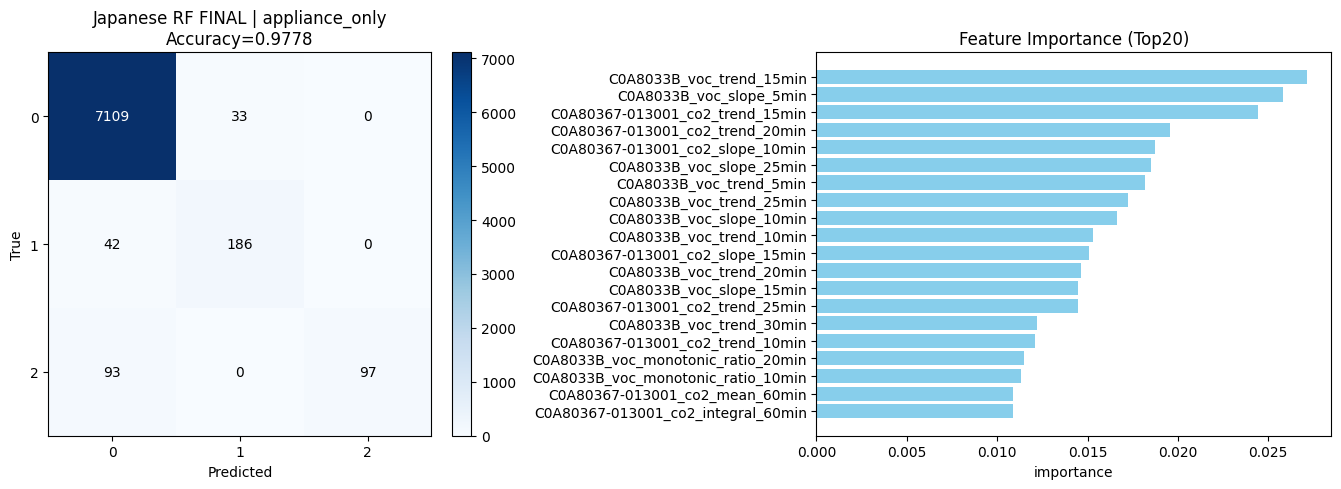


✅ Done.


In [7]:
# ============================================================
# Hybrid pipeline (0/1/2 people count) - Weighted (Class Weight)
# RF Applied to Both Rooms
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# LGBM is no longer used, but keeping import just in case
from lightgbm import LGBMClassifier

# =========================
# Config
# =========================
CSV_PATH = "smart_home_data0116.csv"
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20

SEED = 42

# RF: block group split settings
BLOCK_MINUTES = 30
TEST_RATIO = 0.30

# If you still want CSV for importance (optional)
SAVE_IMPORTANCE_CSV = False

# Appliance prefixes
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")

# =========================
# Utilities
# =========================
def to_dt(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce")

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    dfr = dfr.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return dfr

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def uniq(xs):
    return list(dict.fromkeys(xs))

def is_pm25(name: str) -> bool:
    n = name.lower()
    return ("pm2_5" in n) or ("pm2.5" in n) or ("pm25" in n)

def is_co2(name: str) -> bool:
    n = name.lower()
    return n.endswith("_co2") or ("_co2_" in n)

def is_voc(name: str) -> bool:
    return "voc" in name.lower()

def is_temp_hum_like(name: str) -> bool:
    n = name.lower()
    return ("_temp" in n) or ("temp" in n) or ("_hum" in n) or ("humid" in n)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

# -------------------------------

def plot_cm_and_importance(title_prefix, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    top = imp.head(topk)[::-1]

    fig = plt.figure(figsize=(14, 5))

    # CM
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues")
    ax1.set_title(f"{title_prefix}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color="black" if cm[i,j] < cm.max()/2 else "white")

    # Importance
    ax2 = plt.subplot(1, 2, 2)
    ax2.barh(top.index, top.values, color="skyblue")
    ax2.set_title(f"Feature Importance (Top{topk})")
    ax2.set_xlabel("importance")
    plt.tight_layout()
    plt.show()


# =========================
# Feature engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3:
        return pd.Series(0.0, index=y.index)

    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)

    if denom == 0: return pd.Series(0.0, index=y.index)

    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        return np.dot(t_centered, (a - a.mean())) / denom

    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def _monotonic_ratio(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    pos = (d > 0).astype(float)
    return pos.rolling(window, min_periods=1).mean().fillna(0.0)

def _area_from_baseline(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    base = y.rolling(window, min_periods=1).min()
    return (y - base).rolling(window, min_periods=1).sum().fillna(0.0)

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns:
            continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)

        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff_1min"] = d1

        for w in wins:
            feats[f"{c}_mean_{w}min"] = s.rolling(w, min_periods=1).mean().fillna(0.0)
            feats[f"{c}_std_{w}min"]  = s.rolling(w, min_periods=1).std().fillna(0.0)

            feats[f"{c}_slope_{w}min"] = ((s - s.shift(w)) / float(w)).fillna(0.0)
            feats[f"{c}_integral_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

            feats[f"{c}_trend_{w}min"] = _rolling_linreg_slope(s, w)
            feats[f"{c}_monotonic_ratio_{w}min"] = _monotonic_ratio(s, w)
            feats[f"{c}_area_{w}min"] = _area_from_baseline(s, w)

            feats[f"{c}_accel_{w}min"] = (d1 - d1.rolling(w, min_periods=1).mean()).fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns:
            continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X


# =========================
# Column packers
# =========================
def pick_room_columns_latest(df: pd.DataFrame, room: str):
    if room == "Living":
        label = "Label_Living_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80367-013001_") or c.startswith("C0A8033B-013501_")]
    elif room == "Japanese":
        label = "Label_Japanese_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80368-013001_") or c.startswith("C0A80341-013501_")]
    else:
        raise ValueError("room must be Living or Japanese")

    m5_cols = [c for c in df.columns if (c.startswith("M5Stack1_") or c.startswith("M5Stack2_") or c.startswith("M5Stack8_"))]
    pir_cols = [c for c in df.columns if c.lower().startswith("pir")]

    candidate_num = appliance_cols + m5_cols

    co2_cols  = [c for c in candidate_num if is_co2(c)]
    pm25_cols = [c for c in candidate_num if is_pm25(c)]
    voc_cols  = [c for c in candidate_num if is_voc(c)]
    th_cols   = [c for c in candidate_num if is_temp_hum_like(c)]

    human_cols = [c for c in candidate_num if c.lower().endswith("_human")] + pir_cols

    appliance_only = [c for c in df.columns if c.startswith(APPLIANCE_PREFIXES)]
    app_co2  = [c for c in appliance_only if is_co2(c)]
    app_pm25 = [c for c in appliance_only if is_pm25(c)]
    app_voc  = [c for c in appliance_only if is_voc(c)]
    app_th   = [c for c in appliance_only if is_temp_hum_like(c)]
    app_human= [c for c in appliance_only if c.lower().endswith("_human")]

    return dict(
        label=label,
        co2_cols=uniq([c for c in co2_cols if c in df.columns]),
        pm25_cols=uniq([c for c in pm25_cols if c in df.columns]),
        voc_cols=uniq([c for c in voc_cols if c in df.columns]),
        th_cols=uniq([c for c in th_cols if c in df.columns]),
        human_cols=uniq([c for c in human_cols if c in df.columns]),
        app_co2=uniq([c for c in app_co2 if c in df.columns]),
        app_pm25=uniq([c for c in app_pm25 if c in df.columns]),
        app_voc=uniq([c for c in app_voc if c in df.columns]),
        app_th=uniq([c for c in app_th if c in df.columns]),
        app_human=uniq([c for c in app_human if c in df.columns]),
    )


# =========================
# Shared: RandomForest 2-stage Models
# =========================
def rf_occ_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample", # サブサンプル毎に重みづけ
        min_samples_leaf=2,
    )

def rf_cnt_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

# =========================
# Japanese: Random Forest 2-stage (Updated)
# =========================
def run_japanese_rf_2stage(df: pd.DataFrame, setting: str):
    room = "Japanese"
    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {room}: {label_col} not found")
        return

    # y: only 0/1/2
    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin([0, 1, 2]), np.nan).ffill().fillna(0).astype(int)

    # feature set by setting
    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]
    else:
        raise ValueError("Japanese RF setting must be all or appliance_only (or customize if needed)")

    num_cols = uniq([c for c in num_cols if c in df.columns])
    hum_cols = uniq([c for c in hum_cols if c in df.columns])

    X_num = build_numeric_features_multiwin(df, num_cols, WINS) if len(num_cols) else pd.DataFrame(index=df.index)
    X_hum = build_human_features(df, hum_cols, WINS) if len(hum_cols) else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_hum], axis=1).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]

    # group split (same as Living room logic for consistency)
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr = X.iloc[tr_idx].to_numpy(dtype=np.float32)
    y_tr = y.iloc[tr_idx].to_numpy(dtype=int)
    X_te = X.iloc[te_idx].to_numpy(dtype=np.float32)
    y_te = y.iloc[te_idx].to_numpy(dtype=int)

    X_tr[~np.isfinite(X_tr)] = 0.0
    X_te[~np.isfinite(X_te)] = 0.0

    print("\n" + "=" * 92)
    print(f"[Japanese][RF 2-stage] setting={setting} | features={X.shape[1]} | train={len(tr_idx)} test={len(te_idx)}")
    print(f"label dist test: {pd.Series(y_te).value_counts().to_dict()}")
    print("=" * 92)

    # --- Stage1: occupancy ---
    y_tr_occ = (y_tr > 0).astype(int)
    y_te_occ = (y_te > 0).astype(int)

    occ_model = rf_occ_model()
    occ_model.fit(X_tr, y_tr_occ)
    pred_occ = occ_model.predict(X_te)

    print("\n--- Stage1: Occupancy (0 vs >0) ---")
    print(f"Accuracy: {accuracy_score(y_te_occ, pred_occ):.4f}")
    print(confusion_matrix(y_te_occ, pred_occ, labels=[0, 1]))

    plot_cm_and_importance(
        title_prefix=f"Japanese RF Stage1 OCC | {setting} (Weighted)",
        y_true=y_te_occ, y_pred=pred_occ,
        labels=[0, 1],
        feature_names=X.columns.tolist(),
        importances=occ_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

    # --- Stage2: 1 vs 2 (train on true occupied only) ---
    tr_mask = (y_tr > 0)
    te_mask = (y_te > 0)

    X_tr_in = X_tr[tr_mask]
    y_tr_in = y_tr[tr_mask] # 1/2
    X_te_in = X_te[te_mask]
    y_te_in = y_te[te_mask] # 1/2

    if len(np.unique(y_tr_in)) >= 2 and len(y_te_in) > 0:
        cnt_model = rf_cnt_model()
        cnt_model.fit(X_tr_in, y_tr_in)
        pred_in = cnt_model.predict(X_te_in)

        print("\n--- Stage2: Count (1 vs 2) on occupied-only ---")
        print(f"Accuracy: {accuracy_score(y_te_in, pred_in):.4f}")
        print(confusion_matrix(y_te_in, pred_in, labels=[1, 2]))

        plot_cm_and_importance(
            title_prefix=f"Japanese RF Stage2 (1vs2) | {setting} (Weighted)",
            y_true=y_te_in, y_pred=pred_in,
            labels=[1, 2],
            feature_names=X.columns.tolist(),
            importances=cnt_model.feature_importances_,
            topk=TOPK_IMPORTANCE
        )
    else:
        print("[WARN] Stage2 (1vs2) insufficient data, skip.")
        return

    # --- Final: using predicted occupancy mask ---
    final_pred = np.zeros_like(y_te)
    pred_occ_mask = (pred_occ == 1)
    if pred_occ_mask.sum() > 0:
        final_pred[pred_occ_mask] = cnt_model.predict(X_te[pred_occ_mask])

    print("\n--- FINAL (0/1/2 by 2-stage) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred):.4f}")
    print(confusion_matrix(y_te, final_pred, labels=[0, 1, 2]))
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    plot_cm_and_importance(
        title_prefix=f"Japanese RF FINAL | {setting}",
        y_true=y_te, y_pred=final_pred,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=cnt_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )


# =========================
# Living: RandomForest 2-stage (GroupShuffleSplit blocks)
# =========================
def run_living_rf_2stage(df: pd.DataFrame, setting: str):
    room = "Living"
    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {room}: {label_col} not found")
        return

    # y: only 0/1/2
    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin([0, 1, 2]), np.nan).ffill().fillna(0).astype(int)

    # feature set by setting
    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"] # no PIR
    elif setting == "no_co2_human":
        num_cols = pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = []
    else:
        raise ValueError("Living RF setting must be all / appliance_only / no_co2_human")

    num_cols = uniq([c for c in num_cols if c in df.columns])
    hum_cols = uniq([c for c in hum_cols if c in df.columns])

    X_num = build_numeric_features_multiwin(df, num_cols, WINS) if len(num_cols) else pd.DataFrame(index=df.index)
    X_hum = build_human_features(df, hum_cols, WINS) if len(hum_cols) else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_hum], axis=1).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]

    # group split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr = X.iloc[tr_idx].to_numpy(dtype=np.float32)
    y_tr = y.iloc[tr_idx].to_numpy(dtype=int)
    X_te = X.iloc[te_idx].to_numpy(dtype=np.float32)
    y_te = y.iloc[te_idx].to_numpy(dtype=int)

    X_tr[~np.isfinite(X_tr)] = 0.0
    X_te[~np.isfinite(X_te)] = 0.0

    print("\n" + "=" * 92)
    print(f"[Living][RF 2-stage] setting={setting} | features={X.shape[1]} | train={len(tr_idx)} test={len(te_idx)}")
    print(f"label dist test: {pd.Series(y_te).value_counts().to_dict()}")
    print("=" * 92)

    # --- Stage1: occupancy ---
    y_tr_occ = (y_tr > 0).astype(int)
    y_te_occ = (y_te > 0).astype(int)

    occ_model = rf_occ_model()
    occ_model.fit(X_tr, y_tr_occ)
    pred_occ = occ_model.predict(X_te)

    print("\n--- Stage1: Occupancy (0 vs >0) ---")
    print(f"Accuracy: {accuracy_score(y_te_occ, pred_occ):.4f}")
    print(confusion_matrix(y_te_occ, pred_occ, labels=[0, 1]))

    plot_cm_and_importance(
        title_prefix=f"Living RF Stage1 OCC | {setting} (Weighted)",
        y_true=y_te_occ, y_pred=pred_occ,
        labels=[0, 1],
        feature_names=X.columns.tolist(),
        importances=occ_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

    # --- Stage2: 1 vs 2 (train on true occupied only) ---
    tr_mask = (y_tr > 0)
    te_mask = (y_te > 0)

    X_tr_in = X_tr[tr_mask]
    y_tr_in = y_tr[tr_mask]
    X_te_in = X_te[te_mask]
    y_te_in = y_te[te_mask]

    if len(np.unique(y_tr_in)) >= 2 and len(y_te_in) > 0:
        cnt_model = rf_cnt_model()
        cnt_model.fit(X_tr_in, y_tr_in)
        pred_in = cnt_model.predict(X_te_in)

        print("\n--- Stage2: Count (1 vs 2) on occupied-only ---")
        print(f"Accuracy: {accuracy_score(y_te_in, pred_in):.4f}")
        print(confusion_matrix(y_te_in, pred_in, labels=[1, 2]))

        plot_cm_and_importance(
            title_prefix=f"Living RF Stage2 (1vs2) | {setting} (Weighted)",
            y_true=y_te_in, y_pred=pred_in,
            labels=[1, 2],
            feature_names=X.columns.tolist(),
            importances=cnt_model.feature_importances_,
            topk=TOPK_IMPORTANCE
        )
    else:
        print("[WARN] Stage2 (1vs2) insufficient data, skip.")
        return

    # --- Final: using predicted occupancy mask ---
    final_pred = np.zeros_like(y_te)
    pred_occ_mask = (pred_occ == 1)
    if pred_occ_mask.sum() > 0:
        final_pred[pred_occ_mask] = cnt_model.predict(X_te[pred_occ_mask])

    print("\n--- FINAL (0/1/2 by 2-stage) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred):.4f}")
    print(confusion_matrix(y_te, final_pred, labels=[0, 1, 2]))
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    plot_cm_and_importance(
        title_prefix=f"Living RF FINAL | {setting}",
        y_true=y_te, y_pred=final_pred,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=cnt_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )


# =========================
# Main
# =========================
print("📥 Loading CSV...")
try:
    df0 = pd.read_csv(CSV_PATH, low_memory=False)
except UnicodeDecodeError:
    print("Warning: Standard encoding failed. Trying 'cp932'.")
    df0 = pd.read_csv(CSV_PATH, low_memory=False, encoding='cp932')

if TIME_COL not in df0.columns:
    raise ValueError(f"CSVに {TIME_COL} 列がありません。")

df0[TIME_COL] = to_dt(df0[TIME_COL])
df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)

# forward-only preprocessing
df0 = safe_ffill(df0).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

# resample to 1min
print("Resampling to 1min...")
df = resample_1min(df0, RESAMPLE_RULE)

# ---- Living: RF ----
print("\n============================")
print("RUN: Living (RF 2-stage) - Weighted")
print("============================")
for setting in ["all", "appliance_only", "no_co2_human"]:
    run_living_rf_2stage(df, setting)

# ---- Japanese: RF (Changed from LGBM) ----
print("\n============================")
print("RUN: Japanese (RF 2-stage) - Weighted")
print("============================")
for setting in ["all", "appliance_only"]:
    run_japanese_rf_2stage(df, setting)

print("\n✅ Done.")

📥 Loading CSV...
Resampling to 1min...

RUN: Living (RF 2-stage) - Weighted

[Living][RF 2-stage] setting=all | features=1281 | train=17591 test=7560
label dist test: {0: 6901, 2: 339, 1: 320}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9934
[[6874   27]
 [  23  636]]


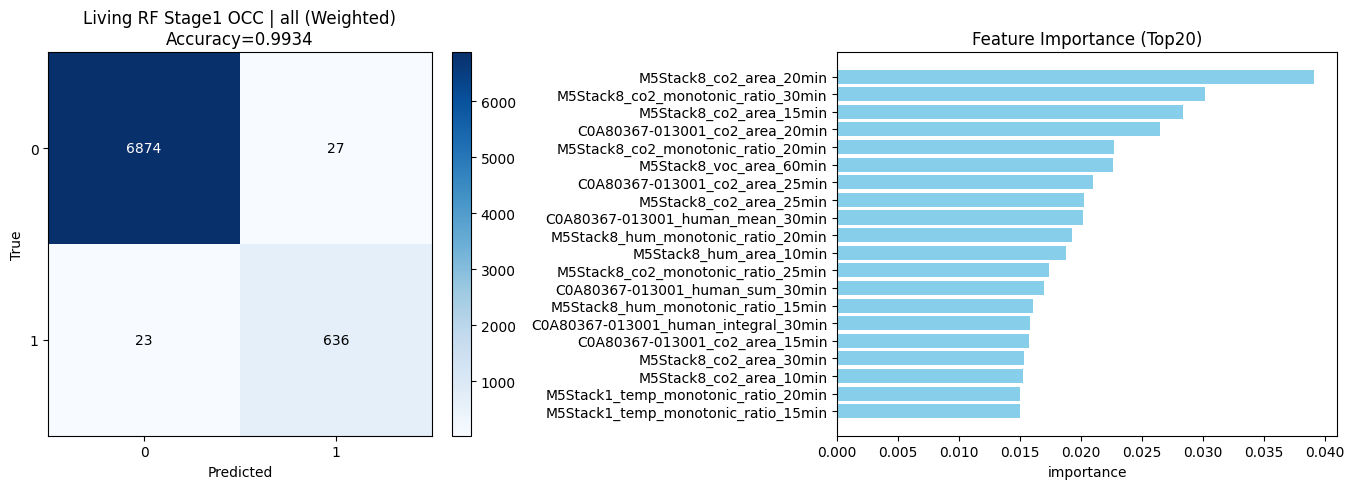


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.8619
[[281  39]
 [ 52 287]]


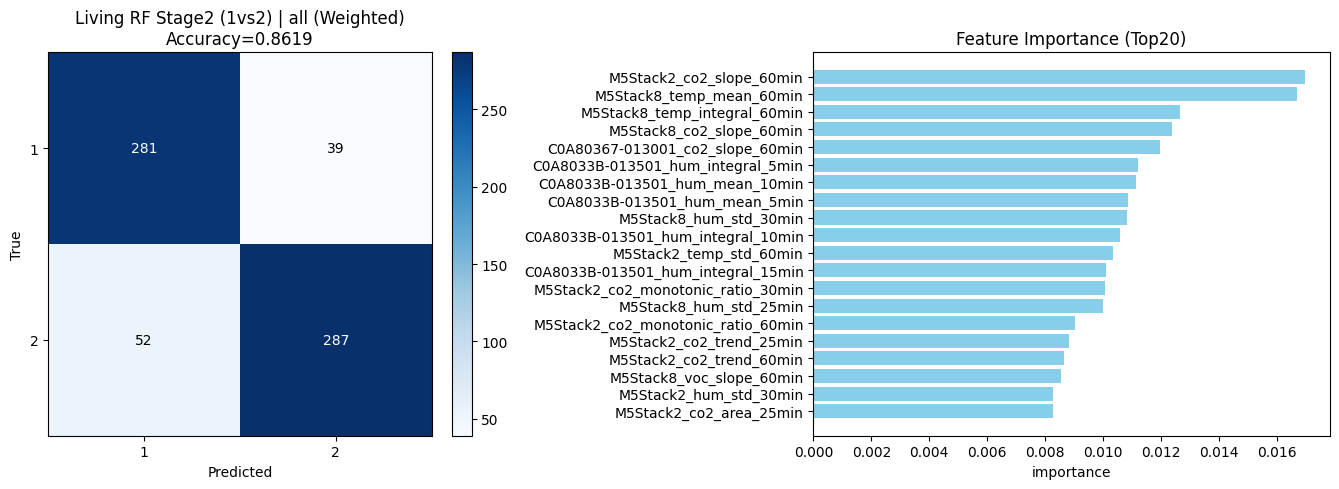


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9829
[[6874    4   23]
 [  23  270   27]
 [   0   52  287]]
              precision    recall  f1-score   support

           0      0.997     0.996     0.996      6901
           1      0.828     0.844     0.836       320
           2      0.852     0.847     0.849       339

    accuracy                          0.983      7560
   macro avg      0.892     0.895     0.894      7560
weighted avg      0.983     0.983     0.983      7560



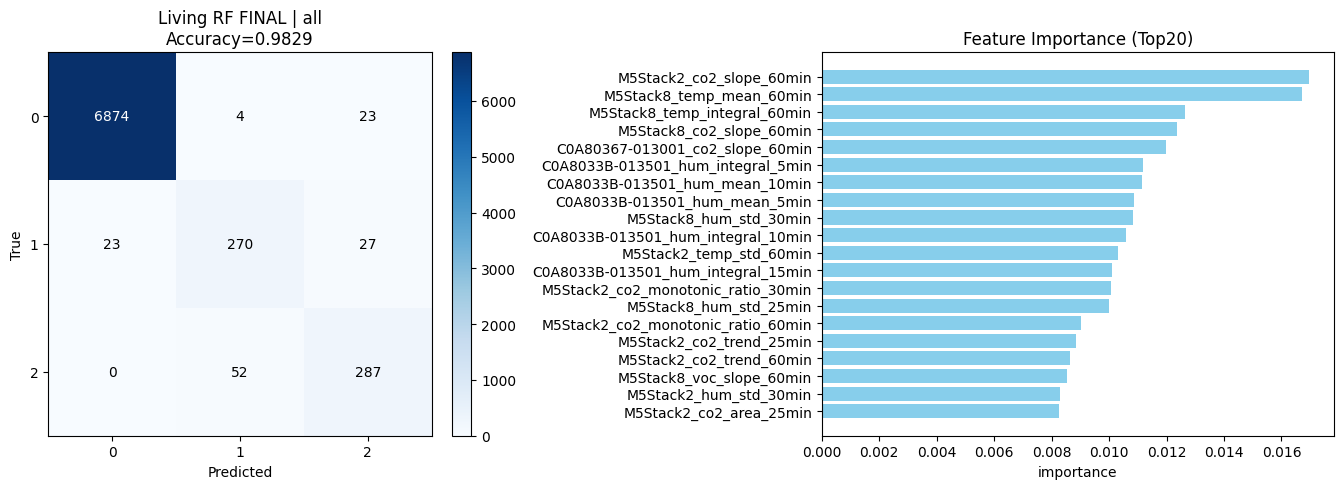


[Living][RF 2-stage] setting=appliance_only | features=1406 | train=17591 test=7560
label dist test: {0: 6901, 2: 339, 1: 320}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9933
[[6876   25]
 [  26  633]]


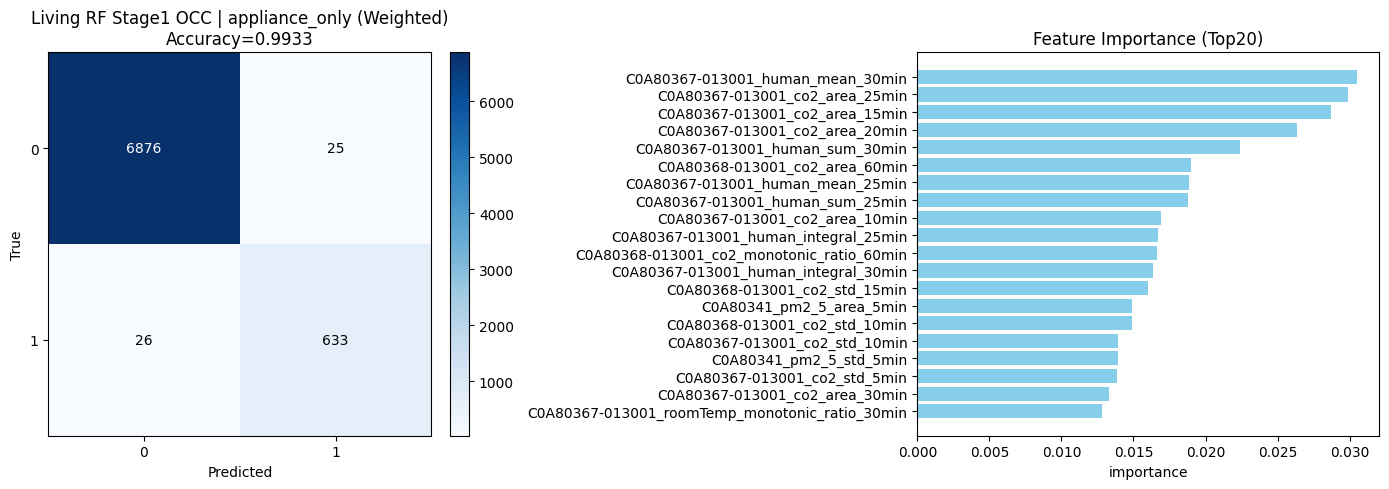


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.8619
[[283  37]
 [ 54 285]]


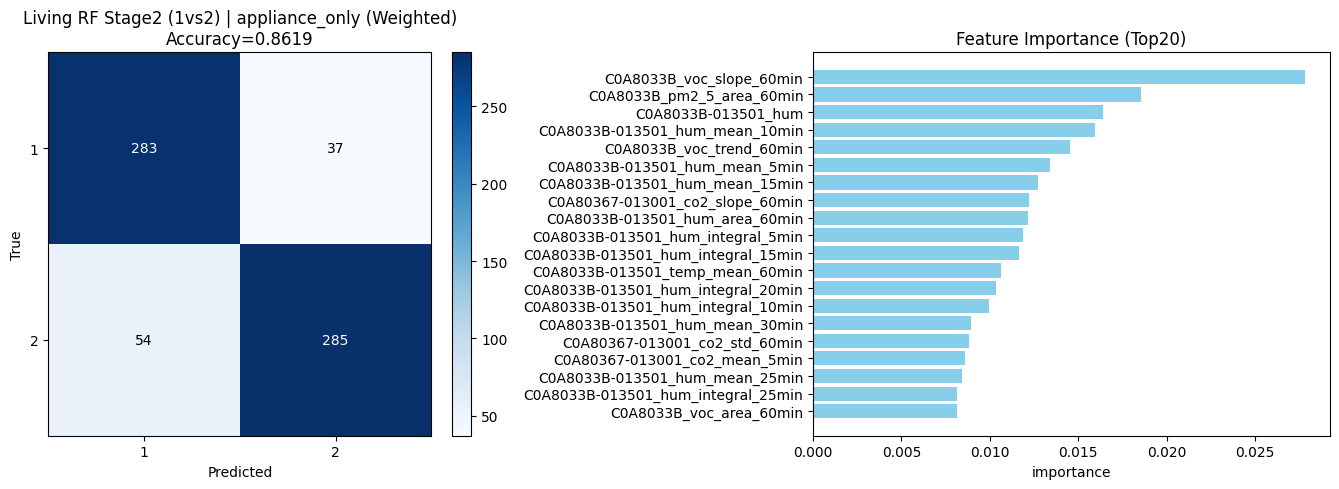


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9841
[[6876    6   19]
 [  24  280   16]
 [   2   53  284]]
              precision    recall  f1-score   support

           0      0.996     0.996     0.996      6901
           1      0.826     0.875     0.850       320
           2      0.890     0.838     0.863       339

    accuracy                          0.984      7560
   macro avg      0.904     0.903     0.903      7560
weighted avg      0.984     0.984     0.984      7560



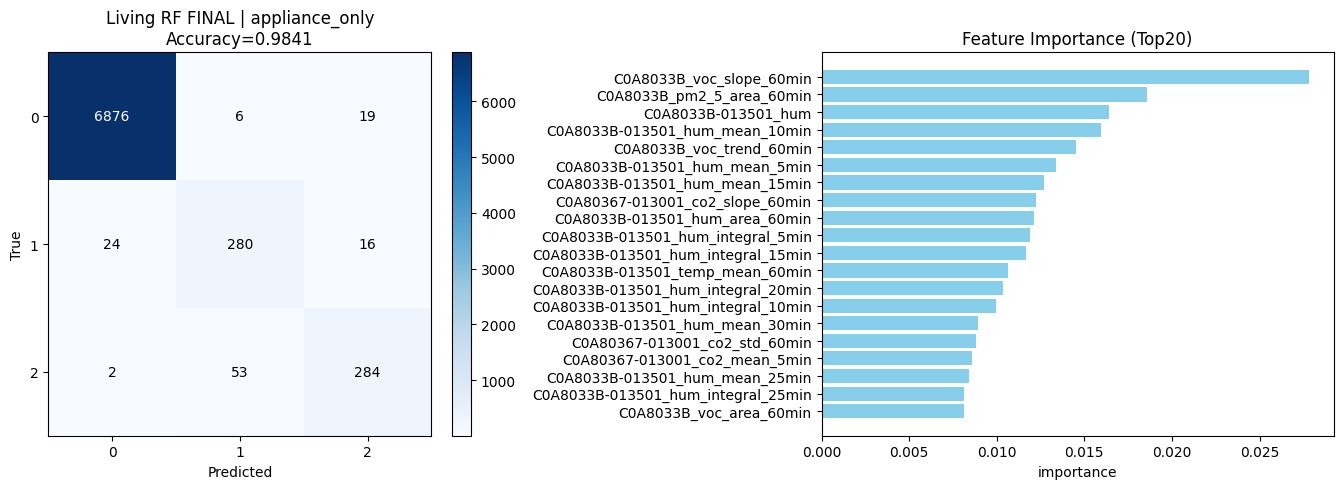


RUN: Japanese (RF 2-stage) - Weighted

[Japanese][RF 2-stage] setting=all | features=1281 | train=17591 test=7560
label dist test: {0: 7142, 1: 228, 2: 190}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9810
[[7099   43]
 [ 101  317]]


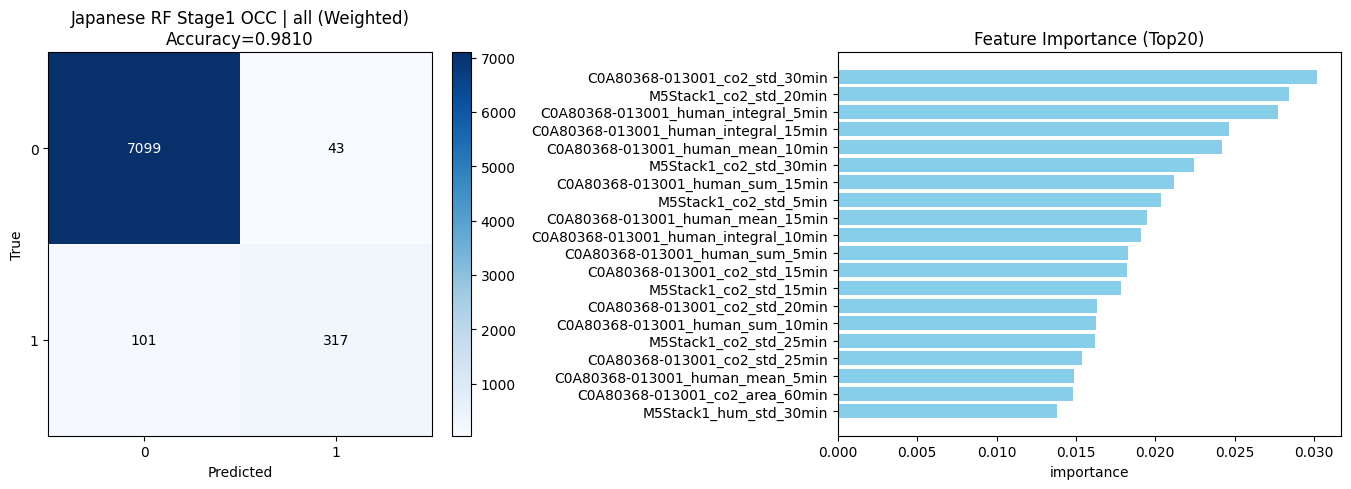


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.9952
[[226   2]
 [  0 190]]


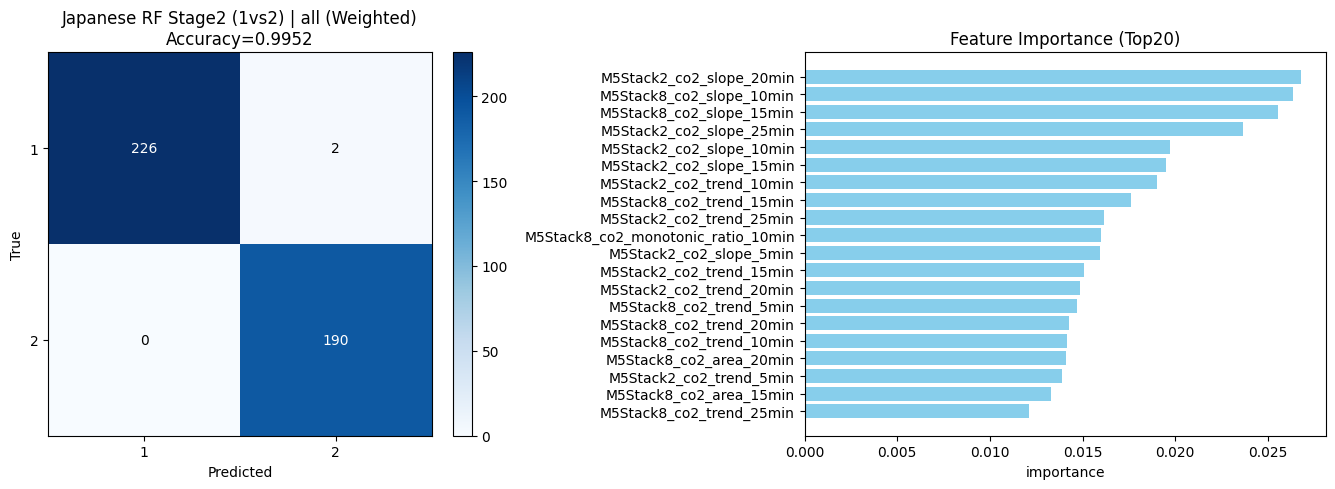


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9810
[[7099   35    8]
 [  54  174    0]
 [  47    0  143]]
              precision    recall  f1-score   support

           0      0.986     0.994     0.990      7142
           1      0.833     0.763     0.796       228
           2      0.947     0.753     0.839       190

    accuracy                          0.981      7560
   macro avg      0.922     0.837     0.875      7560
weighted avg      0.980     0.981     0.980      7560



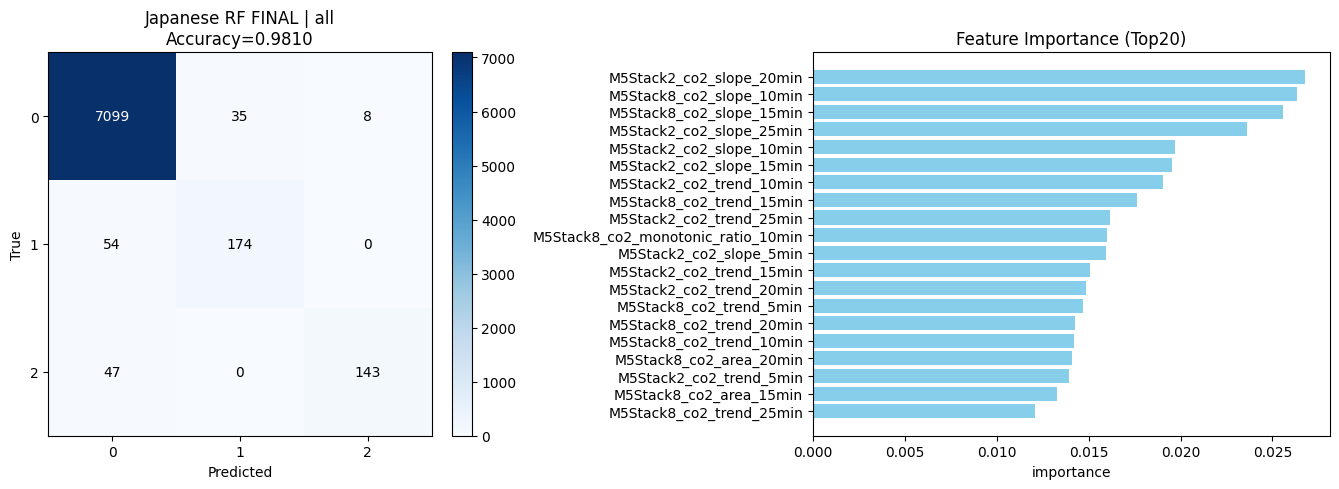


[Japanese][RF 2-stage] setting=appliance_only | features=1406 | train=17591 test=7560
label dist test: {0: 7142, 1: 228, 2: 190}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9778
[[7109   33]
 [ 135  283]]


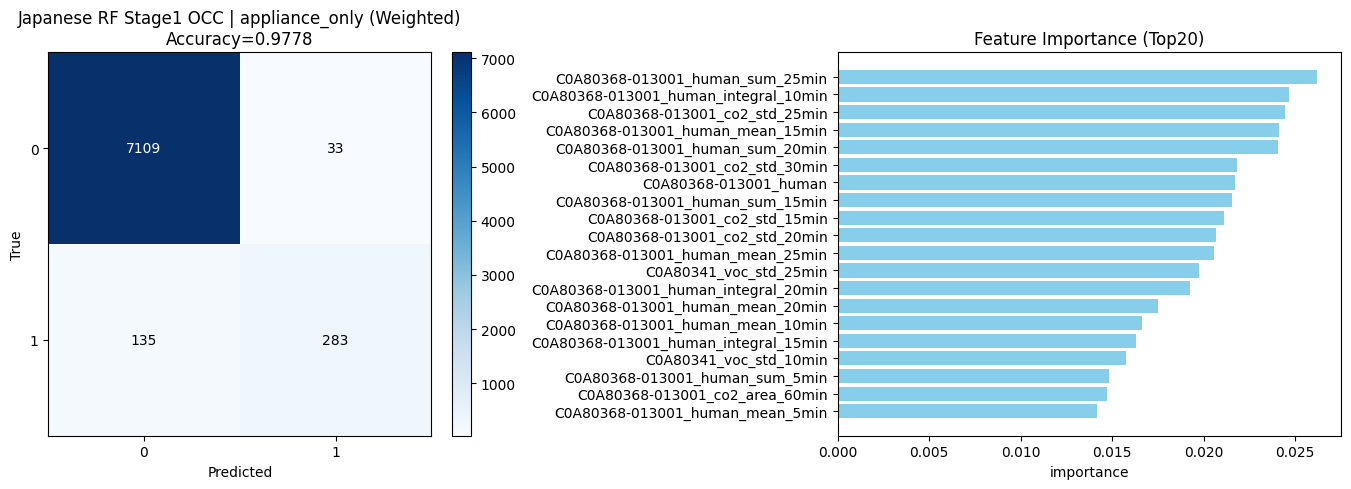


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.9904
[[228   0]
 [  4 186]]


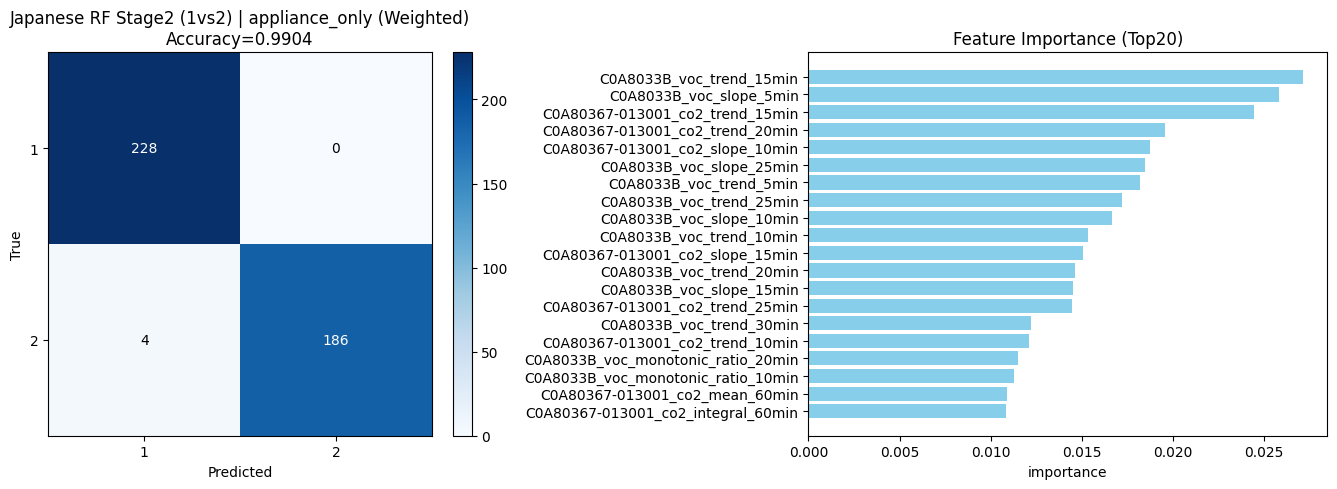


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9778
[[7109   33    0]
 [  42  186    0]
 [  93    0   97]]
              precision    recall  f1-score   support

           0      0.981     0.995     0.988      7142
           1      0.849     0.816     0.832       228
           2      1.000     0.511     0.676       190

    accuracy                          0.978      7560
   macro avg      0.944     0.774     0.832      7560
weighted avg      0.978     0.978     0.976      7560



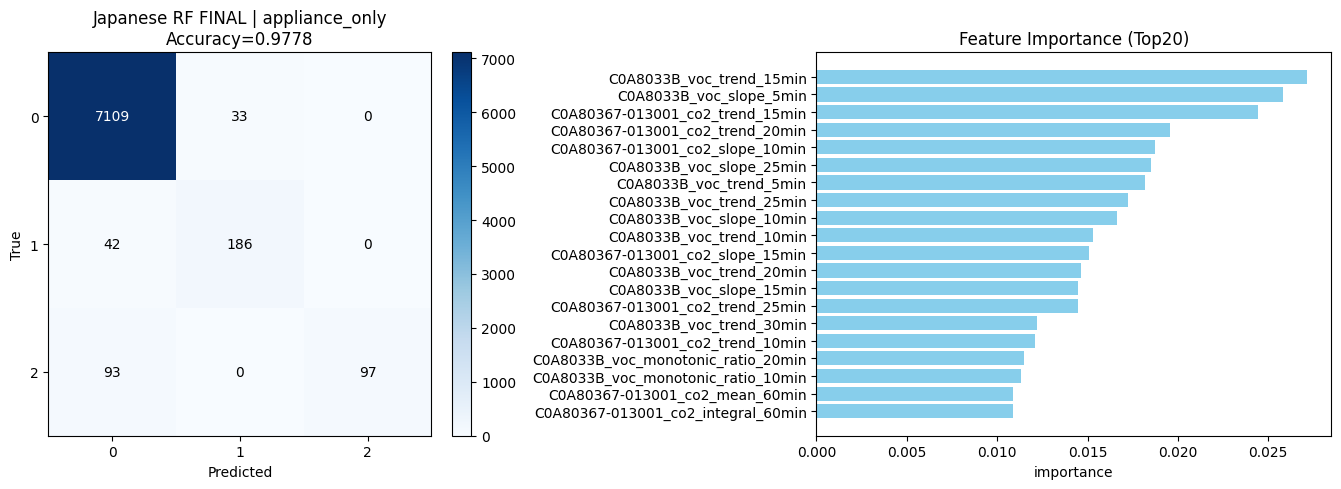


✅ Done.


In [8]:
# ============================================================
# Hybrid pipeline (0/1/2 people count) - Weighted (Class Weight)
# RF Applied to Both Rooms
# Removed "no_co2_human" setting
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
CSV_PATH = "smart_home_data0116.csv"
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20

SEED = 42

# RF: block group split settings
BLOCK_MINUTES = 30
TEST_RATIO = 0.30

# If you still want CSV for importance (optional)
SAVE_IMPORTANCE_CSV = False

# Appliance prefixes
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")

# =========================
# Utilities
# =========================
def to_dt(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce")

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    dfr = dfr.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return dfr

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def uniq(xs):
    return list(dict.fromkeys(xs))

def is_pm25(name: str) -> bool:
    n = name.lower()
    return ("pm2_5" in n) or ("pm2.5" in n) or ("pm25" in n)

def is_co2(name: str) -> bool:
    n = name.lower()
    return n.endswith("_co2") or ("_co2_" in n)

def is_voc(name: str) -> bool:
    return "voc" in name.lower()

def is_temp_hum_like(name: str) -> bool:
    n = name.lower()
    return ("_temp" in n) or ("temp" in n) or ("_hum" in n) or ("humid" in n)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

# -------------------------------

def plot_cm_and_importance(title_prefix, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    top = imp.head(topk)[::-1]

    fig = plt.figure(figsize=(14, 5))

    # CM
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues")
    ax1.set_title(f"{title_prefix}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color="black" if cm[i,j] < cm.max()/2 else "white")

    # Importance
    ax2 = plt.subplot(1, 2, 2)
    ax2.barh(top.index, top.values, color="skyblue")
    ax2.set_title(f"Feature Importance (Top{topk})")
    ax2.set_xlabel("importance")
    plt.tight_layout()
    plt.show()


# =========================
# Feature engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3:
        return pd.Series(0.0, index=y.index)

    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)

    if denom == 0: return pd.Series(0.0, index=y.index)

    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        return np.dot(t_centered, (a - a.mean())) / denom

    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def _monotonic_ratio(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    pos = (d > 0).astype(float)
    return pos.rolling(window, min_periods=1).mean().fillna(0.0)

def _area_from_baseline(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    base = y.rolling(window, min_periods=1).min()
    return (y - base).rolling(window, min_periods=1).sum().fillna(0.0)

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns:
            continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)

        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff_1min"] = d1

        for w in wins:
            feats[f"{c}_mean_{w}min"] = s.rolling(w, min_periods=1).mean().fillna(0.0)
            feats[f"{c}_std_{w}min"]  = s.rolling(w, min_periods=1).std().fillna(0.0)

            feats[f"{c}_slope_{w}min"] = ((s - s.shift(w)) / float(w)).fillna(0.0)
            feats[f"{c}_integral_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

            feats[f"{c}_trend_{w}min"] = _rolling_linreg_slope(s, w)
            feats[f"{c}_monotonic_ratio_{w}min"] = _monotonic_ratio(s, w)
            feats[f"{c}_area_{w}min"] = _area_from_baseline(s, w)

            feats[f"{c}_accel_{w}min"] = (d1 - d1.rolling(w, min_periods=1).mean()).fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns:
            continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X


# =========================
# Column packers
# =========================
def pick_room_columns_latest(df: pd.DataFrame, room: str):
    if room == "Living":
        label = "Label_Living_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80367-013001_") or c.startswith("C0A8033B-013501_")]
    elif room == "Japanese":
        label = "Label_Japanese_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80368-013001_") or c.startswith("C0A80341-013501_")]
    else:
        raise ValueError("room must be Living or Japanese")

    m5_cols = [c for c in df.columns if (c.startswith("M5Stack1_") or c.startswith("M5Stack2_") or c.startswith("M5Stack8_"))]
    pir_cols = [c for c in df.columns if c.lower().startswith("pir")]

    candidate_num = appliance_cols + m5_cols

    co2_cols  = [c for c in candidate_num if is_co2(c)]
    pm25_cols = [c for c in candidate_num if is_pm25(c)]
    voc_cols  = [c for c in candidate_num if is_voc(c)]
    th_cols   = [c for c in candidate_num if is_temp_hum_like(c)]

    human_cols = [c for c in candidate_num if c.lower().endswith("_human")] + pir_cols

    appliance_only = [c for c in df.columns if c.startswith(APPLIANCE_PREFIXES)]
    app_co2  = [c for c in appliance_only if is_co2(c)]
    app_pm25 = [c for c in appliance_only if is_pm25(c)]
    app_voc  = [c for c in appliance_only if is_voc(c)]
    app_th   = [c for c in appliance_only if is_temp_hum_like(c)]
    app_human= [c for c in appliance_only if c.lower().endswith("_human")]

    return dict(
        label=label,
        co2_cols=uniq([c for c in co2_cols if c in df.columns]),
        pm25_cols=uniq([c for c in pm25_cols if c in df.columns]),
        voc_cols=uniq([c for c in voc_cols if c in df.columns]),
        th_cols=uniq([c for c in th_cols if c in df.columns]),
        human_cols=uniq([c for c in human_cols if c in df.columns]),
        app_co2=uniq([c for c in app_co2 if c in df.columns]),
        app_pm25=uniq([c for c in app_pm25 if c in df.columns]),
        app_voc=uniq([c for c in app_voc if c in df.columns]),
        app_th=uniq([c for c in app_th if c in df.columns]),
        app_human=uniq([c for c in app_human if c in df.columns]),
    )


# =========================
# Shared: RandomForest 2-stage Models
# =========================
def rf_occ_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

def rf_cnt_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

# =========================
# Japanese: Random Forest 2-stage
# =========================
def run_japanese_rf_2stage(df: pd.DataFrame, setting: str):
    room = "Japanese"
    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {room}: {label_col} not found")
        return

    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin([0, 1, 2]), np.nan).ffill().fillna(0).astype(int)

    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]
    else:
        raise ValueError("Japanese RF setting must be all or appliance_only")

    num_cols = uniq([c for c in num_cols if c in df.columns])
    hum_cols = uniq([c for c in hum_cols if c in df.columns])

    X_num = build_numeric_features_multiwin(df, num_cols, WINS) if len(num_cols) else pd.DataFrame(index=df.index)
    X_hum = build_human_features(df, hum_cols, WINS) if len(hum_cols) else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_hum], axis=1).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]

    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr = X.iloc[tr_idx].to_numpy(dtype=np.float32)
    y_tr = y.iloc[tr_idx].to_numpy(dtype=int)
    X_te = X.iloc[te_idx].to_numpy(dtype=np.float32)
    y_te = y.iloc[te_idx].to_numpy(dtype=int)

    X_tr[~np.isfinite(X_tr)] = 0.0
    X_te[~np.isfinite(X_te)] = 0.0

    print("\n" + "=" * 92)
    print(f"[Japanese][RF 2-stage] setting={setting} | features={X.shape[1]} | train={len(tr_idx)} test={len(te_idx)}")
    print(f"label dist test: {pd.Series(y_te).value_counts().to_dict()}")
    print("=" * 92)

    # --- Stage1: occupancy ---
    y_tr_occ = (y_tr > 0).astype(int)
    y_te_occ = (y_te > 0).astype(int)

    occ_model = rf_occ_model()
    occ_model.fit(X_tr, y_tr_occ)
    pred_occ = occ_model.predict(X_te)

    print("\n--- Stage1: Occupancy (0 vs >0) ---")
    print(f"Accuracy: {accuracy_score(y_te_occ, pred_occ):.4f}")
    print(confusion_matrix(y_te_occ, pred_occ, labels=[0, 1]))

    plot_cm_and_importance(
        title_prefix=f"Japanese RF Stage1 OCC | {setting} (Weighted)",
        y_true=y_te_occ, y_pred=pred_occ,
        labels=[0, 1],
        feature_names=X.columns.tolist(),
        importances=occ_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

    # --- Stage2: 1 vs 2 ---
    tr_mask = (y_tr > 0)
    te_mask = (y_te > 0)

    X_tr_in = X_tr[tr_mask]
    y_tr_in = y_tr[tr_mask]
    X_te_in = X_te[te_mask]
    y_te_in = y_te[te_mask]

    if len(np.unique(y_tr_in)) >= 2 and len(y_te_in) > 0:
        cnt_model = rf_cnt_model()
        cnt_model.fit(X_tr_in, y_tr_in)
        pred_in = cnt_model.predict(X_te_in)

        print("\n--- Stage2: Count (1 vs 2) on occupied-only ---")
        print(f"Accuracy: {accuracy_score(y_te_in, pred_in):.4f}")
        print(confusion_matrix(y_te_in, pred_in, labels=[1, 2]))

        plot_cm_and_importance(
            title_prefix=f"Japanese RF Stage2 (1vs2) | {setting} (Weighted)",
            y_true=y_te_in, y_pred=pred_in,
            labels=[1, 2],
            feature_names=X.columns.tolist(),
            importances=cnt_model.feature_importances_,
            topk=TOPK_IMPORTANCE
        )
    else:
        print("[WARN] Stage2 (1vs2) insufficient data, skip.")
        return

    # --- Final ---
    final_pred = np.zeros_like(y_te)
    pred_occ_mask = (pred_occ == 1)
    if pred_occ_mask.sum() > 0:
        final_pred[pred_occ_mask] = cnt_model.predict(X_te[pred_occ_mask])

    print("\n--- FINAL (0/1/2 by 2-stage) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred):.4f}")
    print(confusion_matrix(y_te, final_pred, labels=[0, 1, 2]))
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    plot_cm_and_importance(
        title_prefix=f"Japanese RF FINAL | {setting}",
        y_true=y_te, y_pred=final_pred,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=cnt_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )


# =========================
# Living: RandomForest 2-stage
# =========================
def run_living_rf_2stage(df: pd.DataFrame, setting: str):
    room = "Living"
    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {room}: {label_col} not found")
        return

    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin([0, 1, 2]), np.nan).ffill().fillna(0).astype(int)

    # feature set by setting
    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]
    else:
        raise ValueError("Living RF setting must be all / appliance_only")

    num_cols = uniq([c for c in num_cols if c in df.columns])
    hum_cols = uniq([c for c in hum_cols if c in df.columns])

    X_num = build_numeric_features_multiwin(df, num_cols, WINS) if len(num_cols) else pd.DataFrame(index=df.index)
    X_hum = build_human_features(df, hum_cols, WINS) if len(hum_cols) else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_hum], axis=1).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]

    # group split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr = X.iloc[tr_idx].to_numpy(dtype=np.float32)
    y_tr = y.iloc[tr_idx].to_numpy(dtype=int)
    X_te = X.iloc[te_idx].to_numpy(dtype=np.float32)
    y_te = y.iloc[te_idx].to_numpy(dtype=int)

    X_tr[~np.isfinite(X_tr)] = 0.0
    X_te[~np.isfinite(X_te)] = 0.0

    print("\n" + "=" * 92)
    print(f"[Living][RF 2-stage] setting={setting} | features={X.shape[1]} | train={len(tr_idx)} test={len(te_idx)}")
    print(f"label dist test: {pd.Series(y_te).value_counts().to_dict()}")
    print("=" * 92)

    # --- Stage1: occupancy ---
    y_tr_occ = (y_tr > 0).astype(int)
    y_te_occ = (y_te > 0).astype(int)

    occ_model = rf_occ_model()
    occ_model.fit(X_tr, y_tr_occ)
    pred_occ = occ_model.predict(X_te)

    print("\n--- Stage1: Occupancy (0 vs >0) ---")
    print(f"Accuracy: {accuracy_score(y_te_occ, pred_occ):.4f}")
    print(confusion_matrix(y_te_occ, pred_occ, labels=[0, 1]))

    plot_cm_and_importance(
        title_prefix=f"Living RF Stage1 OCC | {setting} (Weighted)",
        y_true=y_te_occ, y_pred=pred_occ,
        labels=[0, 1],
        feature_names=X.columns.tolist(),
        importances=occ_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

    # --- Stage2: 1 vs 2 ---
    tr_mask = (y_tr > 0)
    te_mask = (y_te > 0)

    X_tr_in = X_tr[tr_mask]
    y_tr_in = y_tr[tr_mask]
    X_te_in = X_te[te_mask]
    y_te_in = y_te[te_mask]

    if len(np.unique(y_tr_in)) >= 2 and len(y_te_in) > 0:
        cnt_model = rf_cnt_model()
        cnt_model.fit(X_tr_in, y_tr_in)
        pred_in = cnt_model.predict(X_te_in)

        print("\n--- Stage2: Count (1 vs 2) on occupied-only ---")
        print(f"Accuracy: {accuracy_score(y_te_in, pred_in):.4f}")
        print(confusion_matrix(y_te_in, pred_in, labels=[1, 2]))

        plot_cm_and_importance(
            title_prefix=f"Living RF Stage2 (1vs2) | {setting} (Weighted)",
            y_true=y_te_in, y_pred=pred_in,
            labels=[1, 2],
            feature_names=X.columns.tolist(),
            importances=cnt_model.feature_importances_,
            topk=TOPK_IMPORTANCE
        )
    else:
        print("[WARN] Stage2 (1vs2) insufficient data, skip.")
        return

    # --- Final ---
    final_pred = np.zeros_like(y_te)
    pred_occ_mask = (pred_occ == 1)
    if pred_occ_mask.sum() > 0:
        final_pred[pred_occ_mask] = cnt_model.predict(X_te[pred_occ_mask])

    print("\n--- FINAL (0/1/2 by 2-stage) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred):.4f}")
    print(confusion_matrix(y_te, final_pred, labels=[0, 1, 2]))
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    plot_cm_and_importance(
        title_prefix=f"Living RF FINAL | {setting}",
        y_true=y_te, y_pred=final_pred,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=cnt_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )


# =========================
# Main
# =========================
print("📥 Loading CSV...")
try:
    df0 = pd.read_csv(CSV_PATH, low_memory=False)
except UnicodeDecodeError:
    print("Warning: Standard encoding failed. Trying 'cp932'.")
    df0 = pd.read_csv(CSV_PATH, low_memory=False, encoding='cp932')

if TIME_COL not in df0.columns:
    raise ValueError(f"CSVに {TIME_COL} 列がありません。")

df0[TIME_COL] = to_dt(df0[TIME_COL])
df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)

# forward-only preprocessing
df0 = safe_ffill(df0).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

# resample to 1min
print("Resampling to 1min...")
df = resample_1min(df0, RESAMPLE_RULE)

# ---- Living: RF ----
print("\n============================")
print("RUN: Living (RF 2-stage) - Weighted")
print("============================")
# Removed "no_co2_human" from the loop
for setting in ["all", "appliance_only"]:
    run_living_rf_2stage(df, setting)

# ---- Japanese: RF ----
print("\n============================")
print("RUN: Japanese (RF 2-stage) - Weighted")
print("============================")
for setting in ["all", "appliance_only"]:
    run_japanese_rf_2stage(df, setting)

print("\n✅ Done.")

📥 Loading CSV: smart_home_data0116_no_sensor.csv ...
Resampling to 1min...

[Living][RF Multi-Class] Setting=ApplianceOnly | Features=1406 | Train=17591 Test=7560
Label dist (Test): {0: 6901, 2: 339, 1: 320}

--- Classification Report (0 vs 1 vs 2) [Living] ---
Accuracy: 0.9833
[[6867    0   34]
 [  31  274   15]
 [   5   41  293]]
              precision    recall  f1-score   support

           0      0.995     0.995     0.995      6901
           1      0.870     0.856     0.863       320
           2      0.857     0.864     0.860       339

    accuracy                          0.983      7560
   macro avg      0.907     0.905     0.906      7560
weighted avg      0.983     0.983     0.983      7560



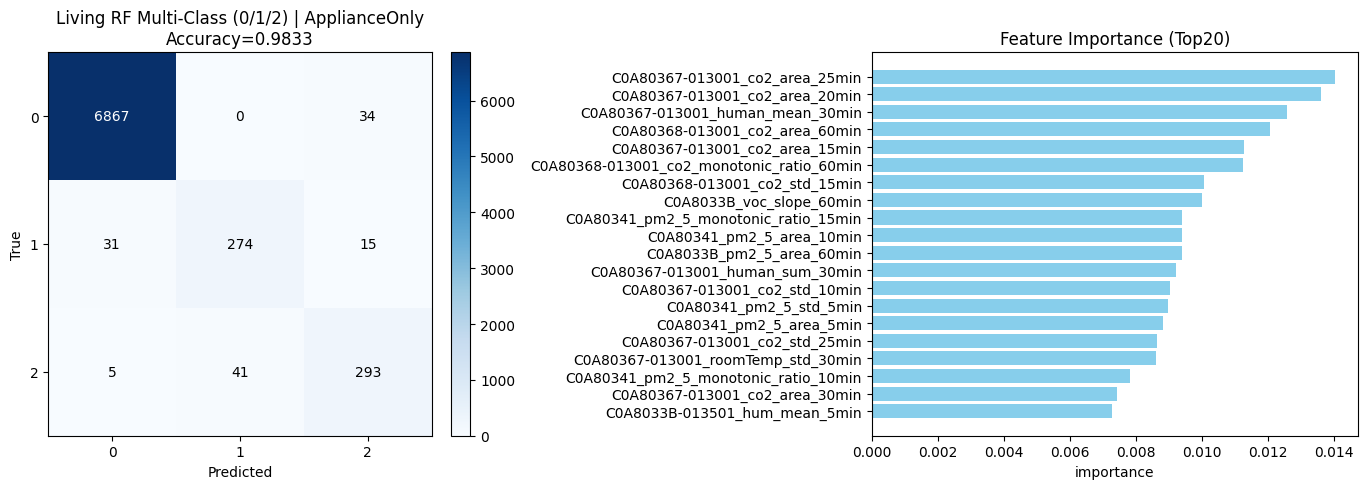


[Japanese][RF Multi-Class] Setting=ApplianceOnly | Features=1406 | Train=17591 Test=7560
Label dist (Test): {0: 7142, 1: 228, 2: 190}

--- Classification Report (0 vs 1 vs 2) [Japanese] ---
Accuracy: 0.9831
[[7114   28    0]
 [  39  189    0]
 [  61    0  129]]
              precision    recall  f1-score   support

           0      0.986     0.996     0.991      7142
           1      0.871     0.829     0.849       228
           2      1.000     0.679     0.809       190

    accuracy                          0.983      7560
   macro avg      0.952     0.835     0.883      7560
weighted avg      0.983     0.983     0.982      7560



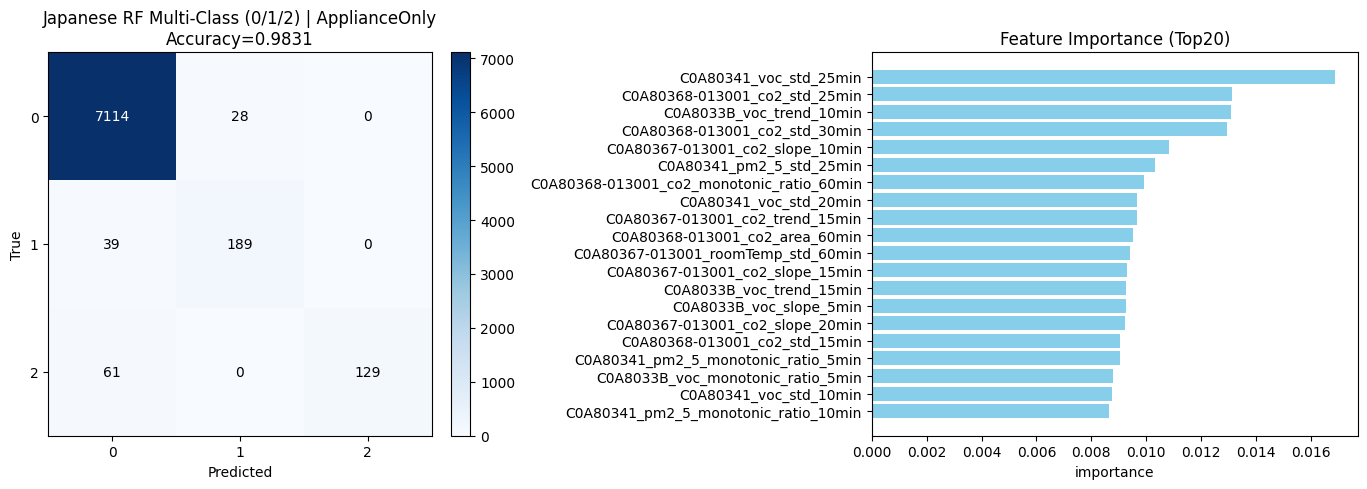


✅ Done.


In [15]:
# ============================================================
# Single-Stage Pipeline (0 vs 1 vs 2) - Weighted RF
# Dataset: Appliance Sensors Only (Robust Timestamp Fix)
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
CSV_PATH = "smart_home_data0116_no_sensor.csv"
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20

SEED = 42

# RF: block group split settings
BLOCK_MINUTES = 30
TEST_RATIO = 0.30

# Appliance prefixes
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    """
    'MM:SS.f' (例: 49:55.6) のような形式を読み込み、
    59分 -> 00分 のような繰り上がりを検知して連続した日時に補正する。
    """
    s = df[col].astype(str)

    # すでに "2025-..." のような完全な形式ならそのまま変換
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")

    print("⚠️ タイムスタンプが不完全(MM:SS.f)なため、時系列補正を行います...")

    # 1. まずそのままパース (1900-01-01 00:MM:SS.f になる)
    # フォーマットはデータに合わせて調整
    temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')

    # パース失敗が多い場合はエラー
    if temp_dates.isna().mean() > 0.5:
        # 別のフォーマットを試す (例: 時間がある場合など)
        temp_dates = pd.to_datetime(s, errors='coerce')

    # 2. 繰り上がり補正
    # 前の行より時間が大きく戻った場合（例: 59分->00分）、日付(時間)を進める
    # diffがマイナス（例: -50分）になったら、それは時間の繰り上がりとみなす
    diff = temp_dates.diff()

    # "30分以上時間が戻った" 箇所を検知 (例: 59:59 -> 00:00)
    # タイムデルタの比較なので、 -30分 = -1800秒
    wrap_indices = diff < pd.Timedelta(minutes=-30)

    # 累積和をとって、加算すべき時間(オフセット)を計算
    # 1回繰り上がるごとに +1時間 する
    hours_to_add = wrap_indices.cumsum()

    # オフセットを加算
    fixed_dates = temp_dates + pd.to_timedelta(hours_to_add, unit='h')

    return fixed_dates

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    dfr = dfr.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return dfr

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def uniq(xs):
    return list(dict.fromkeys(xs))

def is_pm25(name: str) -> bool:
    n = name.lower()
    return ("pm2_5" in n) or ("pm2.5" in n) or ("pm25" in n)

def is_co2(name: str) -> bool:
    n = name.lower()
    return n.endswith("_co2") or ("_co2_" in n)

def is_voc(name: str) -> bool:
    return "voc" in name.lower()

def is_temp_hum_like(name: str) -> bool:
    n = name.lower()
    return ("_temp" in n) or ("temp" in n) or ("_hum" in n) or ("humid" in n)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

def plot_cm_and_importance(title_prefix, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    top = imp.head(topk)[::-1]

    fig = plt.figure(figsize=(14, 5))

    # CM
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues")
    ax1.set_title(f"{title_prefix}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color="black" if cm[i,j] < cm.max()/2 else "white")

    # Importance
    ax2 = plt.subplot(1, 2, 2)
    ax2.barh(top.index, top.values, color="skyblue")
    ax2.set_title(f"Feature Importance (Top{topk})")
    ax2.set_xlabel("importance")
    plt.tight_layout()
    plt.show()


# =========================
# Feature Engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3:
        return pd.Series(0.0, index=y.index)

    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)
    if denom == 0: return pd.Series(0.0, index=y.index)

    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        return np.dot(t_centered, (a - a.mean())) / denom
    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def _monotonic_ratio(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    pos = (d > 0).astype(float)
    return pos.rolling(window, min_periods=1).mean().fillna(0.0)

def _area_from_baseline(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    base = y.rolling(window, min_periods=1).min()
    return (y - base).rolling(window, min_periods=1).sum().fillna(0.0)

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns:
            continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)

        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff_1min"] = d1

        for w in wins:
            feats[f"{c}_mean_{w}min"] = s.rolling(w, min_periods=1).mean().fillna(0.0)
            feats[f"{c}_std_{w}min"]  = s.rolling(w, min_periods=1).std().fillna(0.0)
            feats[f"{c}_slope_{w}min"] = ((s - s.shift(w)) / float(w)).fillna(0.0)
            feats[f"{c}_integral_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)
            feats[f"{c}_trend_{w}min"] = _rolling_linreg_slope(s, w)
            feats[f"{c}_monotonic_ratio_{w}min"] = _monotonic_ratio(s, w)
            feats[f"{c}_area_{w}min"] = _area_from_baseline(s, w)
            feats[f"{c}_accel_{w}min"] = (d1 - d1.rolling(w, min_periods=1).mean()).fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns:
            continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X


# =========================
# Column Picker
# =========================
def pick_room_columns_appliance_only(df: pd.DataFrame, room: str):
    if room == "Living":
        label = "Label_Living_Count"
    elif room == "Japanese":
        label = "Label_Japanese_Count"
    else:
        raise ValueError("room must be Living or Japanese")

    appliance_only = [c for c in df.columns if c.startswith(APPLIANCE_PREFIXES)]

    app_co2   = [c for c in appliance_only if is_co2(c)]
    app_pm25  = [c for c in appliance_only if is_pm25(c)]
    app_voc   = [c for c in appliance_only if is_voc(c)]
    app_th    = [c for c in appliance_only if is_temp_hum_like(c)]
    app_human = [c for c in appliance_only if c.lower().endswith("_human")]

    return dict(
        label=label,
        app_co2=uniq(app_co2),
        app_pm25=uniq(app_pm25),
        app_voc=uniq(app_voc),
        app_th=uniq(app_th),
        app_human=uniq(app_human),
    )


# =========================
# Single-Stage RandomForest Model
# =========================
def rf_multiclass_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample", # データの偏りを自動的に重みづけ補正
        min_samples_leaf=2,
    )


# =========================
# RF Execution Logic
# =========================
def run_rf_multiclass_room(df: pd.DataFrame, room: str):
    pack = pick_room_columns_appliance_only(df, room)
    label_col = pack["label"]

    if label_col not in df.columns:
        print(f"[SKIP] {room}: {label_col} not found")
        return

    # Labels 0 vs 1 vs 2
    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin([0, 1, 2]), np.nan).ffill().fillna(0).astype(int)

    # Features
    num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
    hum_cols = pack["app_human"]

    num_cols = uniq([c for c in num_cols if c in df.columns])
    hum_cols = uniq([c for c in hum_cols if c in df.columns])

    # Build
    X_num = build_numeric_features_multiwin(df, num_cols, WINS) if len(num_cols) else pd.DataFrame(index=df.index)
    X_hum = build_human_features(df, hum_cols, WINS) if len(hum_cols) else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_hum], axis=1).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]

    # Block Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr = X.iloc[tr_idx].to_numpy(dtype=np.float32)
    y_tr = y.iloc[tr_idx].to_numpy(dtype=int)
    X_te = X.iloc[te_idx].to_numpy(dtype=np.float32)
    y_te = y.iloc[te_idx].to_numpy(dtype=int)

    X_tr[~np.isfinite(X_tr)] = 0.0
    X_te[~np.isfinite(X_te)] = 0.0

    print("\n" + "=" * 92)
    print(f"[{room}][RF Multi-Class] Setting=ApplianceOnly | Features={X.shape[1]} | Train={len(tr_idx)} Test={len(te_idx)}")
    print(f"Label dist (Test): {pd.Series(y_te).value_counts().to_dict()}")
    print("=" * 92)

    # --- Train & Evaluate (0 vs 1 vs 2) ---
    model = rf_multiclass_model()
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)

    print(f"\n--- Classification Report (0 vs 1 vs 2) [{room}] ---")
    print(f"Accuracy: {accuracy_score(y_te, pred):.4f}")
    print(confusion_matrix(y_te, pred, labels=[0, 1, 2]))
    print(classification_report(y_te, pred, digits=3, zero_division=0))

    plot_cm_and_importance(
        title_prefix=f"{room} RF Multi-Class (0/1/2) | ApplianceOnly",
        y_true=y_te, y_pred=pred,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )


# =========================
# Main
# =========================
print(f"📥 Loading CSV: {CSV_PATH} ...")
try:
    df0 = pd.read_csv(CSV_PATH, low_memory=False)
except UnicodeDecodeError:
    print("Warning: Standard encoding failed. Trying 'cp932'.")
    df0 = pd.read_csv(CSV_PATH, low_memory=False, encoding='cp932')

if TIME_COL not in df0.columns:
    raise ValueError(f"CSVに {TIME_COL} 列がありません。")

# Timestamps parsing fix (Robust)
df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)

# Preprocessing
df0 = safe_ffill(df0).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

print("Resampling to 1min...")
df = resample_1min(df0, RESAMPLE_RULE)

# Run for both rooms
for room in ["Living", "Japanese"]:
    run_rf_multiclass_room(df, room)

print("\n✅ Done.")

📥 Loading CSV: smart_home_data0116_no_sensor.csv ...
Resampling to 1min...

[Living][RF Multi-Class] ApplianceOnly | Lower Threshold=0.25 | Train=17591 Test=7560
Label dist (Test): {0: 6901, 2: 339, 1: 320}

--- Classification Report (0 vs 1 vs 2) [Living] ---
Accuracy: 0.9745
[[6790   16   95]
 [  22  281   17]
 [   0   43  296]]
              precision    recall  f1-score   support

           0      0.997     0.984     0.990      6901
           1      0.826     0.878     0.852       320
           2      0.725     0.873     0.793       339

    accuracy                          0.974      7560
   macro avg      0.850     0.912     0.878      7560
weighted avg      0.977     0.974     0.976      7560



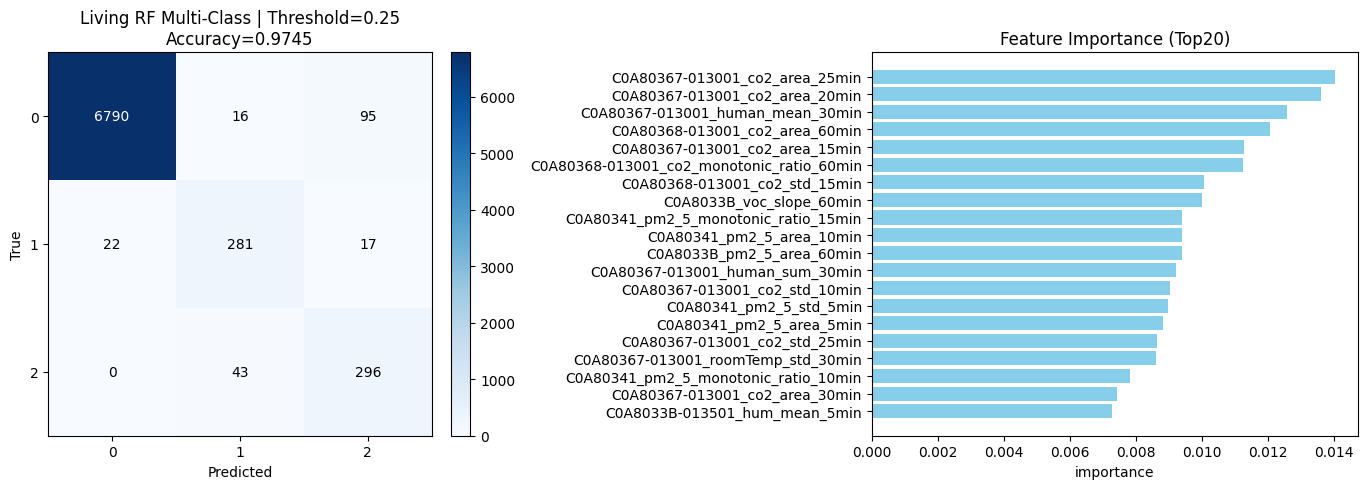


[Japanese][RF Multi-Class] ApplianceOnly | Lower Threshold=0.25 | Train=17591 Test=7560
Label dist (Test): {0: 7142, 1: 228, 2: 190}

--- Classification Report (0 vs 1 vs 2) [Japanese] ---
Accuracy: 0.9878
[[7084   55    3]
 [  15  213    0]
 [  19    0  171]]
              precision    recall  f1-score   support

           0      0.995     0.992     0.994      7142
           1      0.795     0.934     0.859       228
           2      0.983     0.900     0.940       190

    accuracy                          0.988      7560
   macro avg      0.924     0.942     0.931      7560
weighted avg      0.989     0.988     0.988      7560



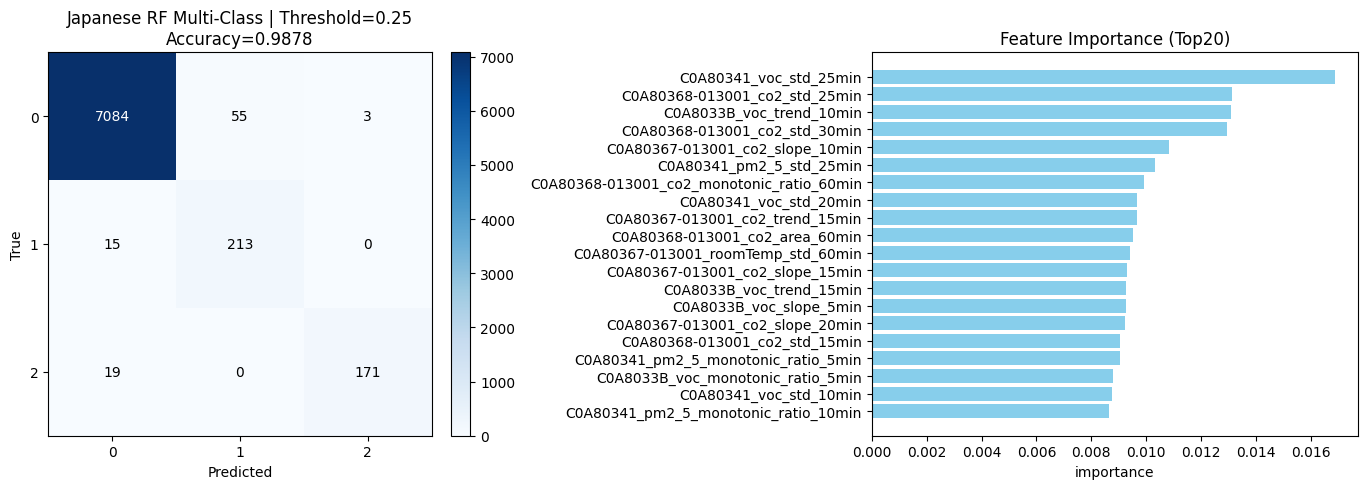


✅ Done.


In [12]:
# ============================================================
# Single-Stage Pipeline (0 vs 1 vs 2) - Weighted RF
# Adjusted Threshold for Better Recall
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# Config
# =========================
CSV_PATH = "smart_home_data0116_no_sensor.csv"
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20

SEED = 42

# RF: block group split settings
BLOCK_MINUTES = 30
TEST_RATIO = 0.30

# Threshold adjustment (Lower is more aggressive to detect people)
# Default is effectively around 0.33 for 3 classes.
# We lower the required probability for class 1 and 2 to increase recall.
THRESHOLD_OCCUPIED = 0.25  # If Prob(1 or 2) > 0.25, predict occupied

# Appliance prefixes
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")

# =========================
# Utilities
# =========================
def fix_timestamp_robust(df: pd.DataFrame, col: str) -> pd.Series:
    s = df[col].astype(str)
    if s.iloc[0].startswith("20") and "-" in s.iloc[0]:
        return pd.to_datetime(s, errors="coerce")

    print("⚠️ タイムスタンプが不完全(MM:SS.f)なため、時系列補正を行います...")
    try:
        temp_dates = pd.to_datetime(s, format='%M:%S.%f', errors='coerce')
    except:
        temp_dates = pd.to_datetime(s, errors='coerce')

    if temp_dates.isna().mean() > 0.5:
         temp_dates = pd.to_datetime(s, errors='coerce')

    diff = temp_dates.diff()
    wrap_indices = diff < pd.Timedelta(minutes=-30)
    hours_to_add = wrap_indices.cumsum()
    fixed_dates = temp_dates + pd.to_timedelta(hours_to_add, unit='h')
    return fixed_dates

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]
    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())
    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    dfr = dfr.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return dfr

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def uniq(xs):
    return list(dict.fromkeys(xs))

def is_pm25(name: str) -> bool:
    n = name.lower()
    return ("pm2_5" in n) or ("pm2.5" in n) or ("pm25" in n)

def is_co2(name: str) -> bool:
    n = name.lower()
    return n.endswith("_co2") or ("_co2_" in n)

def is_voc(name: str) -> bool:
    return "voc" in name.lower()

def is_temp_hum_like(name: str) -> bool:
    n = name.lower()
    return ("_temp" in n) or ("temp" in n) or ("_hum" in n) or ("humid" in n)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

def plot_cm_and_importance(title_prefix, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    top = imp.head(topk)[::-1]

    fig = plt.figure(figsize=(14, 5))
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues")
    ax1.set_title(f"{title_prefix}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color="black" if cm[i,j] < cm.max()/2 else "white")
    ax2 = plt.subplot(1, 2, 2)
    ax2.barh(top.index, top.values, color="skyblue")
    ax2.set_title(f"Feature Importance (Top{topk})")
    ax2.set_xlabel("importance")
    plt.tight_layout()
    plt.show()

# =========================
# Feature Engineering
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)
    if denom == 0: return pd.Series(0.0, index=y.index)
    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        return np.dot(t_centered, (a - a.mean())) / denom
    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def _monotonic_ratio(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    pos = (d > 0).astype(float)
    return pos.rolling(window, min_periods=1).mean().fillna(0.0)

def _area_from_baseline(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    base = y.rolling(window, min_periods=1).min()
    return (y - base).rolling(window, min_periods=1).sum().fillna(0.0)

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff_1min"] = d1
        for w in wins:
            feats[f"{c}_mean_{w}min"] = s.rolling(w, min_periods=1).mean().fillna(0.0)
            feats[f"{c}_std_{w}min"]  = s.rolling(w, min_periods=1).std().fillna(0.0)
            feats[f"{c}_slope_{w}min"] = ((s - s.shift(w)) / float(w)).fillna(0.0)
            feats[f"{c}_integral_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)
            feats[f"{c}_trend_{w}min"] = _rolling_linreg_slope(s, w)
            feats[f"{c}_monotonic_ratio_{w}min"] = _monotonic_ratio(s, w)
            feats[f"{c}_area_{w}min"] = _area_from_baseline(s, w)
            feats[f"{c}_accel_{w}min"] = (d1 - d1.rolling(w, min_periods=1).mean()).fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X

def pick_room_columns_appliance_only(df: pd.DataFrame, room: str):
    if room == "Living": label = "Label_Living_Count"
    elif room == "Japanese": label = "Label_Japanese_Count"
    else: raise ValueError("room must be Living or Japanese")
    appliance_only = [c for c in df.columns if c.startswith(APPLIANCE_PREFIXES)]
    app_co2   = [c for c in appliance_only if is_co2(c)]
    app_pm25  = [c for c in appliance_only if is_pm25(c)]
    app_voc   = [c for c in appliance_only if is_voc(c)]
    app_th    = [c for c in appliance_only if is_temp_hum_like(c)]
    app_human = [c for c in appliance_only if c.lower().endswith("_human")]
    return dict(label=label, app_co2=uniq(app_co2), app_pm25=uniq(app_pm25), app_voc=uniq(app_voc), app_th=uniq(app_th), app_human=uniq(app_human))

def rf_multiclass_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

# --- NEW: Custom prediction with threshold ---
def predict_with_threshold(model, X, threshold=0.3):
    """
    Predict 0, 1, or 2, but bias towards 1 or 2 if probability exceeds threshold.
    Standard RF uses argmax (highest prob). Here we override 0 if P(1 or 2) is significant.
    """
    probs = model.predict_proba(X) # Shape: (N, 3) -> [P(0), P(1), P(2)]

    # Default prediction (argmax)
    preds = np.argmax(probs, axis=1)

    # Custom Logic:
    # If P(1) >= threshold AND P(1) > P(2), predict 1
    # If P(2) >= threshold AND P(2) > P(1), predict 2
    # Even if P(0) is 0.6 and P(2) is 0.35, we might want to predict 2 to avoid false negatives.

    # Create mask where P(1) or P(2) is significant enough
    # Note: Column 0 is prob of class 0, Col 1 is class 1, Col 2 is class 2

    for i in range(len(preds)):
        p0, p1, p2 = probs[i]

        # If model thinks it's 0, but there is some evidence of presence
        if preds[i] == 0:
            # Check if either occupied prob is above threshold
            if p1 >= threshold or p2 >= threshold:
                # Pick the higher of the two occupied probabilities
                if p1 >= p2:
                    preds[i] = 1
                else:
                    preds[i] = 2

    return preds

# =========================
# RF Execution Logic
# =========================
def run_rf_multiclass_room(df: pd.DataFrame, room: str):
    pack = pick_room_columns_appliance_only(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {room}: {label_col} not found")
        return
    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin([0, 1, 2]), np.nan).ffill().fillna(0).astype(int)

    num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
    hum_cols = pack["app_human"]
    num_cols = uniq([c for c in num_cols if c in df.columns])
    hum_cols = uniq([c for c in hum_cols if c in df.columns])

    X_num = build_numeric_features_multiwin(df, num_cols, WINS) if len(num_cols) else pd.DataFrame(index=df.index)
    X_hum = build_human_features(df, hum_cols, WINS) if len(hum_cols) else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_hum], axis=1).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]

    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr = X.iloc[tr_idx].to_numpy(dtype=np.float32)
    y_tr = y.iloc[tr_idx].to_numpy(dtype=int)
    X_te = X.iloc[te_idx].to_numpy(dtype=np.float32)
    y_te = y.iloc[te_idx].to_numpy(dtype=int)
    X_tr[~np.isfinite(X_tr)] = 0.0
    X_te[~np.isfinite(X_te)] = 0.0

    print("\n" + "=" * 92)
    print(f"[{room}][RF Multi-Class] ApplianceOnly | Lower Threshold={THRESHOLD_OCCUPIED} | Train={len(tr_idx)} Test={len(te_idx)}")
    print(f"Label dist (Test): {pd.Series(y_te).value_counts().to_dict()}")
    print("=" * 92)

    model = rf_multiclass_model()
    model.fit(X_tr, y_tr)

    # Use custom threshold prediction
    pred = predict_with_threshold(model, X_te, threshold=THRESHOLD_OCCUPIED)

    print(f"\n--- Classification Report (0 vs 1 vs 2) [{room}] ---")
    print(f"Accuracy: {accuracy_score(y_te, pred):.4f}")
    print(confusion_matrix(y_te, pred, labels=[0, 1, 2]))
    print(classification_report(y_te, pred, digits=3, zero_division=0))

    plot_cm_and_importance(
        title_prefix=f"{room} RF Multi-Class | Threshold={THRESHOLD_OCCUPIED}",
        y_true=y_te, y_pred=pred,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

# =========================
# Main
# =========================
print(f"📥 Loading CSV: {CSV_PATH} ...")
try:
    df0 = pd.read_csv(CSV_PATH, low_memory=False)
except UnicodeDecodeError:
    print("Warning: Standard encoding failed. Trying 'cp932'.")
    df0 = pd.read_csv(CSV_PATH, low_memory=False, encoding='cp932')
if TIME_COL not in df0.columns:
    raise ValueError(f"CSVに {TIME_COL} 列がありません。")

df0[TIME_COL] = fix_timestamp_robust(df0, TIME_COL)
df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
df0 = safe_ffill(df0).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

print("Resampling to 1min...")
df = resample_1min(df0, RESAMPLE_RULE)

for room in ["Living", "Japanese"]:
    run_rf_multiclass_room(df, room)

print("\n✅ Done.")